# Utils

## Import Libraries

In [ ]:
import pandas as pd
import string
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem.snowball import SnowballStemmer
from nltk.tokenize import word_tokenize
from mlxtend.preprocessing import TransactionEncoder
from mlxtend.frequent_patterns import apriori
from mlxtend.frequent_patterns import association_rules
import seaborn as sns
import matplotlib.pyplot as plt
from pandas.plotting import parallel_coordinates
from wordcloud import WordCloud
from sklearn.feature_extraction.text import CountVectorizer
import numpy as np

## Download Packages

In [ ]:
nltk.download('stopwords')
nltk.download('punkt')

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

## Implement Functions

In [ ]:
def correct_types(df, columns):
    """
    Preprocess the specified columns in a DataFrame by replacing NaN values with an empty string
    and converting non-string values to string objects.

    Parameters:
    - df (pd.DataFrame): The input DataFrame.
    - column (str): The column to be preprocessed. Default is 'SO_Omschrijving'.

    Returns:
    - pd.DataFrame: The DataFrame with the specified column preprocessed.
    """

    df[columns] = df[columns].fillna('')
    df[columns] = df[columns].astype(str)
    return df

def replace_punctuation_text(text):
    """
    Replace punctuation in the input text.

    Parameters:
    - text (str): The input text in which punctuation will be replaced.

    Returns:
    - str: The input text with punctuation replaced.
    """
    # Replace "'s" with empty space.
    text = text.replace("'s", '')

    # Create a translation table to replace '.' and "'" with empty space, and other punctuation with spaces.
    translator = str.maketrans({'.': '', "'": '', **{p: ' ' for p in string.punctuation if p not in ['.', "'"]}})

    cleaned_text = text.translate(translator)

    return cleaned_text

def replace_punctuation(df, columns):
    """
    Replaces specific punctuation in the specified columns of a DataFrame.

    This function is designed to clean textual data in the specified columns of a DataFrame by:
    - Replacing occurrences of "'s" with an empty string.
    - Replacing periods (.) and apostrophes (') with an empty string.
    - Replacing other punctuation marks with a space.

    Args:
        df (pd.DataFrame): The DataFrame containing the columns to be cleaned.
        columns (list or str): The column name(s) of the DataFrame where the replacements should be applied.

    Returns:
        pd.DataFrame: The DataFrame with the specified columns cleaned of certain punctuation marks.
    """
    # Replace "'s" with an empty string in the specified columns.
    df[columns] = df[columns].replace("'s", '', regex=True)

    # Create a translation table to replace '.' and "'" with empty space,
    # and other punctuation with spaces.
    translator = str.maketrans({
        '.': '',                # Remove periods
        "'": '',                # Remove apostrophes
        **{p: ' ' for p in string.punctuation if p not in ['.', "'"]}  # Replace other punctuation with space
    })

    # Apply the translation table to each element in the specified columns.
    df[columns] = df[columns].applymap(lambda x: x.translate(translator))

    return df


def remove_numerical_values_text(text):
    """
    Remove numbers and model-related patterns from the input text.

    Parameters:
    - text (str): The input text from which numbers and model-related patterns will be removed.

    Returns:
    - str: The input text with numbers and model-related patterns removed.
    """
    # Remove standalone numbers with optional floating points; such as 154, 99.31.
    text = re.sub(r'\b\d+(\.\d+)?\b', '', text)

    # Remove ordinal numbers; such as 1e, 2ste, 3de, 4e.
    text = re.sub(r'\b\d+(e|ste|de|e)\b', '', text)

    # Remove numerical quantifiers; such as 1x OH.
    text = re.sub(r'\b\d+[xX]\b', '', text)

    return text

def remove_numerical_values(df, columns):
    """
    Removes various forms of numerical values from the specified columns in a DataFrame.

    This function cleans textual data in the specified columns by:
    - Removing standalone numbers with optional floating points (e.g., 154, 99.31).
    - Removing ordinal numbers commonly used in Dutch (e.g., 1e, 2ste, 3de, 4e).
    - Removing numerical quantifiers with 'x' (e.g., 1x, 2X).

    Args:
        df (pd.DataFrame): The DataFrame containing the columns to be cleaned.
        columns (list or str): The column name(s) of the DataFrame where the numerical values should be removed.

    Returns:
        pd.DataFrame: The DataFrame with the specified columns cleaned of numerical values.
    """
    # Remove standalone numbers with optional floating points (e.g., 154, 99.31).
    df[columns] = df[columns].applymap(lambda x: re.sub(r'\b\d+(\.\d+)?\b', '', x))

    # Remove ordinal numbers (e.g., 1e, 2ste, 3de, 4e).
    df[columns] = df[columns].applymap(lambda x: re.sub(r'\b\d+(e|ste|de)\b', '', x))

    # Remove numerical quantifiers (e.g., 1x, 2X).
    df[columns] = df[columns].applymap(lambda x: re.sub(r'\b\d+[xX]\b', '', x))

    return df

def stemize(text):
    """
    Perform stemming on the input text using the Dutch Snowball Stemmer.

    Parameters:
    - text (str): The input text to be stemmed.

    Returns:
    str: The stemmed text.

    Example:
    >>> stemize("This is an example text for stemming.")
    'thi is an exampl text for stem.'
    """
    stemmer = SnowballStemmer("dutch")
    tokens = word_tokenize(text)
    text = ' '.join([stemmer.stem(token) for token in tokens])
    return text

def normalize_lookups():
    """
    Normalize and preprocess the global lookup lists.

    This function performs the following operations on each global lookup list:
    1. Orders lookup lists by length in descending order.
    2. Initializes the Dutch Snowball Stemmer.
    3. Replaces punctuations using the `replace_punctuation` function.
    4. Removes numerical values using the `remove_numerical_values` function.
    5. Applies stemming using the `stemize` function.
    6. Converts the resulting list to a set.

    Note: The original lookup lists are modified in-place.

    Returns:
    None
    """
    # Get all lookup lists using regular expression.
    lookup_lists = [var for var in globals() if re.match(r'^lookup_', var)]
    lookup_ventilation_lists = [var for var in globals() if re.match(r'^sublookup_', var)]

    for lookup_list_name in lookup_lists:

        lookup_list = globals()[lookup_list_name]

        # Replace punctuations, remove numerical values, and apply stemming.
        normalized_list = [stemize(remove_numerical_values_text(replace_punctuation_text(word))) for word in lookup_list]

        # Convert to set.
        lookup_list.clear()
        lookup_list.extend(set(normalized_list))

    for lookup_list_name in lookup_ventilation_lists:

        lookup_list = globals()[lookup_list_name]

        # Replace punctuations, remove numerical values, and apply stemming.
        normalized_list = [stemize(remove_numerical_values_text(replace_punctuation_text(word))) for word in lookup_list]

        # Convert to set.
        lookup_list.clear()
        lookup_list.extend(set(normalized_list))

def group_modules(description, lookup_lists):
    """
    Classifies a description into a module type based on predefined lookup lists.

    This function checks if the given description contains any words from a set of lookup lists
    and assigns a module type accordingly. The lookup lists are accessed dynamically using their
    names, and the corresponding module type is identified using a separate mapping.

    Args:
        description (str): The text description to be classified.
        lookup_lists (list of str): A list of lookup list names to check against the description.

    Returns:
        str: The identified module type name if a match is found; otherwise, 'Other'.
    """
    # Convert the description to lowercase to ensure case-insensitive matching.
    description = description.lower()

    # Iterate through each lookup list name in the provided list.
    for lookup_list_name in lookup_lists:
        # Access the actual lookup list using the global variable name.
        lookup_list = globals().get(lookup_list_name)

        # Check if any word in the lookup list is present in the description.
        for word in lookup_list:
            if word.lower() in description:
                # Map the lookup list name to its corresponding module type.
                type_name = module_names[lookup_list_name.split('_')[1]]
                return type_name  # Return the matched module type.

    # Return 'Other' if no matching word is found in the lookup lists.
    return 'Other'

def group_submodules(description, lookup_lists):
    """
    Classifies a description into a submodule type based on predefined lookup lists.

    This function checks if the given description contains any words from a set of lookup lists
    and assigns a submodule type accordingly. The lookup lists are accessed dynamically using their
    names, and the corresponding submodule type is identified using a separate mapping.

    Args:
        description (str): The text description to be classified.
        lookup_lists (list of str): A list of lookup list names to check against the description.

    Returns:
        str: The identified submodule type name if a match is found; otherwise, 'Uncategorized'.
    """
    # Convert the description to lowercase to ensure case-insensitive matching.
    description = description.lower()

    # Iterate through each lookup list name in the provided list.
    for lookup_list_name in lookup_lists:
        # Access the actual lookup list using the global variable name.
        lookup_list = globals().get(lookup_list_name)

        # Check if any word in the lookup list is present in the description.
        for word in lookup_list:
            if word.lower() in description:
                # Map the lookup list name to its corresponding submodule type.
                type_name = submodule_names[lookup_list_name.split('_')[2]]
                return type_name  # Return the matched submodule type.

    # Return 'Uncategorized' if no matching word is found in the lookup lists.
    return 'Uncategorized'

def rules_to_coordinates(rules):
    """
    Convert association rules to coordinates.

    Parameters:
    - rules (pd.DataFrame): DataFrame containing association rules with 'antecedents', 'consequents', and other columns.

    Returns:
    - pd.DataFrame: DataFrame with 'antecedent', 'consequent', and 'rule' columns representing coordinates.
    """

    # Extract the first item from antecedents and consequents.
    rules['antecedent'] = rules['antecedents'].apply(lambda antecedent: list(antecedent)[0])
    rules['consequent'] = rules['consequents'].apply(lambda consequent: list(consequent)[0])

    # Assign rule index to a new column 'rule'.
    rules['rule'] = rules.index

    # Select relevant columns for coordinates.
    coords = rules[['antecedent', 'consequent', 'rule']]

    return coords

def contains_word_regex(sentence, target_word):
    """
    Check if a given word is present in a sentence using regex.

    Parameters:
    - sentence (str): The input sentence to check.
    - target_word (str): The word to look for in the sentence.

    Returns:
    - bool: True if the word is found, False otherwise.
    """
    # Construct a regex pattern to match the whole word, case-insensitive.
    pattern = r'\b' + re.escape(target_word) + r'\b'

    # Use re.search to find the pattern in the sentence.
    match = re.search(pattern, sentence, flags=re.IGNORECASE)

    # Return True if a match is found, False otherwise.
    return bool(match)

def convert_str_to_set(itemset_str):
    """
    Converts a comma-separated string into a set of items.

    This function takes a string containing items separated by commas,
    strips any surrounding whitespace from each item, and returns a set
    containing the unique items. This is useful for converting textual
    representations of itemsets into Python set objects for further analysis.

    Args:
        itemset_str (str): A string of items separated by commas.

    Returns:
        set: A set containing the stripped items from the input string.
    """
    # Split the string by commas and strip whitespace from each item.
    items = [item.strip() for item in itemset_str.split(',')]

    # Convert the list of items to a set to ensure uniqueness.
    return set(items)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


## Define Lookup Tables

In [ ]:
lookup_ventilation = [
    "lbk",
    "luchtbehandeling",
    "luchtbehandelen",
    "luchbehandeling",
    "luchtbehandeling",
    "ventilatiesysteem",
    "ventilatie",
    "luchtklep",
    "stoombevochtiger",
    "stoombevochtiging",
    "bevochtiger",
    "toevoerventilator",
    "afvoerventilator",
    "ventilatormotor",
    "dakventilatoren",
    "Dakventilator",
    "toevoer ventilator",
    "dak ventilatoren",
    "Afzuiventilator",
    "wiel",
    "afzuigvent",
    "V-snaren",
    "V snaren",
    "filters",
    "snaarbreuk",
    "condensafvoer",
    "condensor",
    "filter",
    "Luchtbeh",
    "LBH",
    "vorst",
    "verwarmingsbatterij",
    "stoomvochtiger",
    "luchtdebiet",
    "luchtzakken",
    "fancoil",
    "fan coil",
    "fan-coil"
]

sublookup_ventilation_damper = [
    "kleppen",
    "luchtklepmotor",
    "luchtklep",
    "servo"
]
sublookup_ventilation_fan = [
    "lager",
    "motor",
    "snaar",
    "snaren",
    "vsnaren",
    "snaarbreuk",
    "lagers",
    "lages",
    "ventilator",
    "poellies",
    "poelies",
    "pullies"
]
sublookup_ventilation_bms = [
    "Relais",
    "Opnemer",
    "sensor",
    "kloktijd",
    "regeling",
    "inbedrijf",
    "optoeren",
    "frequentieregelaar",
    "inregelen",
    "tijdklok",
    "kloktijd"
]
sublookup_ventilation_heatExchanger = [
    "warmte wiel",
    "warmtewiel",
    "warmtewisselaar",
    "twinc"
]
sublookup_ventilation_airFilter = [
    "filtervuil",
    "vuilfilter",
    "filter wisseling",
    "zakkenfilter",
    "luchtfilter",
    "vuil filter",
    "filters verwijderen",
    "fiters vervangen",
    "filters reinigen",
    "filter OH",
    "filters",
    "groffilter",
    "vervangen filter",
    "filterwisseling",
    "filter vervangen",
    "filterwiseling",
    "Filtervervanging"
]
sublookup_ventilation_humidifier = [
    "bevochtiging",
    "stoombevochtiging",
    "stoombevochtiger",
    "stoombev.",
    "stoombevochtiger",
    "stoomvormer",
    "bevochtiger"
]
sublookup_ventilation_casing = [
    "desinfecteren",
    "reinigen",
    "coaten",
    "vervuild",
    "desinfectie",
    "Luchtlekkage"
]
sublookup_ventilation_regularMaintenance = [
    "OH",
    "inspectie",
    "onderhoud",
    "Preventieve",
    "Inspecteren"
]
sublookup_ventilation_undefinedMalfunctions = [
    "defect",
    "storing",
    "luchtbehandeling",
    "werkt niet",
    "lbk",
    "ventilatiesysteem",
    "ventilatie",
    "condensafvoer",
    "LBH",
    "fan coil",
    "fan-coil"
]
sublookup_ventilation_cooling = [
    "koelblok",
    "condensor",
    "gkw",
    "koeling"
]
sublookup_ventilation_heating = [
    "verwarmingsblok",
    "regelklep",
    "CV",
    "batterijen",
    "verwarmingsbatterij",
    "voorverwarmer",
    "vorst",
    "vorstgevaar",
    "vorstmelding",
    "vorst storing",
    "vorstthermostaat",
    "vorstbeveiliging"
]

module_names = {
    "complaints": "Complaints",
    "regularMaintenance": "Regular Maintenance",
    "faultRedemption": "Fault Redemption",
    "domesticWater": "Domestic Water",
    "office": "Office",
    "waterDistribution": "Water Distribution",
    "bms": "BMS",
    "wkk": "WKK",
    "elevator": "Elevator",
    "lighting": "Lighting",
    "heatPump": "Heat Pump",
    "sanitary": "Sanitary",
    "fireSafety": "Fire Safety",
    "shading": "Shading",
    "entrance": "Entrance",
    "ventilation": "Ventilation",
    "heating": "Heating",
    "cooling": "Cooling",
}

submodule_names = {
    "regularMaintenance": "Regular Maintenance",
    "bms": "BMS",
    "heating": "Heating",
    "cooling": "Cooling",
    "undefinedMalfunctions": "Undefined Malfunctions",
    "casing": "Casing",
    "humidifier": "Humidifier",
    "airFilter": "Air Filter",
    "heatExchanger": "Heat Exchanger",
    "fan": "Fan",
    "damper": "Damper"
}

normalize_lookups()

# Read the lookup tables of subsystems and AHU components.
list_lookups = [var for var in globals() if re.match(r'^lookup_', var)]
list_sublookups = [var for var in globals() if re.match(r'^sublookup_', var)]

# Sort all the lookup tables based on their lengths.
list_lookups = sorted(list_lookups, key=lambda x: len(globals()[x]), reverse=True)
list_sublookups = sorted(list_sublookups, key=lambda x: len(globals()[x]), reverse=True)

# Move the lookup list of the unidentified service orders to the last position of the sorted list.
list_sublookups.remove('sublookup_ventilation_undefinedMalfunctions')
list_sublookups.append('sublookup_ventilation_undefinedMalfunctions')

list_sublookups

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


['sublookup_ventilation_airFilter',
 'sublookup_ventilation_heating',
 'sublookup_ventilation_fan',
 'sublookup_ventilation_bms',
 'sublookup_ventilation_humidifier',
 'sublookup_ventilation_casing',
 'sublookup_ventilation_regularMaintenance',
 'sublookup_ventilation_damper',
 'sublookup_ventilation_heatExchanger',
 'sublookup_ventilation_cooling',
 'sublookup_ventilation_undefinedMalfunctions']

# Data Reading

In [ ]:
# Define the path to the dataset here.
path = '/content/drive/MyDrive/Colab Notebooks/Navision Serviceorder data.xlsx'

df_so = pd.read_excel(path)
df_so.reset_index(drop=True, inplace=True)
columns_to_select = ['SO_Omschrijving', 'Probleemtekst', 'Oorzaaktekst', 'Oplossingstekst', 'SO_Orderdatum (Begindatum)', 'Order technisch gereed (Einddatum)', 'Factuurkosten SO']
df_so = df_so[columns_to_select]

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


# Exploratory Data Analysis

## Statistical Analysis

In [ ]:
df_so.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16074 entries, 0 to 16073
Data columns (total 7 columns):
 #   Column                              Non-Null Count  Dtype         
---  ------                              --------------  -----         
 0   SO_Omschrijving                     16064 non-null  object        
 1   Probleemtekst                       15998 non-null  object        
 2   Oorzaaktekst                        16029 non-null  object        
 3   Oplossingstekst                     16059 non-null  object        
 4   SO_Orderdatum (Begindatum)          16074 non-null  datetime64[ns]
 5   Order technisch gereed (Einddatum)  14972 non-null  datetime64[ns]
 6   Factuurkosten SO                    16074 non-null  float64       
dtypes: datetime64[ns](2), float64(1), object(4)
memory usage: 879.2+ KB


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
df_so.describe()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,SO_Orderdatum (Begindatum),Order technisch gereed (Einddatum),Factuurkosten SO
count,16074,14972,16074.000000
mean,2018-10-30 14:51:22.642777088,2018-12-12 15:24:28.661501440,278.814410
min,2015-01-02 00:00:00,2015-01-05 00:00:00,-2111.500000
25%,2016-09-07 00:00:00,2016-10-08 12:00:00,76.480000
50%,2018-09-26 00:00:00,2018-12-01 00:00:00,171.395000
75%,2020-10-15 00:00:00,2020-11-27 00:00:00,328.075000
max,2023-11-30 00:00:00,2023-11-30 00:00:00,61924.960000
std,NaN,NaN,663.642489


## Data Cleaning

In [ ]:
textual_columns = ['SO_Omschrijving', 'Probleemtekst', 'Oorzaaktekst', 'Oplossingstekst']

# Correct cell value types.
df_so_cleaned = correct_types(df_so.copy(), textual_columns)

# Replace punctuations.
df_so_cleaned = replace_punctuation(df_so_cleaned, textual_columns)

# Remove numerical values.
df_so_cleaned = remove_numerical_values(df_so_cleaned, textual_columns)

# Remove Dutch stop words.
stop_words = set(stopwords.words('dutch'))
stop_words.add('via')
stop_words.remove('niet')
df_so_cleaned[textual_columns] = df_so_cleaned[textual_columns].applymap(lambda x: ' '.join([word for word in x.split() if word.lower() not in stop_words]))

# Stemize the text.
df_so_cleaned[textual_columns] = df_so_cleaned[textual_columns].applymap(stemize)

df_so_cleaned.head()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
<ipython-input-3-0e4e242afbaa>:66: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df[columns] = df[columns].applymap(lambda x: x.translate(translator))
<ipython-input-3-0e4e242afbaa>:109: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df[columns] = df[columns].applymap(lambda x: re.sub(r'\b\d+(\.\d+)?\b', '', x))
<ipython-input-3-0e4e242afbaa>:112: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df[columns] = df[columns].applymap(lambda x: re.sub(r'\b\d+(e|ste|de)\b', '', x))
<ipython-input-3-0e4e242afbaa>:115: FutureWarning: Dat

,SO_Omschrijving,Probleemtekst,Oorzaaktekst,Oplossingstekst,SO_Orderdatum (Begindatum),Order technisch gereed (Einddatum),Factuurkosten SO
0,storing stoombevochtiger ruimt,grag storing stoombevochtiger doorgevenhet bet...,niet duidelijk,cod 5b stat drainag foutendiver component geco...,2022-02-16,2022-02-17,154.18
1,wasbak pantry ruimt loopt slecht,wasbak pantry ruimt derd verdiep loopt slecht ...,technisch gebrek,afvoer pantry erg vervuild zie foto schoongema...,2022-03-04,2022-03-04,229.58
2,storing bevochtiger lbk link,storing bevochtiger lbk linksafwijk w,technisch gebrek,ingebeld storing geaccepteerd vanaf afstand ni...,2022-03-07,2022-03-08,188.14
3,afzuig schakelar werkt niet keuk,afzuig schakelar werkt niet keukenafwijk w,technisch gebrek,afzuig kap kookeiland werkt niet regelkast gek...,2022-05-23,2022-05-23,250.17
4,snaarbreuk afzuigvent lbk recht,gegenereerd gbsdatum tijd 50system sl138278 ge...,technisch gebrek,gaarn locatie beoordel herstellenfunctionel he...,2022-06-30,2022-07-04,447.16


## Data Annotation

In [ ]:
# Apply the 'group_modules' function to categorize each service order (SO) description into a main subsystem (module).
# The 'target' column will store the assigned subsystem label for each service order based on the lookup tables.
df_so_cleaned['target'] = df_so_cleaned['SO_Omschrijving'].apply(lambda description: group_modules(str(description), list_lookups))

# Filter the service orders to include only those categorized under the 'Ventilation' subsystem.
df_so_cleaned_ventilation = df_so_cleaned[df_so_cleaned['target'] == 'Ventilation']

# Apply the 'group_submodules' function to further categorize the ventilation-related service orders into submodules.
# The 'submodule' column stores the assigned submodule label based on the 'list_sublookups' for ventilation (AHU components).
df_so_cleaned['submodule'] = df_so_cleaned_ventilation['SO_Omschrijving'].apply(lambda description: group_submodules(str(description), list_sublookups))

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


## Keep Original Description Column (SO_Omschrijving)

In [ ]:
df_so_cleaned['original_sentence'] = df_so['SO_Omschrijving']

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


## Get Ventilation Data

In [ ]:
df_so_cleaned_ventilation = df_so_cleaned[df_so_cleaned['target'] == 'Ventilation']
df_so_cleaned_ventilation.head()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,SO_Omschrijving,Probleemtekst,Oorzaaktekst,Oplossingstekst,SO_Orderdatum (Begindatum),Order technisch gereed (Einddatum),Factuurkosten SO,target,submodule,original_sentence
0,storing stoombevochtiger ruimt,grag storing stoombevochtiger doorgevenhet bet...,niet duidelijk,cod 5b stat drainag foutendiver component geco...,2022-02-16,2022-02-17,154.18,Ventilation,Humidifier,storing stoombevochtiger ruimte 4.29
2,storing bevochtiger lbk link,storing bevochtiger lbk linksafwijk w,technisch gebrek,ingebeld storing geaccepteerd vanaf afstand ni...,2022-03-07,2022-03-08,188.14,Ventilation,Humidifier,Storing bevochtiger van LBK-Links.
4,snaarbreuk afzuigvent lbk recht,gegenereerd gbsdatum tijd 50system sl138278 ge...,technisch gebrek,gaarn locatie beoordel herstellenfunctionel he...,2022-06-30,2022-07-04,447.16,Ventilation,Fan,Snaarbreuk afzuigvent. LBK rechts
9,lbk recht stoomomvormer 100sb01,gegenereerd gbsdatum tijd 25system sl138278 ge...,technisch gebrek,insit remot ingebeld project volgend geconstat...,2023-02-15,2023-02-16,133.81,Ventilation,Undefined Malfunctions,LBK Rechts Stoomomvormer 04_100SB01
16,stoomomvormer lbk recht,datum tijd 39onderstation 4omschrijv stoomomvo...,technisch gebrekafviervlotter blijft hang kalk...,insiteremot ingebeld project volgend geconstat...,2023-04-28,2023-05-01,366.47,Ventilation,Undefined Malfunctions,Stoomomvormer LBK-Rechts.


In [ ]:
df_so_cleaned.head()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,SO_Omschrijving,Probleemtekst,Oorzaaktekst,Oplossingstekst,SO_Orderdatum (Begindatum),Order technisch gereed (Einddatum),Factuurkosten SO,target,submodule,original_sentence
0,storing stoombevochtiger ruimt,grag storing stoombevochtiger doorgevenhet bet...,niet duidelijk,cod 5b stat drainag foutendiver component geco...,2022-02-16,2022-02-17,154.18,Ventilation,Humidifier,storing stoombevochtiger ruimte 4.29
1,wasbak pantry ruimt loopt slecht,wasbak pantry ruimt derd verdiep loopt slecht ...,technisch gebrek,afvoer pantry erg vervuild zie foto schoongema...,2022-03-04,2022-03-04,229.58,Other,NaN,Wasbak pantry ruimte 4.38 loopt slecht door
2,storing bevochtiger lbk link,storing bevochtiger lbk linksafwijk w,technisch gebrek,ingebeld storing geaccepteerd vanaf afstand ni...,2022-03-07,2022-03-08,188.14,Ventilation,Humidifier,Storing bevochtiger van LBK-Links.
3,afzuig schakelar werkt niet keuk,afzuig schakelar werkt niet keukenafwijk w,technisch gebrek,afzuig kap kookeiland werkt niet regelkast gek...,2022-05-23,2022-05-23,250.17,Other,NaN,Afzuig schakelaar werkt niet. Keuken.
4,snaarbreuk afzuigvent lbk recht,gegenereerd gbsdatum tijd 50system sl138278 ge...,technisch gebrek,gaarn locatie beoordel herstellenfunctionel he...,2022-06-30,2022-07-04,447.16,Ventilation,Fan,Snaarbreuk afzuigvent. LBK rechts


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


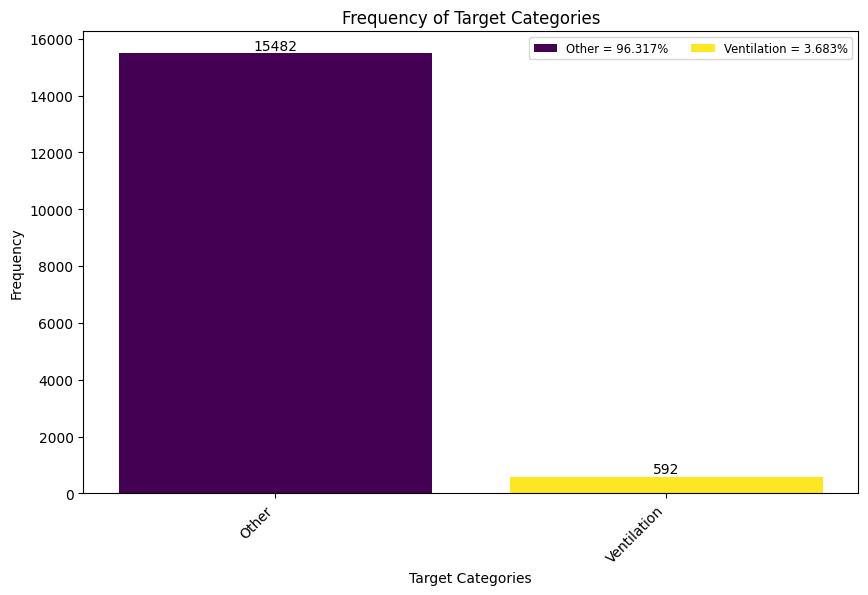

In [ ]:
# Calculate the counts for each target category.
target_counts = df_so_cleaned["target"].value_counts()

# Calculate the total number of samples.
total_samples = len(df_so_cleaned)

# Plotting the bar chart.
plt.figure(figsize=(10, 6))
bars = plt.bar(target_counts.index, target_counts, color=plt.cm.viridis(np.linspace(0, 1, len(target_counts))))
plt.title("Frequency of Target Categories")
plt.xlabel("Target Categories")
plt.ylabel("Frequency")
plt.xticks(rotation=45, ha='right')
plt.yticks(minor=True)

# Add counts on top of the bars.
for bar, count in zip(bars, target_counts):
    plt.text(bar.get_x() + bar.get_width() / 2, count + 1, str(count), ha='center', va='bottom')

# Calculate and format percentages for legend labels.
percentages = [(f"{category} = {count/total_samples*100:.3f}%") for category, count in target_counts.items()]

# Add legend with custom labels.
plt.legend(bars, percentages, loc='upper right', bbox_to_anchor=(1, 1), ncol=2, fontsize='small')
plt.show()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


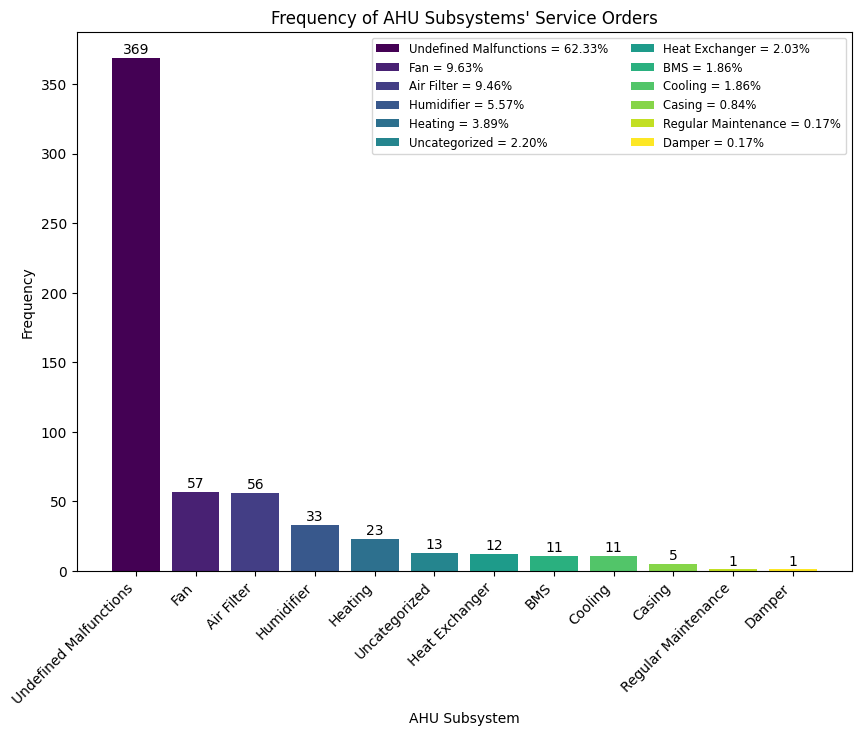

In [ ]:
# Calculate and print counts for each submodule category.
submodule_counts = df_so_cleaned_ventilation["submodule"].value_counts()
total_samples = len(df_so_cleaned_ventilation)

# Plotting the bar chart.
plt.figure(figsize=(10, 7))
bars = plt.bar(submodule_counts.index, submodule_counts, color=plt.cm.viridis(np.linspace(0, 1, len(submodule_counts))))
plt.title("Frequency of AHU Subsystems' Service Orders")
plt.xlabel("AHU Subsystem")
plt.ylabel("Frequency")
plt.xticks(rotation=45, ha='right')
plt.yticks(minor=True)

# Add counts on top of the bars.
for bar, count in zip(bars, submodule_counts):
    plt.text(bar.get_x() + bar.get_width() / 2, count + 1, str(count), ha='center', va='bottom')

# Calculate and format percentages for legend labels.
percentages = [(f"{category} = {count/total_samples*100:.2f}%") for category, count in submodule_counts.items()]

# Add legend with custom labels.
plt.legend(bars, percentages, loc='upper right', bbox_to_anchor=(1, 1), ncol=2, fontsize='small')
plt.savefig('/content/drive/MyDrive/Kropman/figures/Annotation (Classification)/ahu_component_categories.png', bbox_inches = 'tight')
plt.show()

# Visualization on SO_Omschrijving

## Air Filter

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


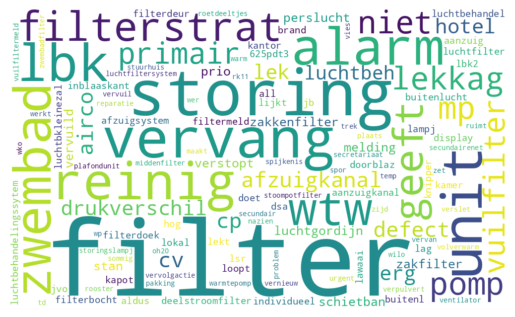

In [ ]:
# Extract service order descriptions related to the 'Air Filter' submodule from the cleaned ventilation DataFrame.
corpus_airFilter = df_so_cleaned_ventilation[df_so_cleaned_ventilation['submodule'] == 'Air Filter']['SO_Omschrijving'].tolist()

# Initialize CountVectorizer to create unigrams (1-grams).
vectorizer_airFilter = CountVectorizer(ngram_range=(1, 1))

# Fit the vectorizer on the air filter corpus and transform the text data into a document-term matrix (DTM).
dtm_airFilter = vectorizer_airFilter.fit_transform(corpus_airFilter)

# Get the feature names (unique terms) from the vectorizer.
terms_airFilter = vectorizer_airFilter.get_feature_names_out()

# Convert the DTM to a DataFrame for easier manipulation and analysis, using the terms as column names.
dtm_airFilter = pd.DataFrame(dtm_airFilter.toarray(), columns=terms_airFilter)

# Calculate the term frequencies by summing each column in the DTM.
term_frequencies_airFilter = dtm_airFilter.sum()

# Generate a word cloud from the term frequencies, specifying the desired size and background color.
wordcloud = WordCloud(width=1000, height=600, background_color='white').generate_from_frequencies(term_frequencies_airFilter)

# Display the word cloud image without axis labels for a cleaner look.
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')  # Hide axis.
# Save the word cloud image to the specified file path. Change the saving path in case of need!
plt.savefig('/content/drive/MyDrive/Kropman/figures/word_clouds/ahu/air_filter.png')

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Processing 87 combinations | Sampling itemset size 3
Number of transactions: 56
Minimum number of occurrence for each itemset: 3
Minimum support threshold for itemsets: 0.05357142857142857
Number of frequent itemsets: 26
Number of rules: 22


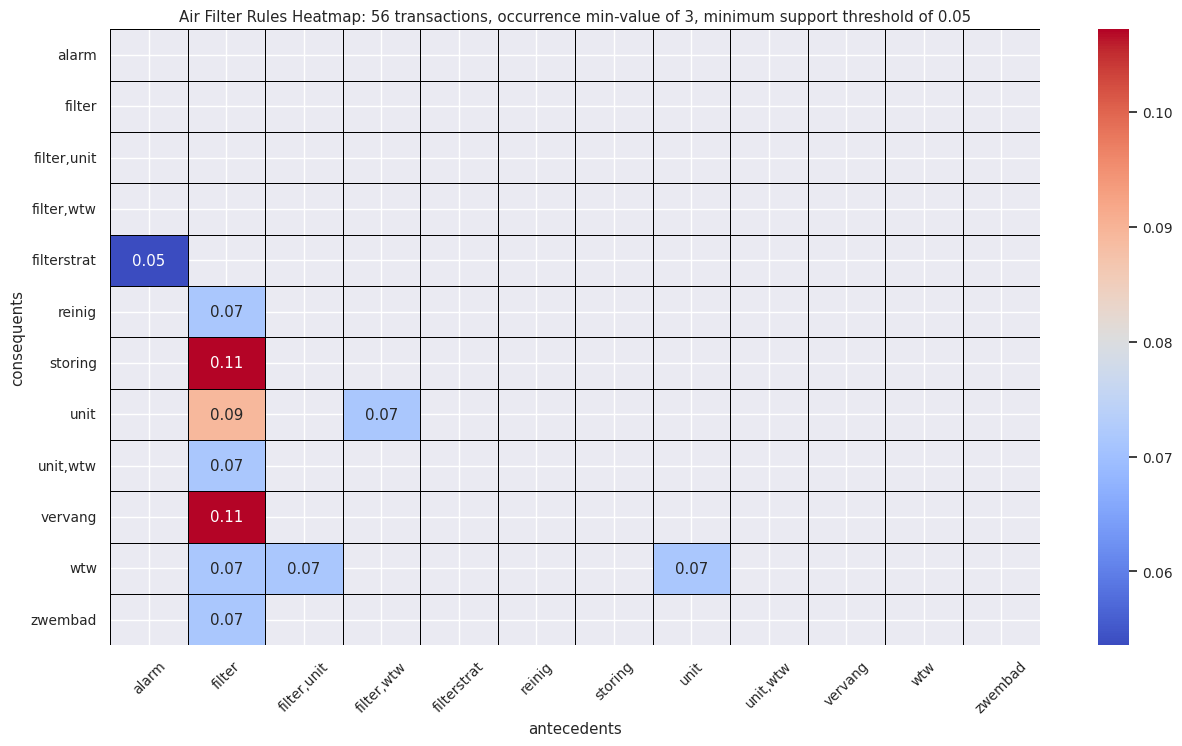

<Figure size 640x480 with 0 Axes>

In [ ]:
# Extract service order descriptions related to the 'Air Filter' submodule and split each description into individual words.
transactions_airFilter = df_so_cleaned_ventilation[df_so_cleaned_ventilation['submodule'] == 'Air Filter']['SO_Omschrijving'].apply(lambda t: t.split(' '))

# Convert the transactions to a list format.
transactions_airFilter = list(transactions_airFilter)

# Initialize the TransactionEncoder and fit it on the list of transactions.
encoder_airFilter = TransactionEncoder().fit(transactions_airFilter)

# Transform the transactions into a one-hot encoded format using the encoder.
onehot_airFilter = encoder_airFilter.transform(transactions_airFilter)

# Convert the one-hot encoded data into a DataFrame for easier manipulation and analysis, using the encoder's column names.
onehot_airFilter = pd.DataFrame(onehot_airFilter, columns=encoder_airFilter.columns_)

# Set the minimum occurrence threshold for itemsets.
n = 3
'''
Define the minimum number of occurrences for each itemset.
This indirectly acts as a hyperparamether, so tune it as you pefer.
Increase the value of "n" if you want to find more frequent itemsets.
Decrease the value of "n" if you want to find less frequent itemsets.
'''
# Calculate the minimum support threshold based on the total number of transactions.
minimum_support = n / len(onehot_airFilter)

# Apply the Apriori algorithm to find frequent itemsets in the one-hot encoded data with the specified minimum support.
frequent_itemsets_airFilter = apriori(onehot_airFilter,
                            min_support=minimum_support,
                            use_colnames=True,
                            verbose=1)

# Generate association rules from the frequent itemsets using 'lift' as the metric.
rules_airFilter = association_rules(frequent_itemsets_airFilter, metric='lift', min_threshold=1)

# Print out key information regarding the transactions and rules derived.
print(f'Number of transactions: {len(onehot_airFilter)}')
print(f'Minimum number of occurrence for each itemset: {n}')
print(f'Minimum support threshold for itemsets: {minimum_support}')
print(f'Number of frequent itemsets: {len(frequent_itemsets_airFilter)}')
print(f'Number of rules: {len(rules_airFilter)}')

# Replace frozen sets in the 'antecedents' and 'consequents' columns with string representations for easier readability.
rules_airFilter['antecedents'] = rules_airFilter['antecedents'].apply(lambda a: ','.join(list(a)))
rules_airFilter['consequents'] = rules_airFilter['consequents'].apply(lambda a: ','.join(list(a)))

# Transform the data into a pivot table format for heatmap visualization, indexing by consequents and columns by antecedents.
pivot = rules_airFilter.pivot(index='consequents', columns='antecedents', values='support')

# Create a mask to hide the upper triangle of the heatmap for better visual clarity.
mask = np.triu(np.ones_like(pivot, dtype=bool))

# Set the font scale for the seaborn heatmap.
sns.set(font_scale=0.9)

# Create a figure for the heatmap with specified dimensions.
plt.figure(figsize=(15, 8))  # Adjust width and height as needed.

# Generate the heatmap using seaborn, applying the mask, color map, and other visual settings.
heatmap = sns.heatmap(pivot, cmap='coolwarm', mask=mask, cbar=True, linewidths=0.5, linecolor='black', annot=True, fmt='.2f')

# Rotate the x-axis labels for better visibility.
plt.xticks(rotation=45)
# Set the title for the heatmap, including transaction count and thresholds.
plt.title(f'Air Filter Rules Heatmap: {len(onehot_airFilter)} transactions, occurrence min-value of {n}, minimum support threshold of {minimum_support:.2f}')
# Rotate the y-axis labels for better visibility.
plt.yticks(rotation=0)
# Display the heatmap.
plt.show()
# Save the generated heatmap image to the specified file path.
plt.savefig('/content/drive/MyDrive/Kropman/figures/heatmaps/ahu/air_filter.png')

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


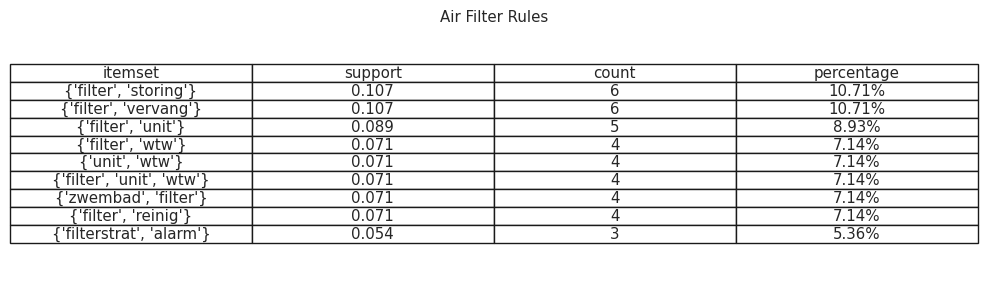

In [ ]:
# Sort the rules based on support in descending order to prioritize the most frequent itemsets.
rules_airFilter.sort_values(by='support', ascending=False, inplace=True)

# Create a new column 'itemset' that combines the antecedents and consequents into a single string representation.
rules_airFilter['itemset'] = rules_airFilter.apply(lambda row: f"{row['antecedents']},{row['consequents']}", axis=1)

# Calculate the count for each rule based on its support and the total number of transactions.
rules_airFilter['count'] = rules_airFilter.apply(lambda row: int(row['support'] * len(onehot_airFilter)), axis=1)

# Convert the string representation of the itemset back into a set for better data structure handling.
rules_airFilter['itemset'] = rules_airFilter['itemset'].apply(convert_str_to_set)

# Round the support values to three decimal places for cleaner display.
rules_airFilter['rounded_support'] = rules_airFilter.apply(lambda row: f"{row['support']:.3f}", axis=1)

# Calculate the percentage of occurrences for each itemset relative to the total number of transactions.
rules_airFilter['percentage'] = rules_airFilter.apply(lambda row: f"{row['count'] * 100 / len(onehot_airFilter):.2f}%", axis=1)

# Remove duplicate itemsets, keeping only the first occurrence to avoid redundancy in the final output.
rules_airFilter.drop_duplicates(subset=['itemset'], keep='first', inplace=True)

# Reset the index of the DataFrame for tidy representation.
rules_airFilter.reset_index(inplace=True)

# Select relevant columns to display in the final output.
rules_airFilter[['itemset', 'support', 'count', 'percentage']]

# Create a figure for displaying the results in a table format.
fig, ax = plt.subplots(figsize=(10, 3))
ax.axis('tight')  # Fit the axes tightly around the table.
ax.axis('off')    # Hide the axes for a cleaner appearance.

# Create a table in the plot using the selected columns from the rules DataFrame.
ax.table(cellText=rules_airFilter[['itemset', 'rounded_support', 'count', 'percentage']].values,
         colLabels=rules_airFilter[['itemset', 'support', 'count', 'percentage']].columns,
         cellLoc='center', loc='center', fontsize=12)

# Set the title for the table figure.
plt.title('Air Filter Rules')

# Adjust the layout for optimal display.
plt.tight_layout()

# Save the generated table image to the specified file path.
plt.savefig('/content/drive/MyDrive/Kropman/figures/tables/ahu/air_filter.png')

# Display the table.
plt.show()

## Fan

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


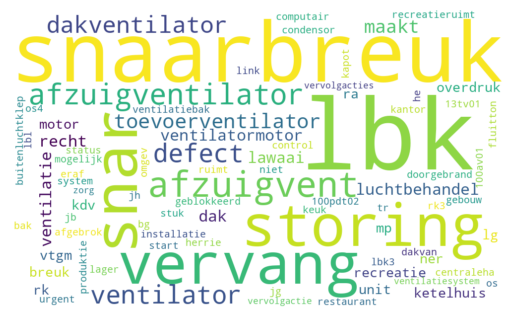

In [ ]:
# Extract the service order descriptions related to the 'Fan' submodule from the cleaned ventilation DataFrame.
corpus_fan = df_so_cleaned_ventilation[df_so_cleaned_ventilation['submodule'] == 'Fan']['SO_Omschrijving'].tolist()

# Initialize the CountVectorizer to create a bag-of-words model; ngram_range=(1, 1) means we are using single words (unigrams).
vectorizer_fan = CountVectorizer(ngram_range=(1, 1))

# Fit the CountVectorizer on the corpus and transform it into a Document-Term Matrix (DTM).
dtm_fan = vectorizer_fan.fit_transform(corpus_fan)

# Retrieve the feature names (terms) from the vectorizer.
terms_fan = vectorizer_fan.get_feature_names_out()

# Convert the sparse matrix representation of the DTM to a dense format and create a DataFrame for easier manipulation.
dtm_fan = pd.DataFrame(dtm_fan.toarray(), columns=terms_fan)

# Sum the term frequencies across all documents in the DTM.
term_frequencies_fan = dtm_fan.sum()

# Generate a word cloud from the term frequencies, setting the image size and background color.
wordcloud = WordCloud(width=1000, height=600, background_color='white').generate_from_frequencies(term_frequencies_fan)

# Optionally set the title for the word cloud figure (currently commented out).
# plt.title('Fan Word Cloud')

# Create a figure to display the word cloud, adjusting the size for better visibility.
# plt.figure(figsize=(10, 5))

# Display the word cloud image.
plt.imshow(wordcloud, interpolation='bilinear')

# Hide the axes for a cleaner appearance of the word cloud.
plt.axis('off')

# Save the generated word cloud image to the specified file path.
plt.savefig('/content/drive/MyDrive/Kropman/figures/word_clouds/ahu/fan.png')

# Show the word cloud plot.
plt.show()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Processing 16 combinations | Sampling itemset size 4
Number of transactions: 57
Minimum number of occurrences for each itemset: 3
Minimum support threshold for itemsets: 0.05263157894736842
Number of frequent itemsets: 36
Number of rules: 44


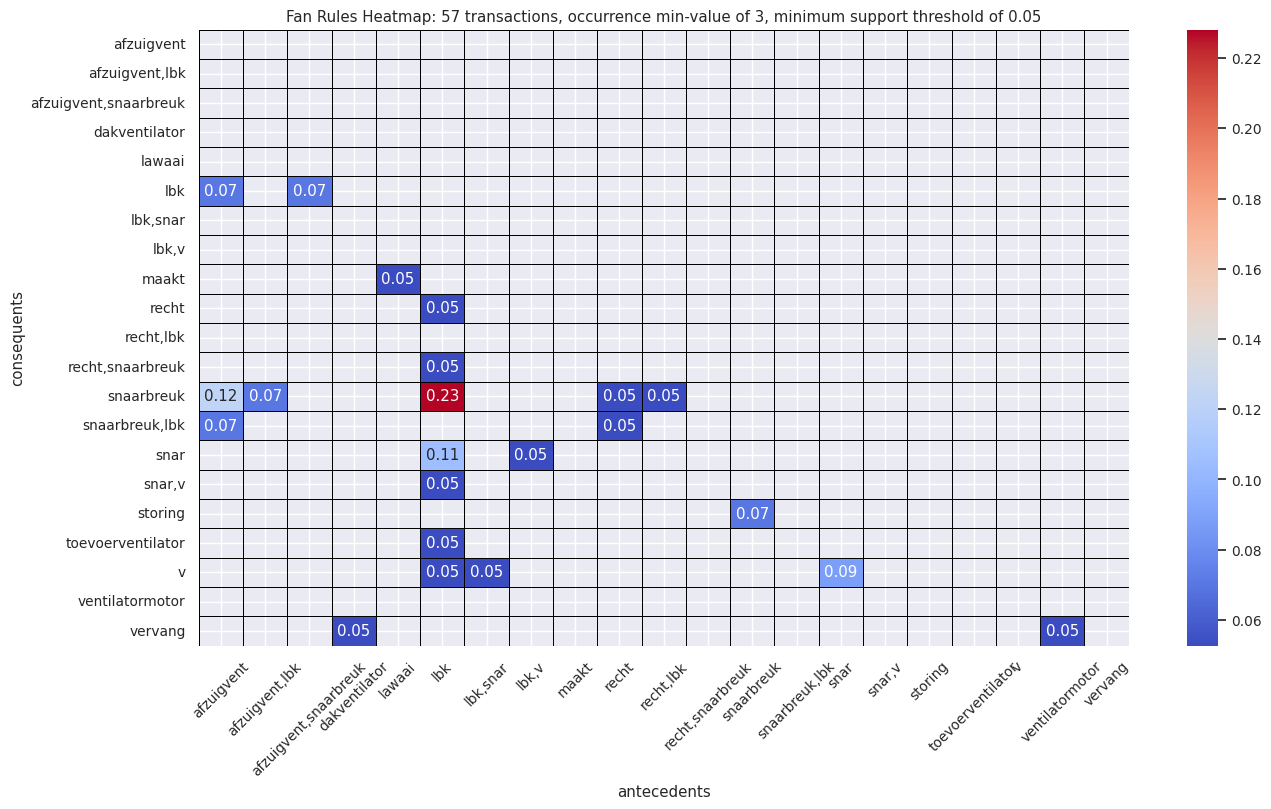

In [ ]:
# Extract service order descriptions related to the 'Fan' submodule from the cleaned ventilation DataFrame and split the text into individual words.
transactions_fan = df_so_cleaned_ventilation[df_so_cleaned_ventilation['submodule'] == 'Fan']['SO_Omschrijving'].apply(lambda t: t.split(' '))

# Convert the resulting Series of lists into a list of transactions.
transactions_fan = list(transactions_fan)

# Initialize the TransactionEncoder to encode the list of transactions into a one-hot encoded format.
encoder_fan = TransactionEncoder().fit(transactions_fan)

# Transform the transactions into a one-hot encoded DataFrame format.
onehot_fan = encoder_fan.transform(transactions_fan)

# Create a DataFrame from the one-hot encoded data, using the encoder's column names.
onehot_fan = pd.DataFrame(onehot_fan, columns=encoder_fan.columns_)

# Set the minimum occurrence threshold for itemsets.
'''
Define the minimum number of occurrences for each itemset.
This indirectly acts as a hyperparamether, so tune it as you pefer.
Increase the value of "n" if you want to find more frequent itemsets.
Decrease the value of "n" if you want to find less frequent itemsets.
'''
n = 3

# Calculate the minimum support threshold based on the total number of transactions.
minimum_support = n / len(onehot_fan)

# Apply the Apriori algorithm to find frequent itemsets in the one-hot encoded DataFrame.
frequent_itemsets_fan = apriori(onehot_fan,
                            min_support=minimum_support,
                            use_colnames=True,
                            verbose=1)

# Generate association rules from the frequent itemsets, using 'lift' as the evaluation metric.
rules_fan = association_rules(frequent_itemsets_fan, metric='lift', min_threshold=1)

# Print summary information about the transactions and rules generated.
print(f'Number of transactions: {len(onehot_fan)}')  # Total number of transactions
print(f'Minimum number of occurrences for each itemset: {n}')  # Minimum itemset count
print(f'Minimum support threshold for itemsets: {minimum_support}')  # Minimum support threshold
print(f'Number of frequent itemsets: {len(frequent_itemsets_fan)}')  # Total number of frequent itemsets
print(f'Number of rules: {len(rules_fan)}')  # Total number of association rules

# Replace frozen sets in the rules with string representations for easier interpretation.
rules_fan['antecedents'] = rules_fan['antecedents'].apply(lambda a: ','.join(list(a)))
rules_fan['consequents'] = rules_fan['consequents'].apply(lambda a: ','.join(list(a)))

# Transform the rules DataFrame into a pivot table format for heatmap generation.
pivot = rules_fan.pivot(index='consequents', columns='antecedents', values='support')

# Create a mask to display only the lower triangle of the heatmap.
mask = np.triu(np.ones_like(pivot, dtype=bool))

# Set the font scale for the seaborn heatmap.
sns.set(font_scale=0.9)

# Create a new figure for the heatmap, adjusting the size for clarity.
plt.figure(figsize=(15, 8))

# Generate the heatmap using the pivot table, with color map and annotations.
heatmap = sns.heatmap(pivot, cmap='coolwarm', mask=mask, cbar=True, linewidths=0.5, linecolor='black', annot=True, fmt='.2f')

# Rotate x-axis tick labels for better readability.
plt.xticks(rotation=45)

# Set the title for the heatmap, including relevant details about transactions and thresholds.
plt.title(f'Fan Rules Heatmap: {len(onehot_fan)} transactions, occurrence min-value of {n}, minimum support threshold of {minimum_support:.2f}')

# Rotate y-axis tick labels for better readability.
plt.yticks(rotation=0)

# Save the generated heatmap image to the specified file path.
plt.savefig('/content/drive/MyDrive/Kropman/figures/heatmaps/ahu/fan.png')

# Show the generated heatmap plot.
plt.show()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


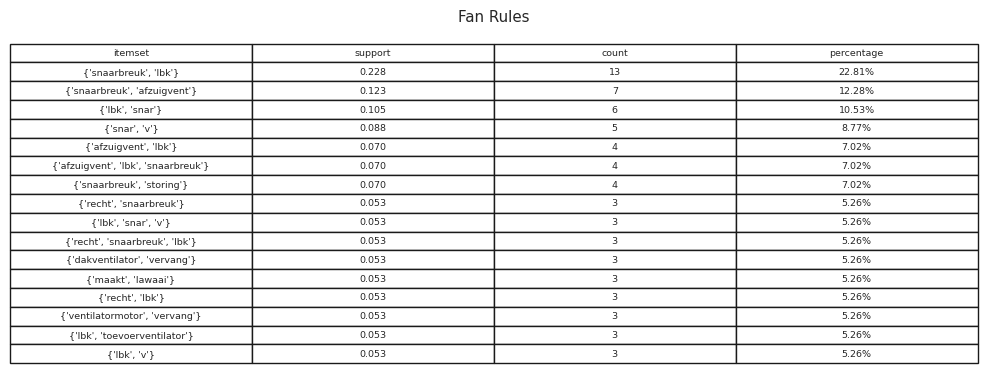

In [ ]:
# Sort the rules based on support in descending order for better visualization of the most frequent itemsets.
rules_fan.sort_values(by='support', ascending=False, inplace=True)

# Create a new 'itemset' column by concatenating the 'antecedents' and 'consequents' columns.
rules_fan['itemset'] = rules_fan.apply(lambda row: f"{row['antecedents']},{row['consequents']}", axis=1)

# Calculate the count of occurrences for each rule by multiplying the support by the total number of transactions.
rules_fan['count'] = rules_fan.apply(lambda row: int(row['support'] * len(onehot_fan)), axis=1)

# Convert the 'itemset' strings into sets for easier manipulation and analysis.
rules_fan['itemset'] = rules_fan['itemset'].apply(convert_str_to_set)

# Round the support values to three decimal places for clearer presentation.
rules_fan['rounded_support'] = rules_fan.apply(lambda row: f"{row['support']:.3f}", axis=1)

# Calculate the percentage representation of each rule's count relative to the total number of transactions.
rules_fan['percentage'] = rules_fan.apply(lambda row: f"{row['count'] * 100 / len(onehot_fan):.2f}%", axis=1)

# Remove duplicate itemsets, keeping only the first occurrence to avoid redundancy.
rules_fan.drop_duplicates(subset=['itemset'], keep='first', inplace=True)

# Reset the index of the DataFrame after dropping duplicates for better readability and organization.
rules_fan.reset_index(inplace=True)

# Select the relevant columns for display.
rules_fan[['itemset', 'support', 'count', 'percentage']]

# Create a figure for the table visualization.
fig, ax = plt.subplots(figsize=(10, 4))

# Set the axes to be tight and turn off the axis display for a cleaner look.
ax.axis('tight')
ax.axis('off')

# Create a table using the selected columns from the rules DataFrame.
ax.table(cellText=rules_fan[['itemset', 'rounded_support', 'count', 'percentage']].values,
         colLabels=rules_fan[['itemset', 'support', 'count', 'percentage']].columns,
         cellLoc='center', loc='center', fontsize=12)

# Set the title for the table visualization.
plt.title('Fan Rules')

# Adjust the layout to prevent overlap and ensure everything fits nicely.
plt.tight_layout()

# Save the generated table image to the specified file path.
plt.savefig('/content/drive/MyDrive/Kropman/figures/tables/ahu/fan.png')

# Display the generated table plot.
plt.show()

##  Regular Maintenance

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


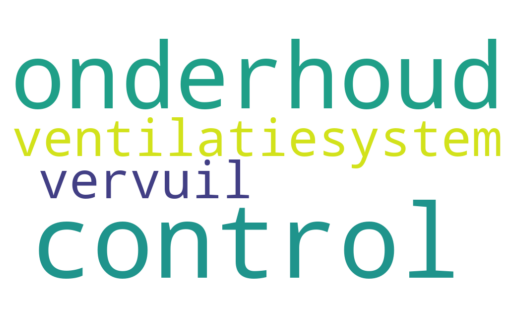

In [ ]:
# Extract the descriptions of service orders related to 'Regular Maintenance' in the ventilation subsystem.
corpus_regularMaintenance = df_so_cleaned_ventilation[df_so_cleaned_ventilation['submodule'] == 'Regular Maintenance']['SO_Omschrijving'].tolist()

# Initialize the CountVectorizer to create a document-term matrix with unigrams (1-grams).
vectorizer_regularMaintenance = CountVectorizer(ngram_range=(1, 1))

# Fit the vectorizer on the corpus and transform the text data into a document-term matrix (DTM).
dtm_regularMaintenance = vectorizer_regularMaintenance.fit_transform(corpus_regularMaintenance)

# Retrieve the feature names (unique terms) from the vectorizer.
terms_regularMaintenance = vectorizer_regularMaintenance.get_feature_names_out()

# Convert the DTM to a DataFrame for easier manipulation and analysis.
dtm_regularMaintenance = pd.DataFrame(dtm_regularMaintenance.toarray(), columns=terms_regularMaintenance)

# Sum the occurrences of each term to get term frequencies.
term_frequencies_regularMaintenance = dtm_regularMaintenance.sum()

# Generate a word cloud image based on the term frequencies, with specified dimensions and background color.
wordcloud = WordCloud(width=1000, height=600, background_color='white').generate_from_frequencies(term_frequencies_regularMaintenance)

# The following two lines are commented out. They can be used to set the title and size for displaying the word cloud.
# plt.title('Regular Maintenance Word Cloud')
# plt.figure(figsize=(10, 5))

# Display the word cloud image.
plt.imshow(wordcloud, interpolation='bilinear')

# Turn off the axis for a cleaner visualization.
plt.axis('off')

# Save the generated word cloud image to the specified file path.
plt.savefig('/content/drive/MyDrive/Kropman/figures/word_clouds/ahu/regular_maintenance.png')

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Processing 4 combinations | Sampling itemset size 4
Number of transactions: 1
Minimum number of occurrence for each itemset: 1
Minimum support threshold for itemsets: 1.0
Number of frequent itemsets: 15
Number of rules: 50


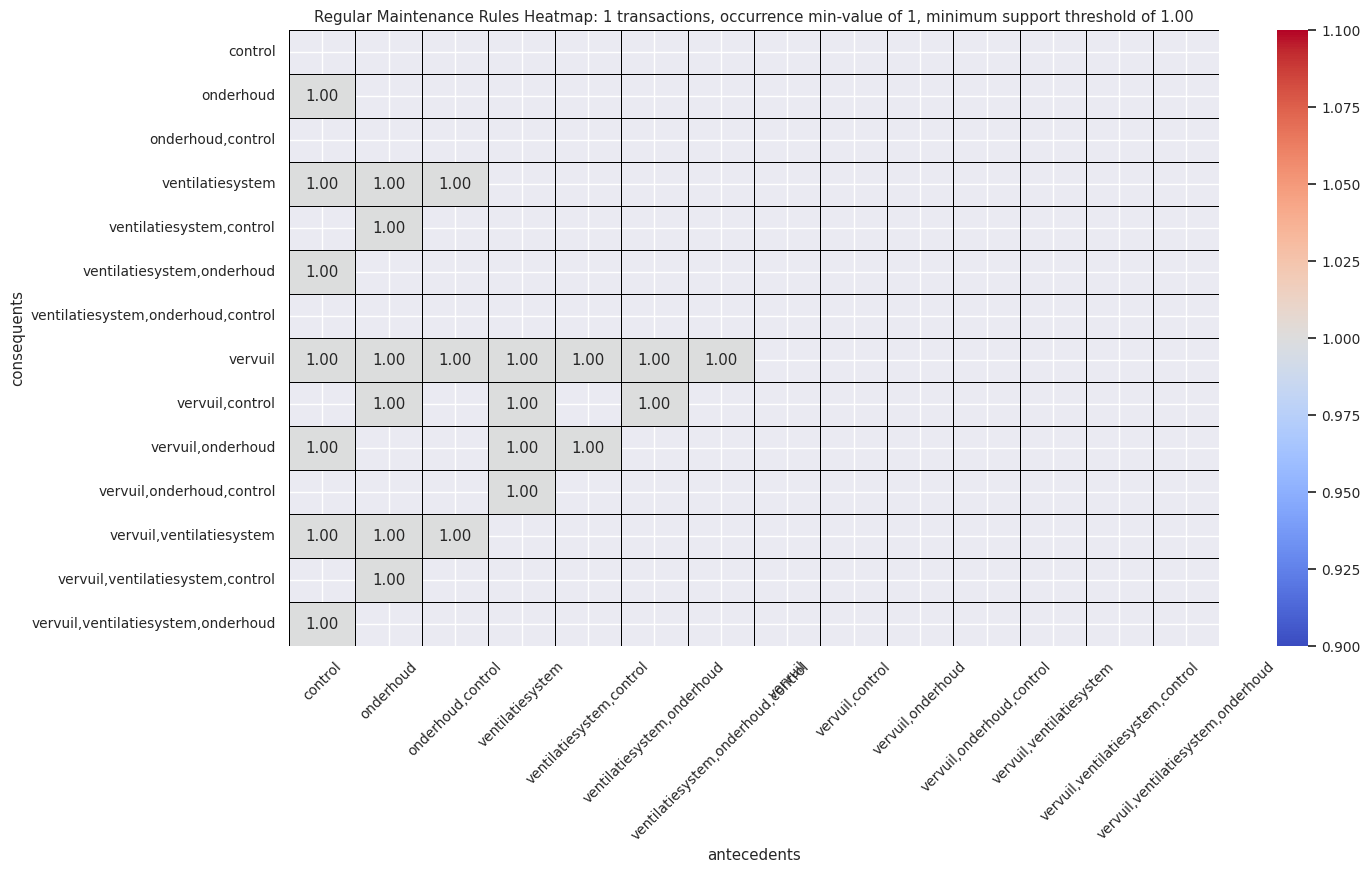

In [ ]:
# Extract the descriptions of service orders related to 'Regular Maintenance' in the ventilation subsystem,
# splitting each description into a list of words (tokens).
transactions_regularMaintenance = df_so_cleaned_ventilation[df_so_cleaned_ventilation['submodule'] == 'Regular Maintenance']['SO_Omschrijving'].apply(lambda t: t.split(' '))

# Convert the series of transactions into a list for further processing.
transactions_regularMaintenance = list(transactions_regularMaintenance)

# Initialize the TransactionEncoder to prepare the data for one-hot encoding.
encoder_regularMaintenance = TransactionEncoder().fit(transactions_regularMaintenance)

# Transform the list of transactions into a one-hot encoded format.
onehot_regularMaintenance = encoder_regularMaintenance.transform(transactions_regularMaintenance)

# Convert the one-hot encoded data into a DataFrame for easier analysis and manipulation.
onehot_regularMaintenance = pd.DataFrame(onehot_regularMaintenance, columns=encoder_regularMaintenance.columns_)

# Set the minimum occurrence threshold for itemsets.
'''
Define the minimum number of occurrences for each itemset.
This indirectly acts as a hyperparamether, so tune it as you pefer.
Increase the value of "n" if you want to find more frequent itemsets.
Decrease the value of "n" if you want to find less frequent itemsets.
'''
n = 1

# Calculate the minimum support threshold based on the number of transactions.
minimum_support = n / len(onehot_regularMaintenance)

# Apply the apriori algorithm to find frequent itemsets in the one-hot encoded data,
# using the minimum support threshold.
frequent_itemsets_regularMaintenance = apriori(onehot_regularMaintenance,
                            min_support=minimum_support,
                            use_colnames=True,
                            verbose=1)

# Generate association rules from the frequent itemsets, using lift as the evaluation metric.
rules_regularMaintenance = association_rules(frequent_itemsets_regularMaintenance, metric='lift', min_threshold=1)

# Print the analysis results for debugging and information.
print(f'Number of transactions: {len(onehot_regularMaintenance)}')  # Total transactions
print(f'Minimum number of occurrence for each itemset: {n}')  # Minimum occurrence
print(f'Minimum support threshold for itemsets: {minimum_support}')  # Minimum support threshold
print(f'Number of frequent itemsets: {len(frequent_itemsets_regularMaintenance)}')  # Frequent itemsets count
print(f'Number of rules: {len(rules_regularMaintenance)}')  # Total rules generated

# Replace frozen sets in the antecedents with strings for better readability.
rules_regularMaintenance['antecedents'] = rules_regularMaintenance['antecedents'].apply(lambda a: ','.join(list(a)))

# Similarly, replace frozen sets in the consequents with strings.
rules_regularMaintenance['consequents'] = rules_regularMaintenance['consequents'].apply(lambda a: ','.join(list(a)))

# Transform the rules data into a matrix format suitable for heatmap visualization.
pivot = rules_regularMaintenance.pivot(index='consequents', columns='antecedents', values='support')

# Create a mask for the upper triangle of the heatmap to enhance visualization.
mask = np.triu(np.ones_like(pivot, dtype=bool))

# Set the font scale for the seaborn plots.
sns.set(font_scale=0.9)  # Adjust the font size as needed

# Create a figure for the heatmap with specified dimensions.
plt.figure(figsize=(15, 8))  # Adjust width and height as needed

# Generate the heatmap for the association rules.
heatmap = sns.heatmap(pivot, cmap='coolwarm', mask=mask, cbar=True, linewidths=0.5, linecolor='black', annot=True, fmt='.2f')

# Rotate the x-ticks for better visibility.
plt.xticks(rotation=45)

# Set the title of the heatmap with dynamic values for transactions and thresholds.
plt.title(f'Regular Maintenance Rules Heatmap: {len(onehot_regularMaintenance)} transactions, occurrence min-value of {n}, minimum support threshold of {minimum_support:.2f}')

# Rotate the y-ticks for better visibility.
plt.yticks(rotation=0)

# Save the generated heatmap image to the specified file path.
plt.savefig('/content/drive/MyDrive/Kropman/figures/heatmaps/ahu/regular_maintenance.png')

# Display the heatmap.
plt.show()


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


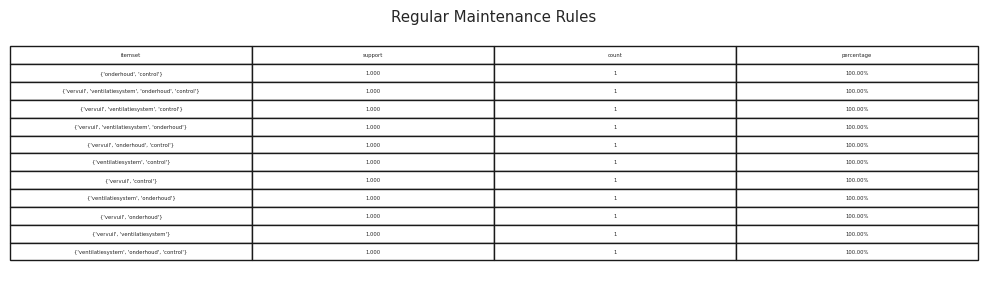

In [ ]:
# Sort the rules by support in descending order to prioritize higher support values.
rules_regularMaintenance.sort_values(by='support', ascending=False, inplace=True)

# Create a new column 'itemset' that combines the antecedents and consequents into a single string representation.
rules_regularMaintenance['itemset'] = rules_regularMaintenance.apply(lambda row: f"{row['antecedents']},{row['consequents']}", axis=1)

# Calculate the count of occurrences for each rule based on the support and total number of transactions.
rules_regularMaintenance['count'] = rules_regularMaintenance.apply(lambda row: int(row['support'] * len(onehot_regularMaintenance)), axis=1)

# Convert the 'itemset' strings into sets for easier analysis and comparison.
rules_regularMaintenance['itemset'] = rules_regularMaintenance['itemset'].apply(convert_str_to_set)

# Round the support values to three decimal places for better readability.
rules_regularMaintenance['rounded_support'] = rules_regularMaintenance.apply(lambda row: f"{row['support']:.3f}", axis=1)

# Calculate the percentage representation of each count relative to the total number of transactions.
rules_regularMaintenance['percentage'] = rules_regularMaintenance.apply(lambda row: f"{row['count'] * 100 / len(onehot_regularMaintenance):.2f}%", axis=1)

# Remove duplicate itemsets, keeping only the first occurrence to ensure unique rules.
rules_regularMaintenance.drop_duplicates(subset=['itemset'], keep='first', inplace=True)

# Reset the index of the DataFrame for cleaner output after modifications.
rules_regularMaintenance.reset_index(inplace=True)

# Display the relevant columns for inspection.
rules_regularMaintenance[['itemset', 'support', 'count', 'percentage']]

# Create a figure for the table display with specified dimensions.
fig, ax = plt.subplots(figsize=(10, 3))

# Set axes to tight and turn off the axes for a cleaner table display.
ax.axis('tight')
ax.axis('off')

# Generate a table with the specified columns and format it for better visibility.
ax.table(cellText=rules_regularMaintenance[['itemset', 'rounded_support', 'count', 'percentage']].values,
         colLabels=rules_regularMaintenance[['itemset', 'support', 'count', 'percentage']].columns,
         cellLoc='center', loc='center', fontsize=12)

# Set the title of the table for clarity.
plt.title('Regular Maintenance Rules')

# Adjust the layout to fit everything neatly in the figure.
plt.tight_layout()

# Save the generated table image to the specified file path.
plt.savefig('/content/drive/MyDrive/Kropman/figures/tables/ahu/regular_maintenance.png')

# Display the table.
plt.show()

## BMS

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


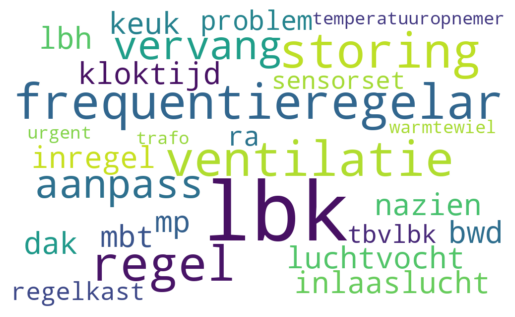

In [ ]:
# Extract descriptions of service orders related to the BMS (Building Management System) submodule.
corpus_bms = df_so_cleaned_ventilation[df_so_cleaned_ventilation['submodule'] == 'BMS']['SO_Omschrijving'].tolist()

# Initialize CountVectorizer to convert text data into a matrix of token counts (1-grams).
vectorizer_bms = CountVectorizer(ngram_range=(1, 1))

# Fit the vectorizer to the BMS corpus and transform the text into a Document-Term Matrix (DTM).
dtm_bms = vectorizer_bms.fit_transform(corpus_bms)

# Get the feature names (terms) from the vectorizer.
terms_bms = vectorizer_bms.get_feature_names_out()

# Create a DataFrame from the DTM, using the terms as column names.
dtm_bms = pd.DataFrame(dtm_bms.toarray(), columns=terms_bms)

# Sum the occurrences of each term to get the term frequencies.
term_frequencies_bms = dtm_bms.sum()

# Generate a word cloud image based on the term frequencies.
wordcloud = WordCloud(width=1000, height=600, background_color='white').generate_from_frequencies(term_frequencies_bms)

# Optional: Set title and size for the figure if displaying the word cloud.
# plt.title('BMS Word Cloud')
# plt.figure(figsize=(10, 5))

# Display the generated word cloud image.
plt.imshow(wordcloud, interpolation='bilinear')

# Hide the axes for a cleaner look.
plt.axis('off')

# Save the word cloud image to the specified file path.
plt.savefig('/content/drive/MyDrive/Kropman/figures/word_clouds/ahu/bms.png')

# Show the word cloud on the screen.
plt.show()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Processing 15 combinations | Sampling itemset size 3
Number of transactions: 11
Minimum number of occurrences for each itemset: 2
Minimum support threshold for itemsets: 0.18181818181818182
Number of frequent itemsets: 10
Number of rules: 6


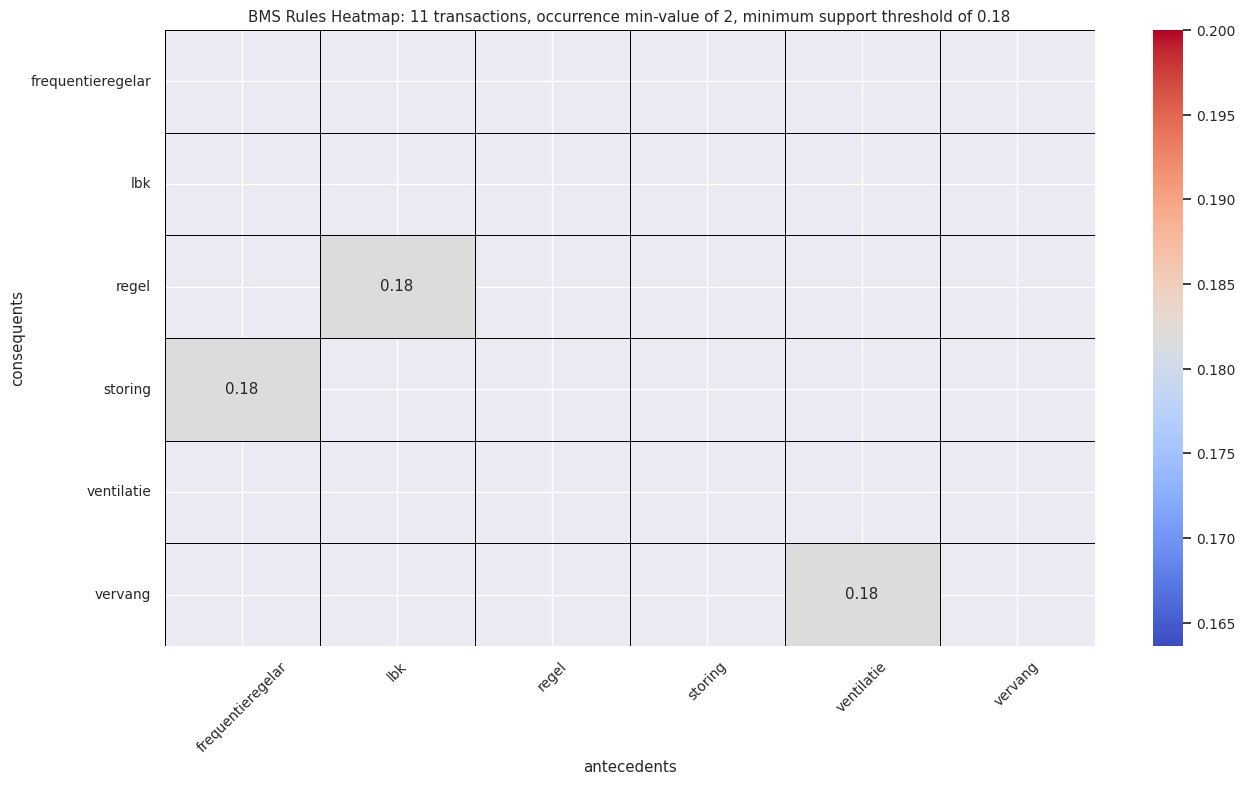

In [ ]:
# Extract service order descriptions related to the BMS (Building Management System) submodule.
transactions_bms = df_so_cleaned_ventilation[df_so_cleaned_ventilation['submodule'] == 'BMS']['SO_Omschrijving'].apply(lambda t: t.split(' '))

# Convert the transactions series into a list of transactions.
transactions_bms = list(transactions_bms)

# Initialize the TransactionEncoder, which is used to convert transactions into a one-hot encoded format.
encoder_bms = TransactionEncoder().fit(transactions_bms)

# Transform the transactions into a one-hot encoded DataFrame.
onehot_bms = encoder_bms.transform(transactions_bms)

# Create a DataFrame from the one-hot encoded data, using the encoder's column names.
onehot_bms = pd.DataFrame(onehot_bms, columns=encoder_bms.columns_)

# Set the minimum number of occurrences required for each itemset.
'''
Define the minimum number of occurrences for each itemset.
This indirectly acts as a hyperparamether, so tune it as you pefer.
Increase the value of "n" if you want to find more frequent itemsets.
Decrease the value of "n" if you want to find less frequent itemsets.
'''
n = 2

# Calculate the minimum support threshold based on the total number of transactions.
minimum_support = n / len(onehot_bms)

# Apply the Apriori algorithm to find frequent itemsets with the specified minimum support.
frequent_itemsets_bms = apriori(onehot_bms,
                                 min_support=minimum_support,
                                 use_colnames=True,
                                 verbose=1)

# Generate association rules from the frequent itemsets using the lift metric.
rules_bms = association_rules(frequent_itemsets_bms, metric='lift', min_threshold=1)

# Print key metrics about the transaction data and association rules generated.
print(f'Number of transactions: {len(onehot_bms)}')
print(f'Minimum number of occurrences for each itemset: {n}')
print(f'Minimum support threshold for itemsets: {minimum_support}')
print(f'Number of frequent itemsets: {len(frequent_itemsets_bms)}')
print(f'Number of rules: {len(rules_bms)}')

# Replace the frozen sets in the 'antecedents' and 'consequents' columns with string representations.
rules_bms['antecedents'] = rules_bms['antecedents'].apply(lambda a: ','.join(list(a)))
rules_bms['consequents'] = rules_bms['consequents'].apply(lambda a: ','.join(list(a)))

# Transform the rules data into a pivot format suitable for creating a heatmap.
pivot = rules_bms.pivot(index='consequents', columns='antecedents', values='support')

# Create a mask to only show the lower triangle of the heatmap.
mask = np.triu(np.ones_like(pivot, dtype=bool))

# Set font size for the heatmap visualization.
sns.set(font_scale=0.9)

# Create a figure for the heatmap with specified dimensions.
plt.figure(figsize=(15, 8))

# Generate the heatmap using seaborn, customizing the color palette and annotations.
heatmap = sns.heatmap(pivot, cmap='coolwarm', cbar=True, linewidths=0.5, linecolor='black', mask=mask, annot=True, fmt='.2f')

# Rotate x-axis labels for better readability.
plt.xticks(rotation=45)

# Set the title for the heatmap, including transaction and threshold information.
plt.title(f'BMS Rules Heatmap: {len(onehot_bms)} transactions, occurrence min-value of {n}, minimum support threshold of {minimum_support:.2f}')

# Rotate y-axis labels for better readability.
plt.yticks(rotation=0)

# Save the heatmap figure to the specified file path.
plt.savefig('/content/drive/MyDrive/Kropman/figures/heatmaps/ahu/bms.png')

# Display the heatmap on the screen.
plt.show()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


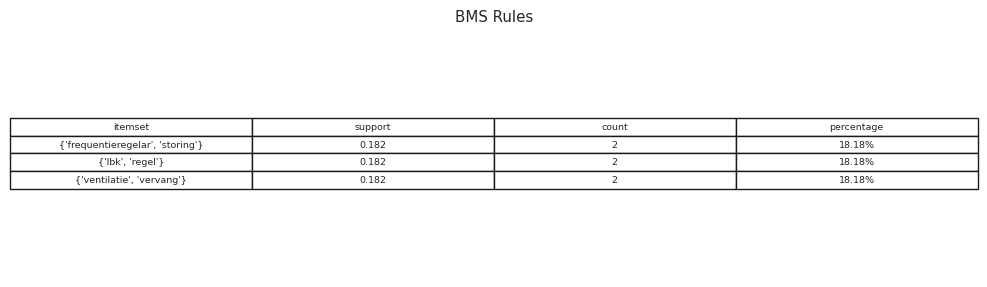

In [ ]:
# Sort the rules by support in descending order to prioritize the strongest associations.
rules_bms.sort_values(by='support', ascending=False, inplace=True)

# Create a new column 'itemset' that combines the 'antecedents' and 'consequents' into a single string representation.
rules_bms['itemset'] = rules_bms.apply(lambda row: f"{row['antecedents']},{row['consequents']}", axis=1)

# Calculate the count of occurrences for each itemset based on its support and the total number of transactions.
rules_bms['count'] = rules_bms.apply(lambda row: int(row['support'] * len(onehot_bms)), axis=1)

# Convert the 'itemset' strings back into sets for consistency and further analysis.
rules_bms['itemset'] = rules_bms['itemset'].apply(convert_str_to_set)

# Round the support values to three decimal places for cleaner presentation.
rules_bms['rounded_support'] = rules_bms.apply(lambda row: f"{row['support']:.3f}", axis=1)

# Calculate the percentage of occurrences for each itemset relative to the total number of transactions.
rules_bms['percentage'] = rules_bms.apply(lambda row: f"{row['count'] * 100 / len(onehot_bms):.2f}%", axis=1)

# Remove duplicate itemsets, keeping only the first occurrence.
rules_bms.drop_duplicates(subset=['itemset'], keep='first', inplace=True)

# Reset the index of the DataFrame after filtering duplicates.
rules_bms.reset_index(inplace=True)

# Display the relevant columns for the itemsets, support, count, and percentage.
rules_bms[['itemset', 'support', 'count', 'percentage']]

# Create a figure for displaying the rules in table format.
fig, ax = plt.subplots(figsize=(10, 3))

# Set the axes to tight layout and turn off axis display since this is a table.
ax.axis('tight')
ax.axis('off')

# Create a table with the specified columns from the rules_bms DataFrame.
ax.table(cellText=rules_bms[['itemset', 'rounded_support', 'count', 'percentage']].values,
         colLabels=rules_bms[['itemset', 'support', 'count', 'percentage']].columns,
         cellLoc='center', loc='center', fontsize=12)

# Set the title for the table visualization.
plt.title('BMS Rules')

# Adjust layout to prevent overlapping of elements.
plt.tight_layout()

# Save the figure to the specified file path for later use.
plt.savefig('/content/drive/MyDrive/Kropman/figures/tables/ahu/bms.png')

# Display the table on the screen.
plt.show()

## Heating

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


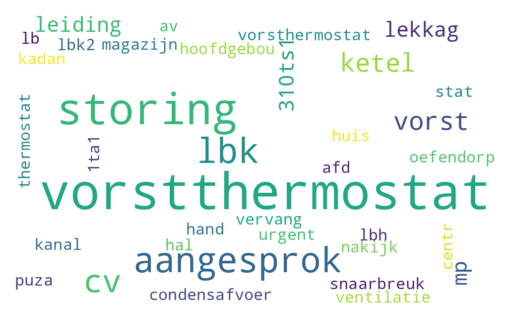

In [ ]:
# Extract the service order descriptions related to the 'Heating' submodule into a list.
corpus_heating = df_so_cleaned_ventilation[df_so_cleaned_ventilation['submodule'] == 'Heating']['SO_Omschrijving'].tolist()

# Initialize the CountVectorizer to convert the text data into a matrix of token counts (unigrams).
vectorizer_heating = CountVectorizer(ngram_range=(1, 1))

# Fit the CountVectorizer on the corpus and transform the data into a Document-Term Matrix (DTM).
dtm_heating = vectorizer_heating.fit_transform(corpus_heating)

# Get the feature names (terms) from the vectorizer.
terms_heating = vectorizer_heating.get_feature_names_out()

# Convert the sparse matrix to a DataFrame for easier manipulation and analysis.
dtm_heating = pd.DataFrame(dtm_heating.toarray(), columns=terms_heating)

# Sum the occurrences of each term to get the term frequencies.
term_frequencies_heating = dtm_heating.sum()

# Generate a word cloud image from the term frequencies, customizing the appearance.
wordcloud = WordCloud(width=1000, height=600, background_color='white').generate_from_frequencies(term_frequencies_heating)

# Uncomment the next line to set a title for the word cloud visualization (if desired).
# plt.title('Heating-Sub Word Cloud')

# Create a figure for displaying the word cloud.
# Uncomment the next line to specify the size of the figure (if desired).
# plt.figure(figsize=(10, 5))

# Display the generated word cloud image using bilinear interpolation for smooth rendering.
plt.imshow(wordcloud, interpolation='bilinear')

# Turn off the axis display for a cleaner look.
plt.axis('off')

# Save the word cloud image to the specified file path for later use.
plt.savefig('/content/drive/MyDrive/Kropman/figures/word_clouds/ahu/heating.png')

# Display the word cloud on the screen.
plt.show()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Processing 12 combinations | Sampling itemset size 4
Number of transactions: 23
Minimum number of occurrence for each itemset: 2
Minimum support threshold for itemsets: 0.08695652173913043
Number of frequent itemsets: 30
Number of rules: 64


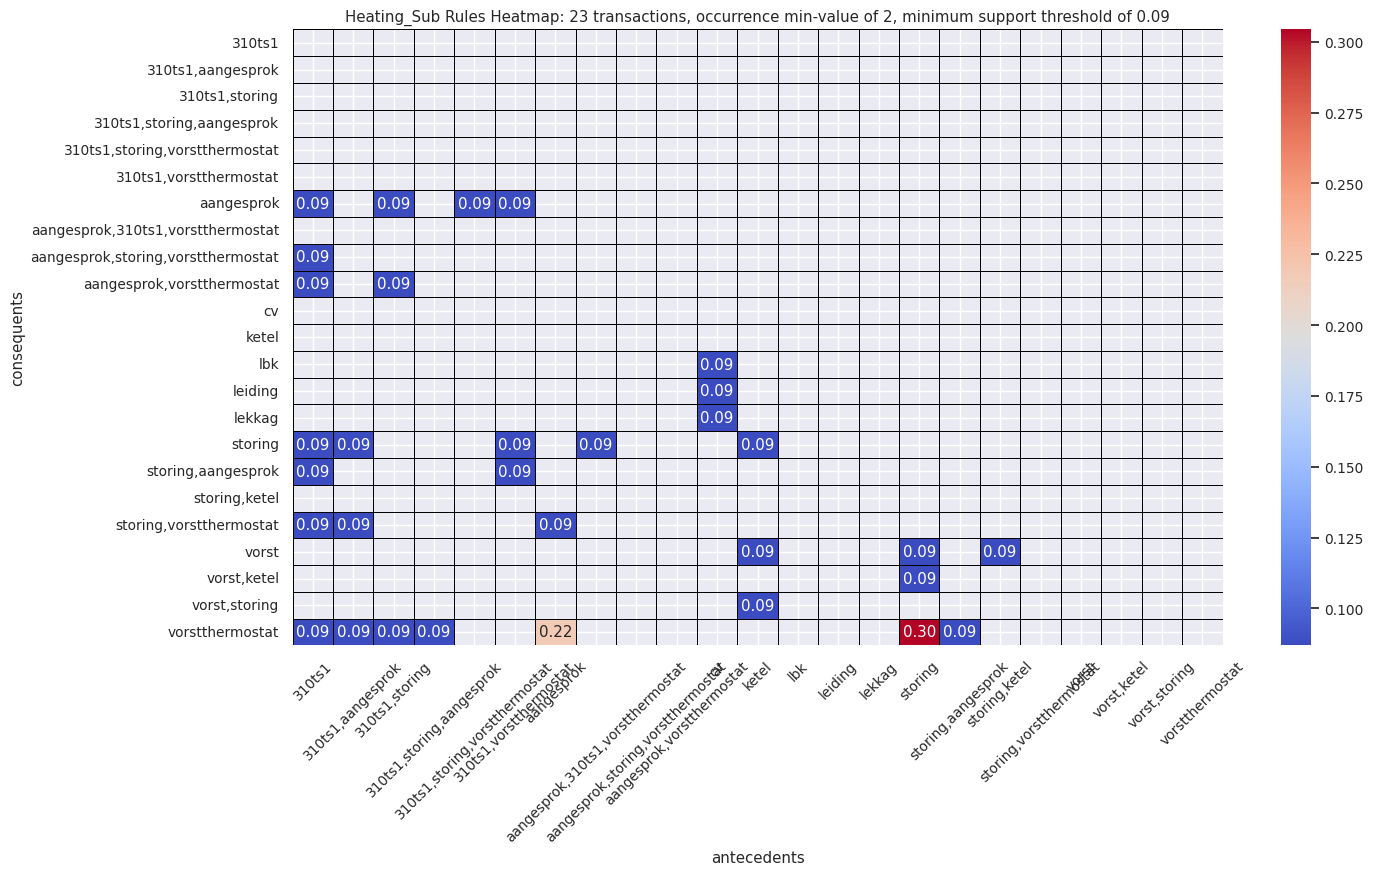

In [ ]:
# Extract the service order descriptions related to the 'Heating' submodule and split each description into a list of words.
transactions_heating = df_so_cleaned_ventilation[df_so_cleaned_ventilation['submodule'] == 'Heating']['SO_Omschrijving'].apply(lambda t: t.split(' '))
# Convert the series of lists into a single list of transactions.
transactions_heating = list(transactions_heating)

# Initialize the TransactionEncoder to convert the transaction lists into a one-hot encoded format.
encoder_heating = TransactionEncoder().fit(transactions_heating)
# Transform the list of transactions into a one-hot encoded DataFrame.
onehot_heating = encoder_heating.transform(transactions_heating)
# Create a DataFrame from the one-hot encoded array for easier manipulation and analysis.
onehot_heating = pd.DataFrame(onehot_heating, columns=encoder_heating.columns_)

# Set the minimum number of occurrences for each itemset to 2.
'''
Define the minimum number of occurrences for each itemset.
This indirectly acts as a hyperparamether, so tune it as you pefer.
Increase the value of "n" if you want to find more frequent itemsets.
Decrease the value of "n" if you want to find less frequent itemsets.
'''
n = 2

# Calculate the minimum support threshold based on the number of transactions.
minimum_support = n / len(onehot_heating)

# Apply the Apriori algorithm to find frequent itemsets with the specified minimum support.
frequent_itemsets_heating = apriori(onehot_heating,
                                     min_support=minimum_support,
                                     use_colnames=True,
                                     verbose=1)

# Generate association rules from the frequent itemsets using lift as the metric.
rules_heating = association_rules(frequent_itemsets_heating, metric='lift', min_threshold=1)

# Print the number of transactions and key parameters for analysis.
print(f'Number of transactions: {len(onehot_heating)}')
print(f'Minimum number of occurrence for each itemset: {n}')
print(f'Minimum support threshold for itemsets: {minimum_support}')
print(f'Number of frequent itemsets: {len(frequent_itemsets_heating)}')
print(f'Number of rules: {len(rules_heating)}')

# Replace the frozen sets in the rules with strings for easier readability.
rules_heating['antecedents'] = rules_heating['antecedents'].apply(lambda a: ','.join(list(a)))
rules_heating['consequents'] = rules_heating['consequents'].apply(lambda a: ','.join(list(a)))

# Transform the rules DataFrame to a matrix format suitable for generating a heatmap.
pivot = rules_heating.pivot(index='consequents', columns='antecedents', values='support')

# Create a mask to hide the upper triangle of the heatmap.
mask = np.triu(np.ones_like(pivot, dtype=bool))

# Set the font scale for the heatmap visualization.
sns.set(font_scale=0.9)
# Create a new figure for the heatmap with specified dimensions.
plt.figure(figsize=(15, 8))

# Generate the heatmap with the specified color map and formatting options.
heatmap = sns.heatmap(pivot, cmap='coolwarm', cbar=True, linewidths=0.5, linecolor='black', mask=mask, annot=True, fmt='.2f')

# Rotate the x-axis tick labels for better readability.
plt.xticks(rotation=45)
# Set the title for the heatmap, including key statistics about the transactions and thresholds.
plt.title(f'Heating_Sub Rules Heatmap: {len(onehot_heating)} transactions, occurrence min-value of {n}, minimum support threshold of {minimum_support:.2f}')
# Rotate the y-axis tick labels for better readability.
plt.yticks(rotation=0)

# Save the heatmap image to the specified file path.
plt.savefig('/content/drive/MyDrive/Kropman/figures/heatmaps/ahu/heating.png')
# Display the heatmap on the screen.
plt.show()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


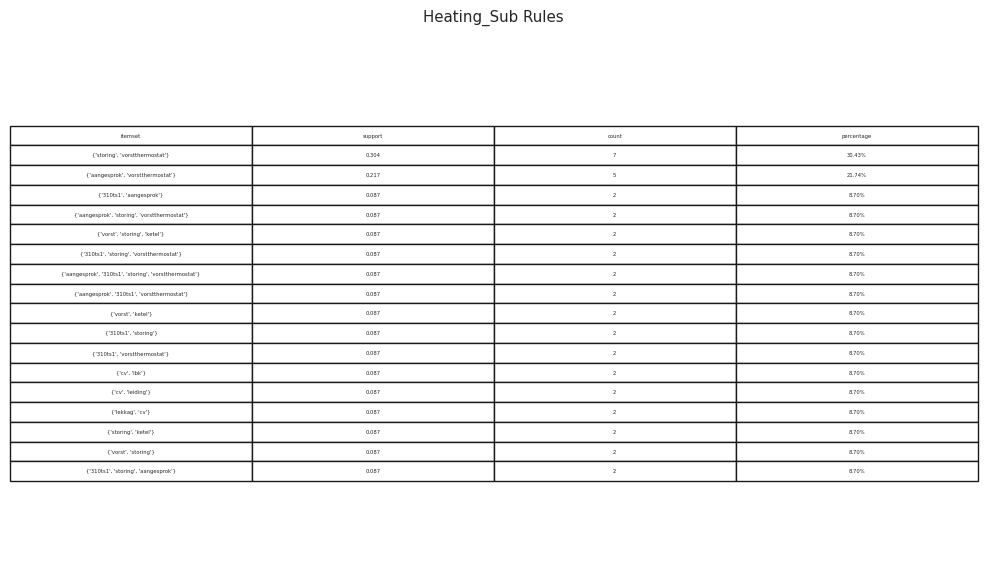

In [ ]:
# Sort the rules based on support values in descending order.
rules_heating.sort_values(by='support', ascending=False, inplace=True)

# Create a new 'itemset' column by combining the 'antecedents' and 'consequents' into a single string.
rules_heating['itemset'] = rules_heating.apply(lambda row: f"{row['antecedents']},{row['consequents']}", axis=1)

# Calculate the count for each rule by multiplying its support by the total number of transactions.
rules_heating['count'] = rules_heating.apply(lambda row: int(row['support'] * len(onehot_heating)), axis=1)

# Convert the 'itemset' string representation back into a set for easier manipulation later.
rules_heating['itemset'] = rules_heating['itemset'].apply(convert_str_to_set)

# Round the support values to three decimal places for better readability in the output table.
rules_heating['rounded_support'] = rules_heating.apply(lambda row: f"{row['support']:.3f}", axis=1)

# Calculate the percentage representation of each rule's count relative to the total number of transactions.
rules_heating['percentage'] = rules_heating.apply(lambda row: f"{row['count'] * 100 / len(onehot_heating):.2f}%", axis=1)

# Remove any duplicate itemsets while keeping the first occurrence.
rules_heating.drop_duplicates(subset=['itemset'], keep='first', inplace=True)

# Reset the index of the DataFrame after dropping duplicates for cleaner output.
rules_heating.reset_index(inplace=True)

# Display the relevant columns: itemset, support, count, and percentage for verification.
rules_heating[['itemset', 'support', 'count', 'percentage']]

# Create a new figure for the table visualization with specified dimensions.
fig, ax = plt.subplots(figsize=(10, 6))
# Set the axes to 'tight' and turn off the axis display for a clean look.
ax.axis('tight')
ax.axis('off')

# Generate a table to display the heating rules with rounded support, count, and percentage.
ax.table(cellText=rules_heating[['itemset', 'rounded_support', 'count', 'percentage']].values,
         colLabels=rules_heating[['itemset', 'support', 'count', 'percentage']].columns,
         cellLoc='center', loc='center', fontsize=12)

# Set the title for the table visualization.
plt.title('Heating_Sub Rules')
# Adjust layout to ensure everything fits nicely in the figure.
plt.tight_layout()
# Save the table image to the specified file path.
plt.savefig('/content/drive/MyDrive/Kropman/figures/tables/ahu/heating.png')
# Display the table visualization on the screen.
plt.show()

## Cooling

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


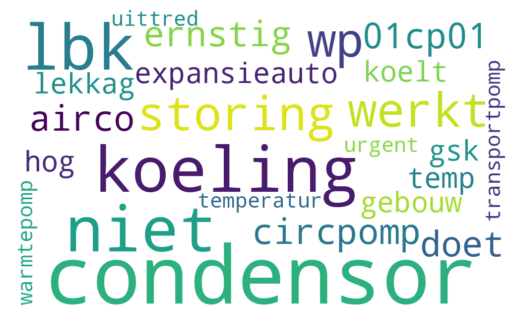

In [ ]:
# Extract service order descriptions for the Cooling subsystem and convert them into a list.
corpus_cooling = df_so_cleaned_ventilation[df_so_cleaned_ventilation['submodule'] == 'Cooling']['SO_Omschrijving'].tolist()

# Initialize the CountVectorizer to convert the text data into a matrix of token counts.
vectorizer_cooling = CountVectorizer(ngram_range=(1, 1))

# Fit the vectorizer on the cooling corpus and transform the text data into a document-term matrix (DTM).
dtm_cooling = vectorizer_cooling.fit_transform(corpus_cooling)

# Get the feature names (terms) used in the DTM for the cooling subsystem.
terms_cooling = vectorizer_cooling.get_feature_names_out()

# Convert the DTM from sparse matrix format to a dense DataFrame for easier manipulation and visualization.
dtm_cooling = pd.DataFrame(dtm_cooling.toarray(), columns=terms_cooling)

# Sum the term frequencies across all service orders to get the frequency of each term.
term_frequencies_cooling = dtm_cooling.sum()

# Generate a word cloud image based on the term frequencies, visualizing the most common terms.
wordcloud = WordCloud(width=1000, height=600, background_color='white').generate_from_frequencies(term_frequencies_cooling)

# Display the generated word cloud using bilinear interpolation for smoother rendering.
plt.imshow(wordcloud, interpolation='bilinear')

# Turn off the axis display for a cleaner look at the word cloud.
plt.axis('off')

# Save the generated word cloud image to the specified file path.
plt.savefig('/content/drive/MyDrive/Kropman/figures/word_clouds/ahu/cooling.png')

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Processing 4 combinations | Sampling itemset size 4
Number of transactions: 11
Minimum number of occurrences for each itemset: 2
Minimum support threshold for itemsets: 0.18181818181818182
Number of frequent itemsets: 19
Number of rules: 52


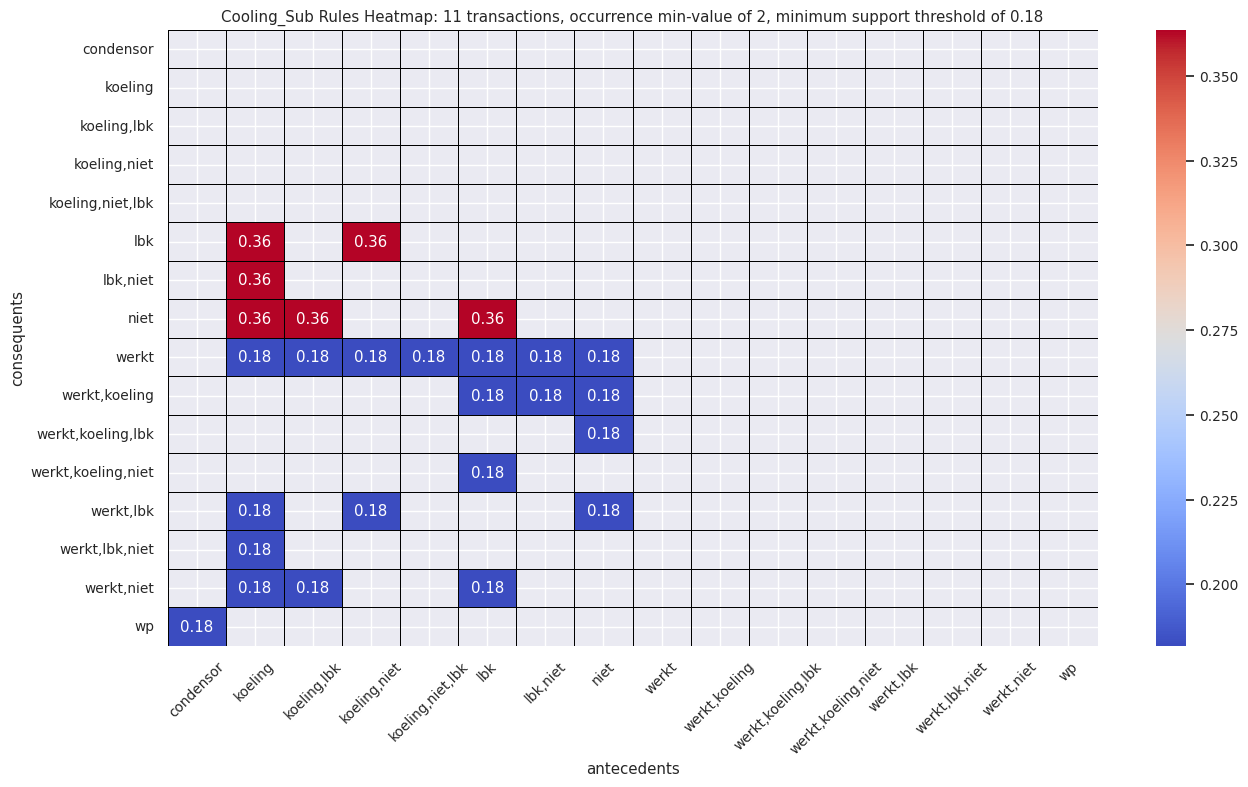

In [ ]:
# Extract service order descriptions for the Cooling subsystem, splitting each description into individual words.
transactions_cooling = df_so_cleaned_ventilation[df_so_cleaned_ventilation['submodule'] == 'Cooling']['SO_Omschrijving'].apply(lambda t: t.split(' '))

# Convert the resulting series of lists into a list of transactions.
transactions_cooling = list(transactions_cooling)

# Initialize the TransactionEncoder to convert the list of transactions into a one-hot encoded format.
encoder_cooling = TransactionEncoder().fit(transactions_cooling)

# Transform the transactions into a one-hot encoded matrix format.
onehot_cooling = encoder_cooling.transform(transactions_cooling)

# Convert the one-hot encoded matrix into a DataFrame for easier manipulation and analysis.
onehot_cooling = pd.DataFrame(onehot_cooling, columns=encoder_cooling.columns_)

# Set the minimum number of occurrences required for an itemset to be considered frequent.
'''
Define the minimum number of occurrences for each itemset.
This indirectly acts as a hyperparamether, so tune it as you pefer.
Increase the value of "n" if you want to find more frequent itemsets.
Decrease the value of "n" if you want to find less frequent itemsets.
'''
n = 2

# Calculate the minimum support threshold based on the number of transactions.
minimum_support = n / len(onehot_cooling)

# Use the apriori algorithm to find frequent itemsets in the one-hot encoded data.
frequent_itemsets_cooling = apriori(onehot_cooling, min_support=minimum_support, use_colnames=True, verbose=1)

# Generate association rules from the frequent itemsets, using lift as the metric.
rules_cooling = association_rules(frequent_itemsets_cooling, metric='lift', min_threshold=1)

# Print summary statistics about the transactions and rules found.
print(f'Number of transactions: {len(onehot_cooling)}')
print(f'Minimum number of occurrences for each itemset: {n}')
print(f'Minimum support threshold for itemsets: {minimum_support}')
print(f'Number of frequent itemsets: {len(frequent_itemsets_cooling)}')
print(f'Number of rules: {len(rules_cooling)}')

# Replace frozen sets in the antecedents and consequents of the rules with comma-separated strings for better readability.
rules_cooling['antecedents'] = rules_cooling['antecedents'].apply(lambda a: ','.join(list(a)))
rules_cooling['consequents'] = rules_cooling['consequents'].apply(lambda a: ','.join(list(a)))

# Transform the rules data into a matrix format suitable for generating a heatmap.
pivot = rules_cooling.pivot(index='consequents', columns='antecedents', values='support')

# Create a mask for the upper triangle of the heatmap to improve visual clarity.
mask = np.triu(np.ones_like(pivot, dtype=bool))

# Set the font scale for the seaborn heatmap.
sns.set(font_scale=0.9)

# Create a figure for the heatmap with specified dimensions.
plt.figure(figsize=(15, 8))

# Generate the heatmap using the pivoted data, setting colors, annotations, and other visual parameters.
heatmap = sns.heatmap(pivot, cmap='coolwarm', cbar=True, linewidths=0.5, linecolor='black', mask=mask, annot=True, fmt='.2f')

# Rotate x-ticks for better readability.
plt.xticks(rotation=45)

# Set the title of the heatmap to reflect the analysis details.
plt.title(f'Cooling_Sub Rules Heatmap: {len(onehot_cooling)} transactions, occurrence min-value of {n}, minimum support threshold of {minimum_support:.2f}')

# Rotate y-ticks for better readability.
plt.yticks(rotation=0)

# Save the generated heatmap to the specified file path.
plt.savefig('/content/drive/MyDrive/Kropman/figures/heatmaps/ahu/cooling.png')

# Display the heatmap.
plt.show()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


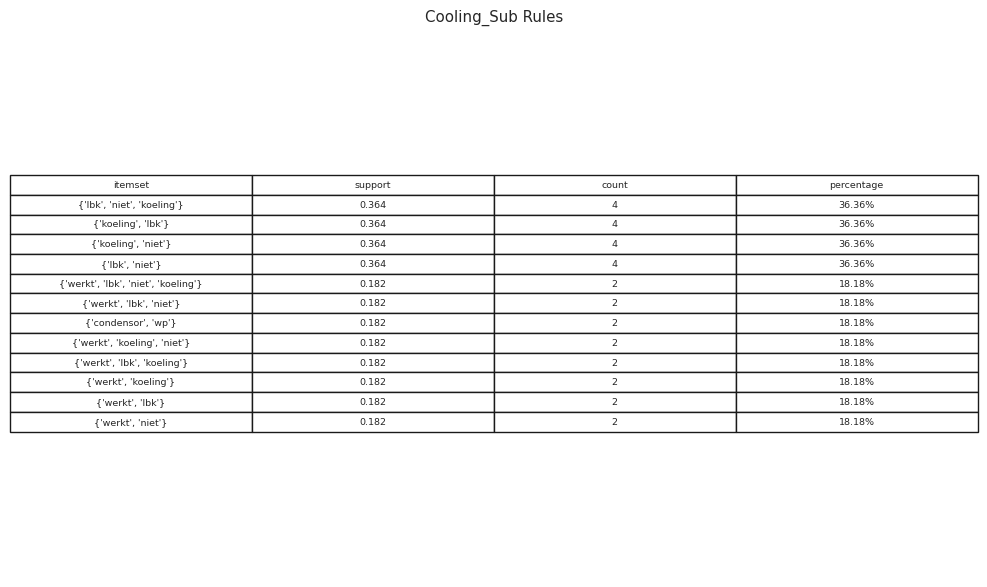

In [ ]:
# Sort the rules by their support values in descending order for better visibility of the most significant rules.
rules_cooling.sort_values(by='support', ascending=False, inplace=True)

# Create a new column 'itemset' that combines the 'antecedents' and 'consequents' into a single string for easier interpretation.
rules_cooling['itemset'] = rules_cooling.apply(lambda row: f"{row['antecedents']},{row['consequents']}", axis=1)

# Calculate the count of occurrences for each rule by multiplying the support value with the total number of transactions.
rules_cooling['count'] = rules_cooling.apply(lambda row: int(row['support'] * len(onehot_cooling)), axis=1)

# Convert the 'itemset' strings back into sets for consistency and easier manipulation in later analysis.
rules_cooling['itemset'] = rules_cooling['itemset'].apply(convert_str_to_set)

# Round the support values to three decimal places for cleaner presentation in the output table.
rules_cooling['rounded_support'] = rules_cooling.apply(lambda row: f"{row['support']:.3f}", axis=1)

# Calculate the percentage of each rule's count relative to the total number of transactions for better interpretability.
rules_cooling['percentage'] = rules_cooling.apply(lambda row: f"{row['count'] * 100 / len(onehot_cooling):.2f}%", axis=1)

# Remove duplicate itemsets to ensure that each unique rule is only represented once in the output.
rules_cooling.drop_duplicates(subset=['itemset'], keep='first', inplace=True)

# Reset the index of the DataFrame for cleaner presentation and easier access to rows.
rules_cooling.reset_index(inplace=True)

# Create a new figure for displaying the rules in a table format.
fig, ax = plt.subplots(figsize=(10, 6))

# Set the axis to be tight and turn off the axis visibility to focus on the table itself.
ax.axis('tight')
ax.axis('off')

# Create a table to display the relevant columns of the rules DataFrame, including the formatted values for clarity.
ax.table(cellText=rules_cooling[['itemset', 'rounded_support', 'count', 'percentage']].values,
         colLabels=rules_cooling[['itemset', 'support', 'count', 'percentage']].columns,
         cellLoc='center', loc='center', fontsize=12)

# Set the title for the table to describe what the rules represent.
plt.title('Cooling_Sub Rules')

# Adjust the layout to ensure everything fits well without overlap.
plt.tight_layout()

# Save the generated table as a PNG file to the specified path for future reference or inclusion in reports.
plt.savefig('/content/drive/MyDrive/Kropman/figures/tables/ahu/cooling.png')

# Display the table visually.
plt.show()

## Casing

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


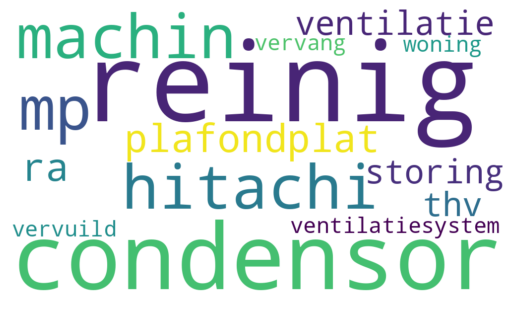

In [ ]:
corpus_casing = df_so_cleaned_ventilation[df_so_cleaned_ventilation['submodule'] == 'Casing']['SO_Omschrijving'].tolist()
vectorizer_casing = CountVectorizer(ngram_range=(1, 1))
dtm_casing = vectorizer_casing.fit_transform(corpus_casing)
terms_casing = vectorizer_casing.get_feature_names_out()
dtm_casing = pd.DataFrame(dtm_casing.toarray(), columns=terms_casing)
term_frequencies_casing = dtm_casing.sum()

wordcloud = WordCloud(width=1000, height=600, background_color='white').generate_from_frequencies(term_frequencies_casing)

# plt.title('Casing Word Cloud')
# plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.savefig('/content/drive/MyDrive/Kropman/figures/word_clouds/ahu/casing.png')

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Processing 2 combinations | Sampling itemset size 2
Number of transactions: 5
Minimum number of occurrence for each itemset: 2
Minimum support threshold for itemsets: 0.4
number of frequent itemsets: 3
Number of rules: 2


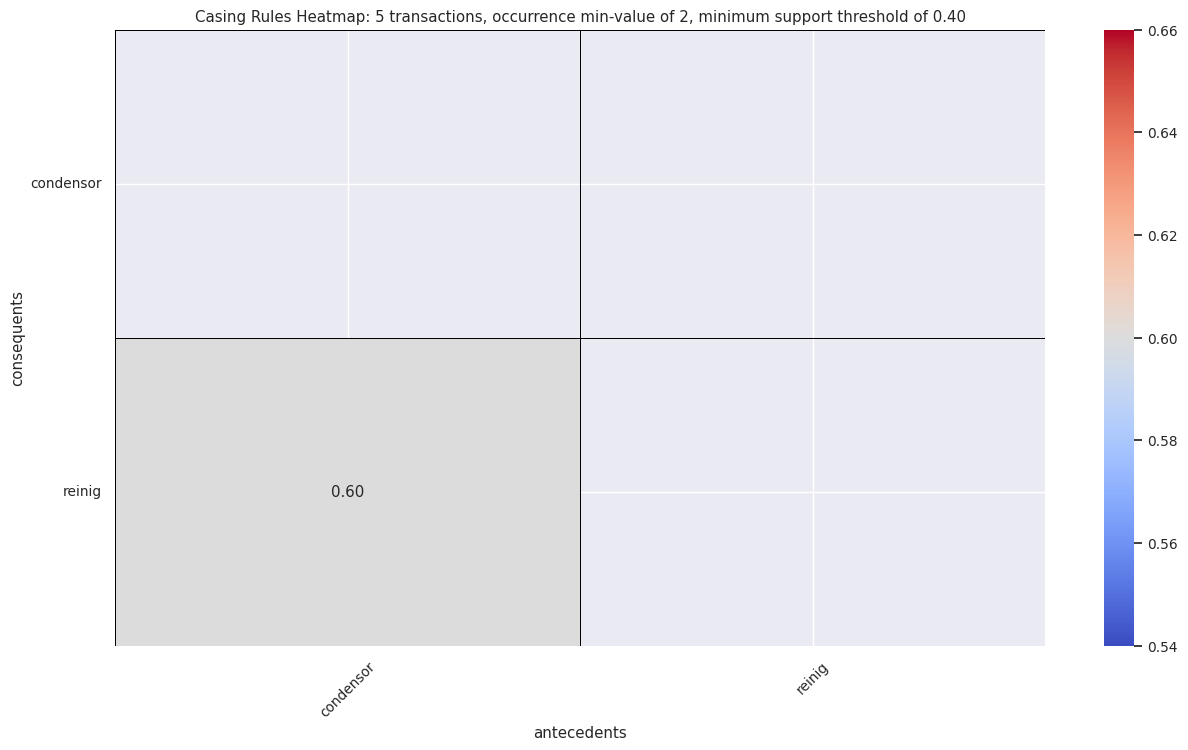

In [ ]:
transactions_casing = df_so_cleaned_ventilation[df_so_cleaned_ventilation['submodule'] == 'Casing']['SO_Omschrijving'].apply(lambda t: t.split(' '))
transactions_casing = list(transactions_casing)
encoder_casing = TransactionEncoder().fit(transactions_casing)
onehot_casing = encoder_casing.transform(transactions_casing)
onehot_casing = pd.DataFrame(onehot_casing, columns=encoder_casing.columns_)

n = 2
minimum_support = n/len(onehot_casing)
frequent_itemsets_casing = apriori(onehot_casing,
                            min_support =  minimum_support,
                            use_colnames = True,
                            verbose = 1)

rules_casing = association_rules(frequent_itemsets_casing, metric = 'lift', min_threshold = 1)

print(f'Number of transactions: {len(onehot_casing)}')
print(f'Minimum number of occurrence for each itemset: {n}')
print(f'Minimum support threshold for itemsets: {minimum_support}')
print(f'number of frequent itemsets: {len(frequent_itemsets_casing)}')
print(f'Number of rules: {len(rules_casing)}')

# Replace frozen sets with strings.
rules_casing['antecedents'] = rules_casing['antecedents'].apply(lambda a: ','.join(list(a)))
rules_casing['consequents'] = rules_casing['consequents'].apply(lambda a: ','.join(list(a)))

# Transform data to matrix format and generate heatmap.
pivot = rules_casing.pivot(index='consequents', columns='antecedents', values='support')

mask = np.triu(np.ones_like(pivot, dtype=bool))

sns.set(font_scale=0.9)
plt.figure(figsize=(15, 8))

heatmap = sns.heatmap(pivot, cmap='coolwarm', cbar=True, linewidths=0.5, linecolor='black', mask=mask, annot=True, fmt='.2f')
plt.xticks(rotation=45)
plt.title(f'Casing Rules Heatmap: {len(onehot_casing)} transactions, occurrence min-value of {n}, minimum support threshold of {minimum_support:.2f}')
plt.yticks(rotation=0)
plt.savefig('/content/drive/MyDrive/Kropman/figures/heatmaps/ahu/casing.png')
plt.show()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


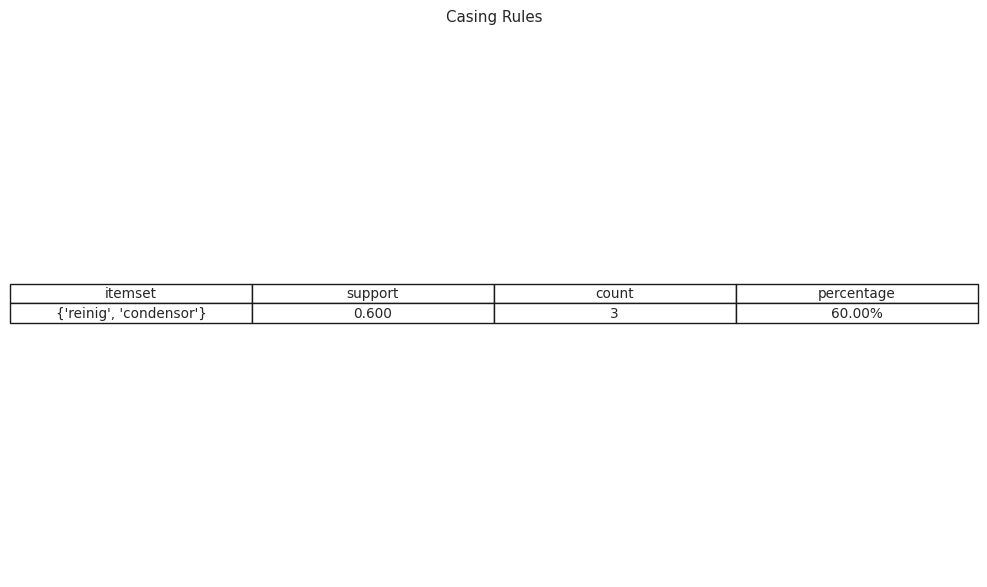

In [ ]:
rules_casing.sort_values(by='support', ascending=False, inplace=True)
rules_casing['itemset'] = rules_casing.apply(lambda row: f"{row['antecedents']},{row['consequents']}", axis=1)
rules_casing['count'] = rules_casing.apply(lambda row: int(row['support']*len(onehot_casing)), axis=1)
rules_casing['itemset'] = rules_casing['itemset'].apply(convert_str_to_set)
rules_casing['rounded_support'] = rules_casing.apply(lambda row: f"{row['support']:.3f}", axis=1)
rules_casing['percentage'] = rules_casing.apply(lambda row: f"{row['count']*100/len(onehot_casing):.2f}%", axis=1)
rules_casing.drop_duplicates(subset=['itemset'], keep='first', inplace=True)
rules_casing.reset_index(inplace=True)
rules_casing[['itemset', 'support', 'count', 'percentage']]

fig, ax = plt.subplots(figsize=(10, 6))
ax.axis('tight')
ax.axis('off')
ax.table(cellText=rules_casing[['itemset', 'rounded_support', 'count', 'percentage']].values,
         colLabels=rules_casing[['itemset', 'support', 'count', 'percentage']].columns,
         cellLoc='center', loc='center', fontsize=12)

plt.title('Casing Rules')
plt.tight_layout()
plt.savefig('/content/drive/MyDrive/Kropman/figures/tables/ahu/casing.png')
plt.show()

## Humidifier

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


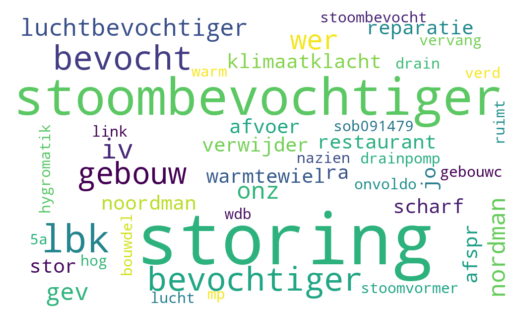

In [ ]:
corpus_humidifier = df_so_cleaned_ventilation[df_so_cleaned_ventilation['submodule'] == 'Humidifier']['SO_Omschrijving'].tolist()
vectorizer_humidifier = CountVectorizer(ngram_range=(1, 1))
dtm_humidifier = vectorizer_humidifier.fit_transform(corpus_humidifier)
terms_humidifier = vectorizer_humidifier.get_feature_names_out()
dtm_humidifier = pd.DataFrame(dtm_humidifier.toarray(), columns=terms_humidifier)
term_frequencies_humidifier = dtm_humidifier.sum()

wordcloud = WordCloud(width=1000, height=600, background_color='white').generate_from_frequencies(term_frequencies_humidifier)

# plt.title('Humidifier Word Cloud')
# plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.savefig('/content/drive/MyDrive/Kropman/figures/word_clouds/ahu/humidifier.png')

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Processing 15 combinations | Sampling itemset size 3
Number of transactions: 33
Minimum number of occurrence for each itemset: 5
Minimum support threshold for itemsets: 0.15151515151515152
number of frequent itemsets: 16
Number of rules: 24


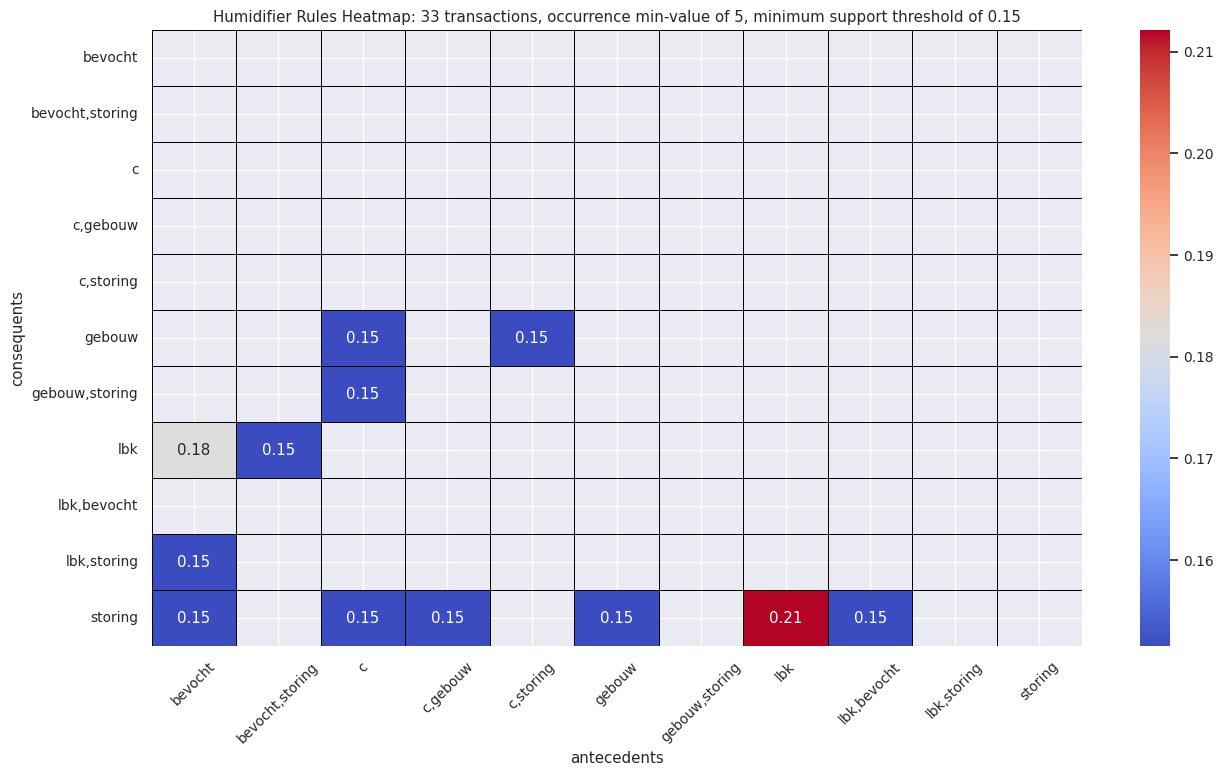

In [ ]:
transactions_humidifier = df_so_cleaned_ventilation[df_so_cleaned_ventilation['submodule'] == 'Humidifier']['SO_Omschrijving'].apply(lambda t: t.split(' '))
transactions_humidifier = list(transactions_humidifier)
encoder_humidifier = TransactionEncoder().fit(transactions_humidifier)
onehot_humidifier = encoder_humidifier.transform(transactions_humidifier)
onehot_humidifier = pd.DataFrame(onehot_humidifier, columns=encoder_humidifier.columns_)

n = 5
minimum_support = n/len(onehot_humidifier)
frequent_itemsets_humidifier = apriori(onehot_humidifier,
                            min_support =  minimum_support,
                            use_colnames = True,
                            verbose = 1)

rules_humidifier = association_rules(frequent_itemsets_humidifier, metric = 'lift', min_threshold = 1)

print(f'Number of transactions: {len(onehot_humidifier)}')
print(f'Minimum number of occurrence for each itemset: {n}')
print(f'Minimum support threshold for itemsets: {minimum_support}')
print(f'number of frequent itemsets: {len(frequent_itemsets_humidifier)}')
print(f'Number of rules: {len(rules_humidifier)}')

# Replace frozen sets with strings.
rules_humidifier['antecedents'] = rules_humidifier['antecedents'].apply(lambda a: ','.join(list(a)))
rules_humidifier['consequents'] = rules_humidifier['consequents'].apply(lambda a: ','.join(list(a)))

# Transform data to matrix format and generate heatmap.
pivot = rules_humidifier.pivot(index='consequents', columns='antecedents', values='support')

mask = np.triu(np.ones_like(pivot, dtype=bool))

sns.set(font_scale=0.9)
plt.figure(figsize=(15, 8))

heatmap = sns.heatmap(pivot, cmap='coolwarm', cbar=True, linewidths=0.5, linecolor='black', mask=mask, annot=True, fmt='.2f')
plt.xticks(rotation=45)
plt.title(f'Humidifier Rules Heatmap: {len(onehot_humidifier)} transactions, occurrence min-value of {n}, minimum support threshold of {minimum_support:.2f}')
plt.yticks(rotation=0)
plt.savefig('/content/drive/MyDrive/Kropman/figures/heatmaps/ahu/humidifier.png')
plt.show()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


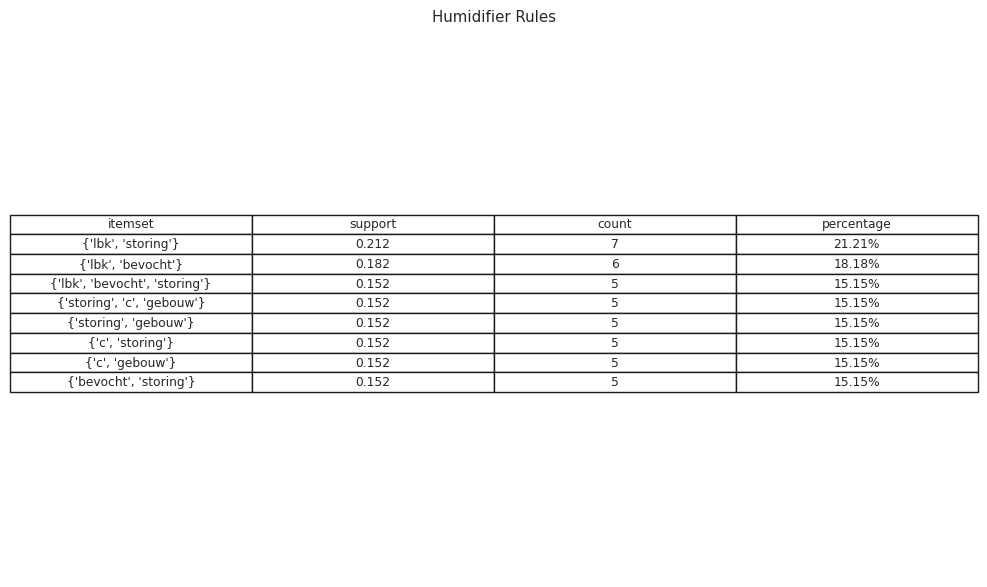

In [ ]:
rules_humidifier.sort_values(by='support', ascending=False, inplace=True)
rules_humidifier['itemset'] = rules_humidifier.apply(lambda row: f"{row['antecedents']},{row['consequents']}", axis=1)
rules_humidifier['count'] = rules_humidifier.apply(lambda row: int(row['support']*len(onehot_humidifier)), axis=1)
rules_humidifier['itemset'] = rules_humidifier['itemset'].apply(convert_str_to_set)
rules_humidifier['rounded_support'] = rules_humidifier.apply(lambda row: f"{row['support']:.3f}", axis=1)
rules_humidifier['percentage'] = rules_humidifier.apply(lambda row: f"{row['count']*100/len(onehot_humidifier):.2f}%", axis=1)
rules_humidifier.drop_duplicates(subset=['itemset'], keep='first', inplace=True)
rules_humidifier.reset_index(inplace=True)
rules_humidifier[['itemset', 'support', 'count', 'percentage']]

fig, ax = plt.subplots(figsize=(10, 6))
ax.axis('tight')
ax.axis('off')
ax.table(cellText=rules_humidifier[['itemset', 'rounded_support', 'count', 'percentage']].values,
         colLabels=rules_humidifier[['itemset', 'support', 'count', 'percentage']].columns,
         cellLoc='center', loc='center', fontsize=12)

plt.title('Humidifier Rules')
plt.tight_layout()
plt.savefig('/content/drive/MyDrive/Kropman/figures/tables/ahu/humidifier.png')
plt.show()

## Heat Exchanger

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


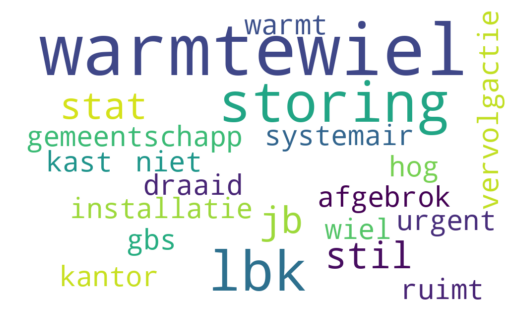

In [ ]:
corpus_heatExchanger = df_so_cleaned_ventilation[df_so_cleaned_ventilation['submodule'] == 'Heat Exchanger']['SO_Omschrijving'].tolist()
vectorizer_heatExchanger = CountVectorizer(ngram_range=(1, 1))
dtm_heatExchanger = vectorizer_heatExchanger.fit_transform(corpus_heatExchanger)
terms_heatExchanger = vectorizer_heatExchanger.get_feature_names_out()
dtm_heatExchanger = pd.DataFrame(dtm_heatExchanger.toarray(), columns=terms_heatExchanger)
term_frequencies_heatExchanger = dtm_heatExchanger.sum()

wordcloud = WordCloud(width=1000, height=600, background_color='white').generate_from_frequencies(term_frequencies_heatExchanger)

# plt.title('Heat Exchanger Word Cloud')
# plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.savefig('/content/drive/MyDrive/Kropman/figures/word_clouds/ahu/heat_exchanger.png')

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Processing 8 combinations | Sampling itemset size 4
Number of transactions: 12
Minimum number of occurrence for each itemset: 2
Minimum support threshold for itemsets: 0.16666666666666666
number of frequent itemsets: 21
Number of rules: 60


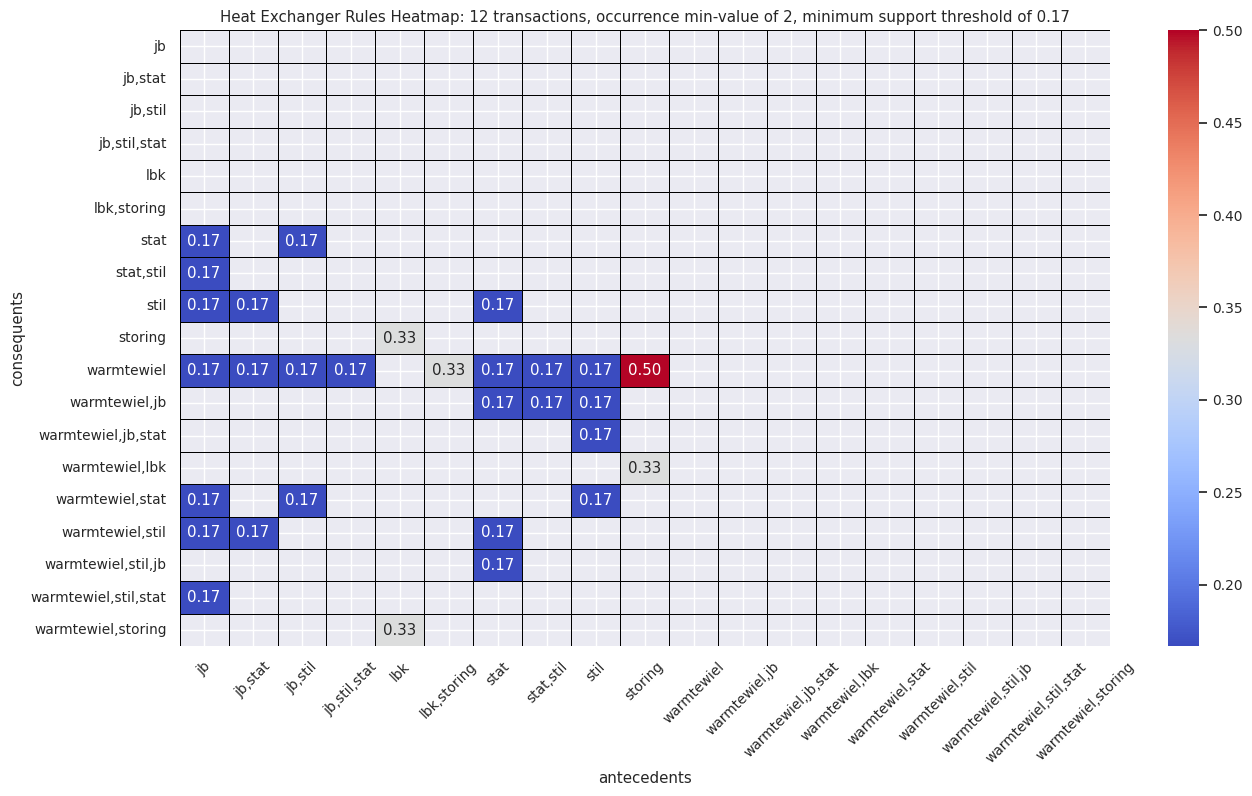

In [ ]:
transactions_heatExchanger = df_so_cleaned_ventilation[df_so_cleaned_ventilation['submodule'] == 'Heat Exchanger']['SO_Omschrijving'].apply(lambda t: t.split(' '))
transactions_heatExchanger = list(transactions_heatExchanger)
encoder_heatExchanger = TransactionEncoder().fit(transactions_heatExchanger)
onehot_heatExchanger = encoder_heatExchanger.transform(transactions_heatExchanger)
onehot_heatExchanger = pd.DataFrame(onehot_heatExchanger, columns=encoder_heatExchanger.columns_)

n = 2
minimum_support = n/len(onehot_heatExchanger)
frequent_itemsets_heatExchanger = apriori(onehot_heatExchanger,
                            min_support =  minimum_support,
                            use_colnames = True,
                            verbose = 1)

rules_heatExchanger = association_rules(frequent_itemsets_heatExchanger, metric = 'lift', min_threshold = 1)

print(f'Number of transactions: {len(onehot_heatExchanger)}')
print(f'Minimum number of occurrence for each itemset: {n}')
print(f'Minimum support threshold for itemsets: {minimum_support}')
print(f'number of frequent itemsets: {len(frequent_itemsets_heatExchanger)}')
print(f'Number of rules: {len(rules_heatExchanger)}')

# Replace frozen sets with strings.
rules_heatExchanger['antecedents'] = rules_heatExchanger['antecedents'].apply(lambda a: ','.join(list(a)))
rules_heatExchanger['consequents'] = rules_heatExchanger['consequents'].apply(lambda a: ','.join(list(a)))

# Transform data to matrix format and generate heatmap.
pivot = rules_heatExchanger.pivot(index='consequents', columns='antecedents', values='support')

mask = np.triu(np.ones_like(pivot, dtype=bool))

sns.set(font_scale=0.9)
plt.figure(figsize=(15, 8))

heatmap = sns.heatmap(pivot, cmap='coolwarm', cbar=True, linewidths=0.5, linecolor='black', mask=mask, annot=True, fmt='.2f')
plt.xticks(rotation=45)
plt.title(f'Heat Exchanger Rules Heatmap: {len(onehot_heatExchanger)} transactions, occurrence min-value of {n}, minimum support threshold of {minimum_support:.2f}')
plt.yticks(rotation=0)
plt.savefig('/content/drive/MyDrive/Kropman/figures/heatmaps/ahu/heat_exchanger.png')
plt.show()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


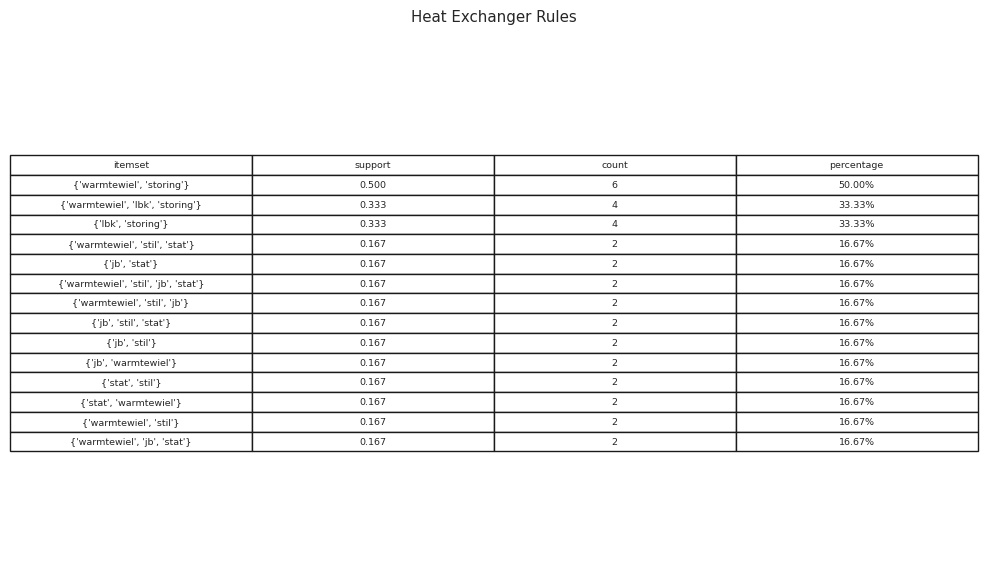

In [ ]:
rules_heatExchanger.sort_values(by='support', ascending=False, inplace=True)
rules_heatExchanger['itemset'] = rules_heatExchanger.apply(lambda row: f"{row['antecedents']},{row['consequents']}", axis=1)
rules_heatExchanger['count'] = rules_heatExchanger.apply(lambda row: int(row['support']*len(onehot_heatExchanger)), axis=1)
rules_heatExchanger['itemset'] = rules_heatExchanger['itemset'].apply(convert_str_to_set)
rules_heatExchanger['rounded_support'] = rules_heatExchanger.apply(lambda row: f"{row['support']:.3f}", axis=1)
rules_heatExchanger['percentage'] = rules_heatExchanger.apply(lambda row: f"{row['count']*100/len(onehot_heatExchanger):.2f}%", axis=1)
rules_heatExchanger.drop_duplicates(subset=['itemset'], keep='first', inplace=True)
rules_heatExchanger.reset_index(inplace=True)
rules_heatExchanger[['itemset', 'support', 'count', 'percentage']]

fig, ax = plt.subplots(figsize=(10, 6))
ax.axis('tight')
ax.axis('off')
ax.table(cellText=rules_heatExchanger[['itemset', 'rounded_support', 'count', 'percentage']].values,
         colLabels=rules_heatExchanger[['itemset', 'support', 'count', 'percentage']].columns,
         cellLoc='center', loc='center', fontsize=12)

plt.title('Heat Exchanger Rules')
plt.tight_layout()
plt.savefig('/content/drive/MyDrive/Kropman/figures/tables/ahu/heat_exchanger.png')
plt.show()

## Damper

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


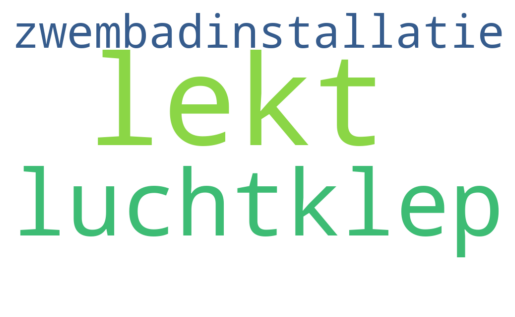

In [ ]:
corpus_damper = df_so_cleaned_ventilation[df_so_cleaned_ventilation['submodule'] == 'Damper']['SO_Omschrijving'].tolist()
vectorizer_damper = CountVectorizer(ngram_range=(1, 1))
dtm_damper = vectorizer_damper.fit_transform(corpus_damper)
terms_damper = vectorizer_damper.get_feature_names_out()
dtm_damper = pd.DataFrame(dtm_damper.toarray(), columns=terms_damper)
term_frequencies_damper = dtm_damper.sum()

wordcloud = WordCloud(width=1000, height=600, background_color='white').generate_from_frequencies(term_frequencies_damper)

# plt.title('Damper Word Cloud')
# plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.savefig('/content/drive/MyDrive/Kropman/figures/word_clouds/ahu/damper.png')

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Processing 3 combinations | Sampling itemset size 3
Number of transactions: 1
Minimum number of occurrence for each itemset: 1
Minimum support threshold for itemsets: 1.0
number of frequent itemsets: 7
Number of rules: 12


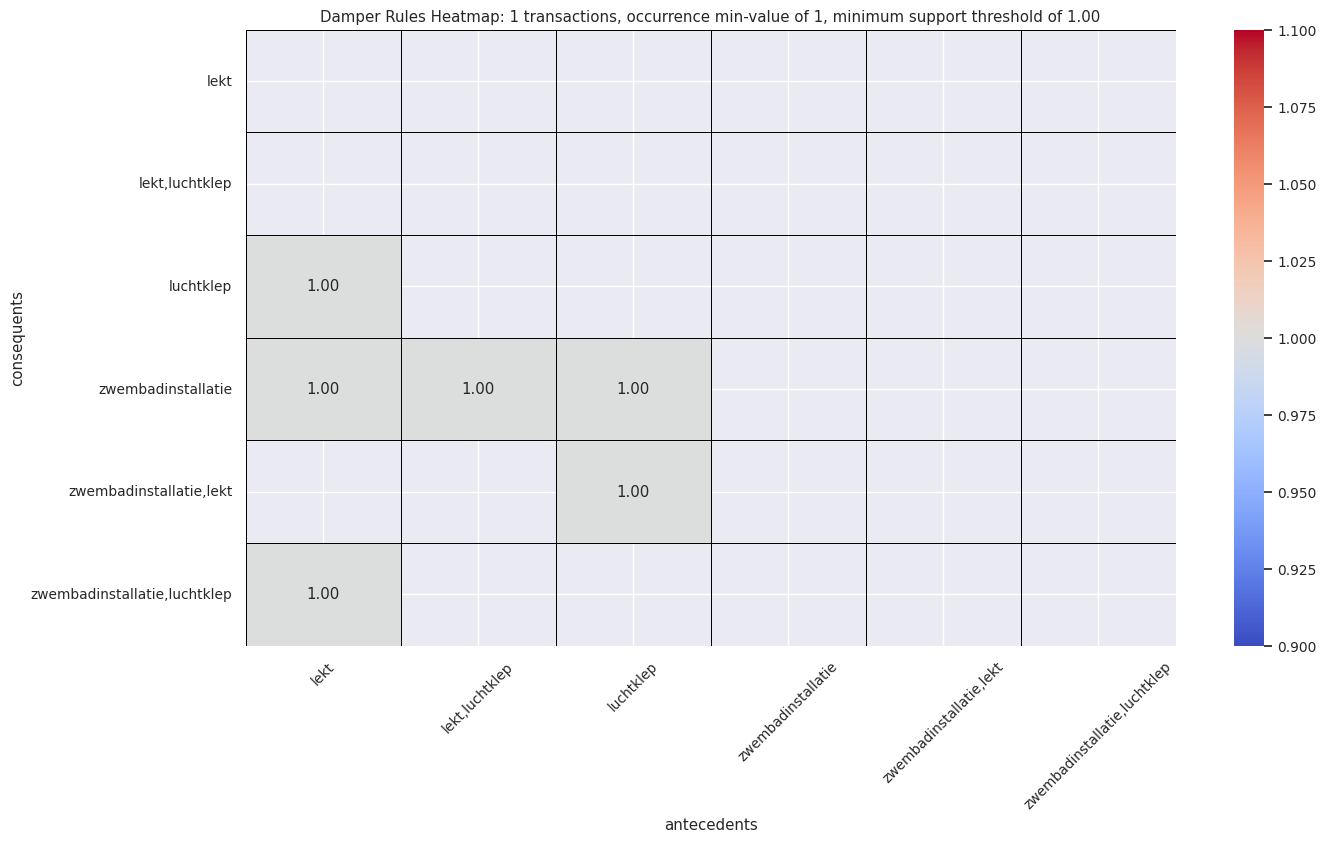

In [ ]:
transactions_damper = df_so_cleaned_ventilation[df_so_cleaned_ventilation['submodule'] == 'Damper']['SO_Omschrijving'].apply(lambda t: t.split(' '))
transactions_damper = list(transactions_damper)
encoder_damper = TransactionEncoder().fit(transactions_damper)
onehot_damper = encoder_damper.transform(transactions_damper)
onehot_damper = pd.DataFrame(onehot_damper, columns=encoder_damper.columns_)

n = 1
minimum_support = n/len(onehot_damper)
frequent_itemsets_damper = apriori(onehot_damper,
                            min_support =  minimum_support,
                            use_colnames = True,
                            verbose = 1)

rules_damper = association_rules(frequent_itemsets_damper, metric = 'lift', min_threshold = 1)

print(f'Number of transactions: {len(onehot_damper)}')
print(f'Minimum number of occurrence for each itemset: {n}')
print(f'Minimum support threshold for itemsets: {minimum_support}')
print(f'number of frequent itemsets: {len(frequent_itemsets_damper)}')
print(f'Number of rules: {len(rules_damper)}')

# Replace frozen sets with strings.
rules_damper['antecedents'] = rules_damper['antecedents'].apply(lambda a: ','.join(list(a)))
rules_damper['consequents'] = rules_damper['consequents'].apply(lambda a: ','.join(list(a)))

# Transform data to matrix format and generate heatmap.
pivot = rules_damper.pivot(index='consequents', columns='antecedents', values='support')

mask = np.triu(np.ones_like(pivot, dtype=bool))

sns.set(font_scale=0.9)
plt.figure(figsize=(15, 8))
heatmap = sns.heatmap(pivot, cmap='coolwarm', cbar=True, linewidths=0.5, linecolor='black', mask=mask, annot=True, fmt='.2f')
plt.xticks(rotation=45)
plt.title(f'Damper Rules Heatmap: {len(onehot_damper)} transactions, occurrence min-value of {n}, minimum support threshold of {minimum_support:.2f}')
plt.yticks(rotation=0)
plt.savefig('/content/drive/MyDrive/Kropman/figures/heatmaps/ahu/damper.png')
plt.show()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


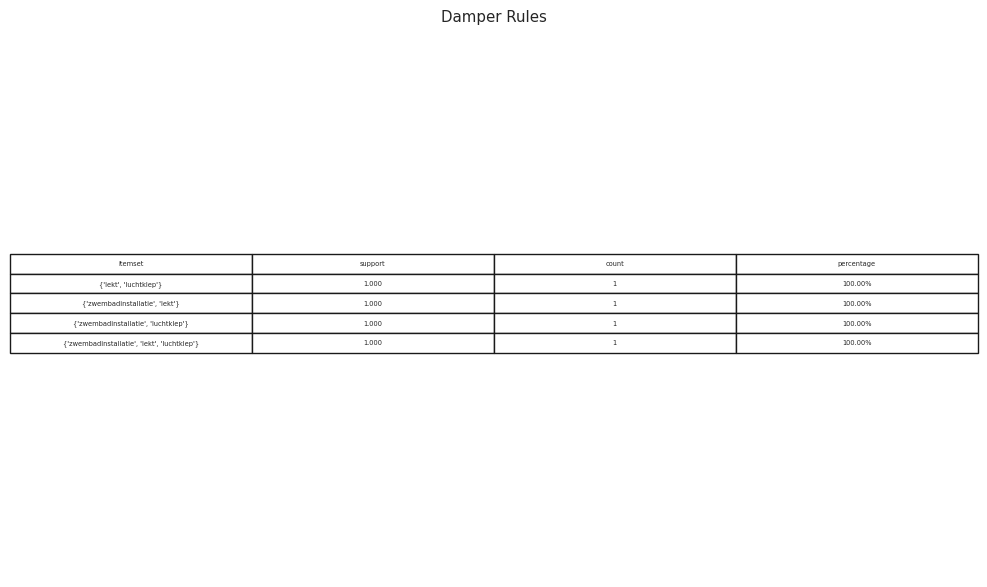

In [ ]:
rules_damper.sort_values(by='support', ascending=False, inplace=True)
rules_damper['itemset'] = rules_damper.apply(lambda row: f"{row['antecedents']},{row['consequents']}", axis=1)
rules_damper['count'] = rules_damper.apply(lambda row: int(row['support']*len(onehot_damper)), axis=1)
rules_damper['itemset'] = rules_damper['itemset'].apply(convert_str_to_set)
rules_damper['rounded_support'] = rules_damper.apply(lambda row: f"{row['support']:.3f}", axis=1)
rules_damper['percentage'] = rules_damper.apply(lambda row: f"{row['count']*100/len(onehot_damper):.2f}%", axis=1)
rules_damper.drop_duplicates(subset=['itemset'], keep='first', inplace=True)
rules_damper.reset_index(inplace=True)
rules_damper[['itemset', 'support', 'count', 'percentage']]

fig, ax = plt.subplots(figsize=(10, 6))
ax.axis('tight')
ax.axis('off')
ax.table(cellText=rules_damper[['itemset', 'rounded_support', 'count', 'percentage']].values,
         colLabels=rules_damper[['itemset', 'support', 'count', 'percentage']].columns,
         cellLoc='center', loc='center', fontsize=12)

plt.title('Damper Rules')
plt.tight_layout()
plt.savefig('/content/drive/MyDrive/Kropman/figures/tables/ahu/damper.png')
plt.show()

## Undefined Malfunctions

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


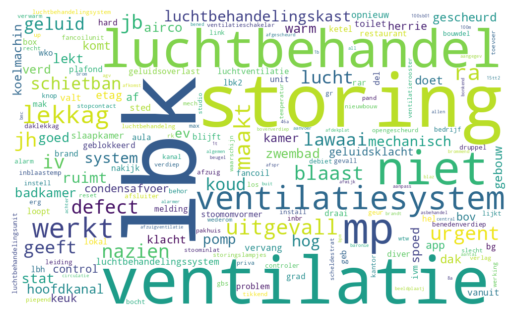

In [ ]:
# Extract the service order descriptions related to 'Undefined Malfunctions' submodule into a list.
corpus_undifiedMalfunctions = df_so_cleaned_ventilation[df_so_cleaned_ventilation['submodule'] == 'Undefined Malfunctions']['SO_Omschrijving'].tolist()

# Initialize the CountVectorizer to convert the text data into a document-term matrix (DTM) with unigrams (single words).
vectorizer_undifiedMalfunctions = CountVectorizer(ngram_range=(1, 1))

# Fit the vectorizer to the corpus and transform the text data into a document-term matrix.
dtm_undifiedMalfunctions = vectorizer_undifiedMalfunctions.fit_transform(corpus_undifiedMalfunctions)

# Retrieve the feature names (terms) from the vectorizer after fitting it to the corpus.
terms_undifiedMalfunctions = vectorizer_undifiedMalfunctions.get_feature_names_out()

# Convert the sparse DTM to a dense DataFrame for easier manipulation and analysis.
dtm_undifiedMalfunctions = pd.DataFrame(dtm_undifiedMalfunctions.toarray(), columns=terms_undifiedMalfunctions)

# Calculate the term frequencies by summing the counts of each term across all documents in the DTM.
term_frequencies_undifiedMalfunctions = dtm_undifiedMalfunctions.sum()

# Generate a word cloud image based on the term frequencies calculated earlier, visualizing the most common words.
wordcloud = WordCloud(width=1000, height=600, background_color='white').generate_from_frequencies(term_frequencies_undifiedMalfunctions)

# Display the generated word cloud image.
plt.imshow(wordcloud, interpolation='bilinear')

# Turn off the axis for a cleaner presentation of the word cloud.
plt.axis('off')

# Save the word cloud image to a specified file path for future reference or inclusion in reports.
plt.savefig('/content/drive/MyDrive/Kropman/figures/word_clouds/ahu/undefined_malfunctions.png')

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Processing 99 combinations | Sampling itemset size 3
Number of transactions: 369
Minimum number of occurrence for each itemset: 10
Minimum support threshold for itemsets: 0.02710027100271003
Number of frequent itemsets: 37
Number of rules: 20


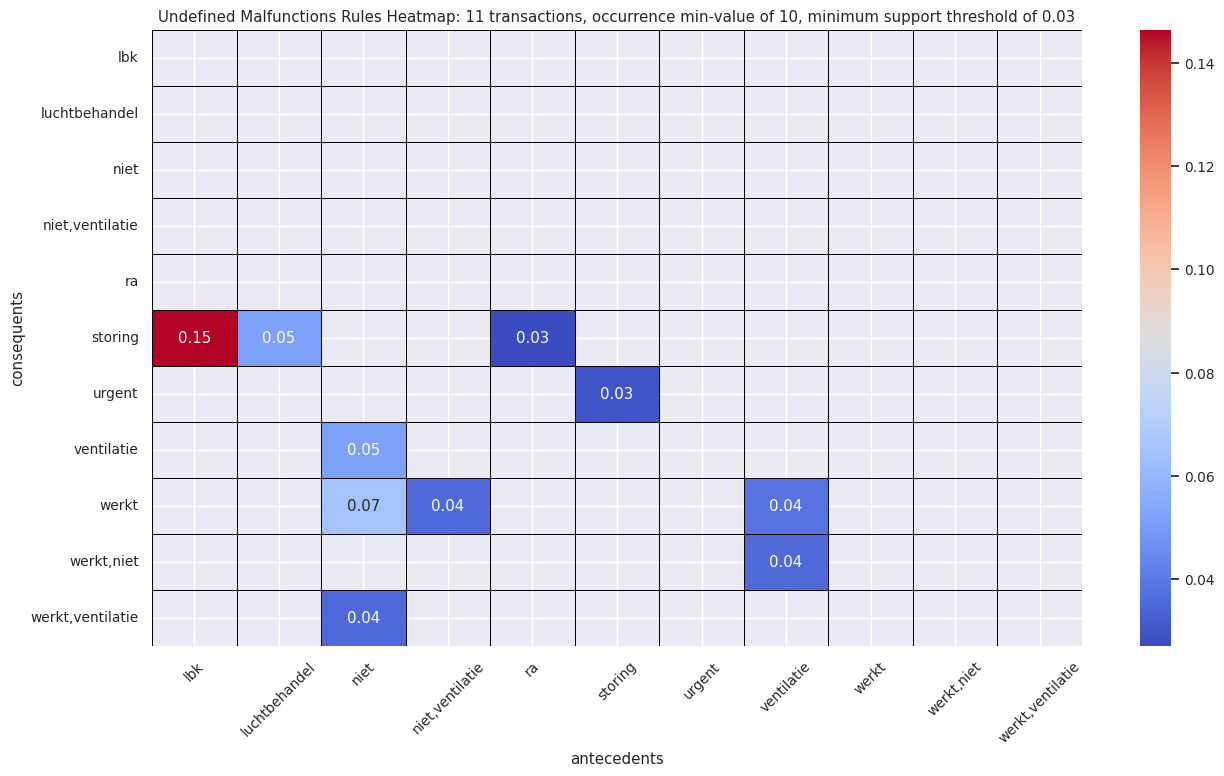

In [ ]:
# Extract the service order descriptions related to 'Undefined Malfunctions' submodule into a list, splitting each description into words.
transactions_undifiedMalfunctions = df_so_cleaned_ventilation[df_so_cleaned_ventilation['submodule'] == 'Undefined Malfunctions']['SO_Omschrijving'].apply(lambda t: t.split(' '))
# Convert the Series of lists into a list of transactions.
transactions_undifiedMalfunctions = list(transactions_undifiedMalfunctions)

# Initialize the TransactionEncoder to convert the list of transactions into a one-hot encoded format.
encoder_undifiedMalfunctions = TransactionEncoder().fit(transactions_undifiedMalfunctions)
# Transform the transactions into one-hot encoded format.
onehot_undifiedMalfunctions = encoder_undifiedMalfunctions.transform(transactions_undifiedMalfunctions)
# Convert the one-hot encoded data into a DataFrame for easier analysis.
onehot_undifiedMalfunctions = pd.DataFrame(onehot_undifiedMalfunctions, columns=encoder_undifiedMalfunctions.columns_)

# Define the minimum number of occurrences for an itemset to be considered frequent.
n = 10
# Calculate the minimum support threshold based on the total number of transactions.
minimum_support = n / len(onehot_undifiedMalfunctions)

# Apply the Apriori algorithm to find frequent itemsets in the one-hot encoded data.
frequent_itemsets_undifiedMalfunctions = apriori(onehot_undifiedMalfunctions,
                            min_support=minimum_support,
                            use_colnames=True,
                            verbose=1)

# Generate association rules from the frequent itemsets using the lift metric.
rules_undifiedMalfunctions = association_rules(frequent_itemsets_undifiedMalfunctions, metric='lift', min_threshold=1)

# Print summary statistics about the transactions and rules generated.
print(f'Number of transactions: {len(onehot_undifiedMalfunctions)}')
print(f'Minimum number of occurrence for each itemset: {n}')
print(f'Minimum support threshold for itemsets: {minimum_support}')
print(f'Number of frequent itemsets: {len(frequent_itemsets_undifiedMalfunctions)}')
print(f'Number of rules: {len(rules_undifiedMalfunctions)}')

# Replace frozen sets in the antecedents and consequents with strings for better readability.
rules_undifiedMalfunctions['antecedents'] = rules_undifiedMalfunctions['antecedents'].apply(lambda a: ','.join(list(a)))
rules_undifiedMalfunctions['consequents'] = rules_undifiedMalfunctions['consequents'].apply(lambda a: ','.join(list(a)))

# Transform data to matrix format for generating a heatmap of the rules.
pivot = rules_undifiedMalfunctions.pivot(index='consequents', columns='antecedents', values='support')

# Create a mask to hide the upper triangle of the heatmap.
mask = np.triu(np.ones_like(pivot, dtype=bool))

# Set the font scale for the seaborn plot.
sns.set(font_scale=0.9)
# Create a figure for the heatmap with specified dimensions.
plt.figure(figsize=(15, 8))

# Generate the heatmap using the pivot table data, specifying color map and annotation options.
heatmap = sns.heatmap(pivot, cmap='coolwarm', cbar=True, linewidths=0.5, linecolor='black', mask=mask, annot=True, fmt='.2f')

# Rotate x-ticks for better visibility.
plt.xticks(rotation=45)
# Set the title for the heatmap with transaction and support information.
plt.title(f'Undefined Malfunctions Rules Heatmap: {len(onehot_cooling)} transactions, occurrence min-value of {n}, minimum support threshold of {minimum_support:.2f}')
# Rotate y-ticks for better visibility.
plt.yticks(rotation=0)
# Save the heatmap figure to the specified file path.
plt.savefig('/content/drive/MyDrive/Kropman/figures/heatmaps/ahu/undefined_malfunctions.png')
# Display the heatmap.
plt.show()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


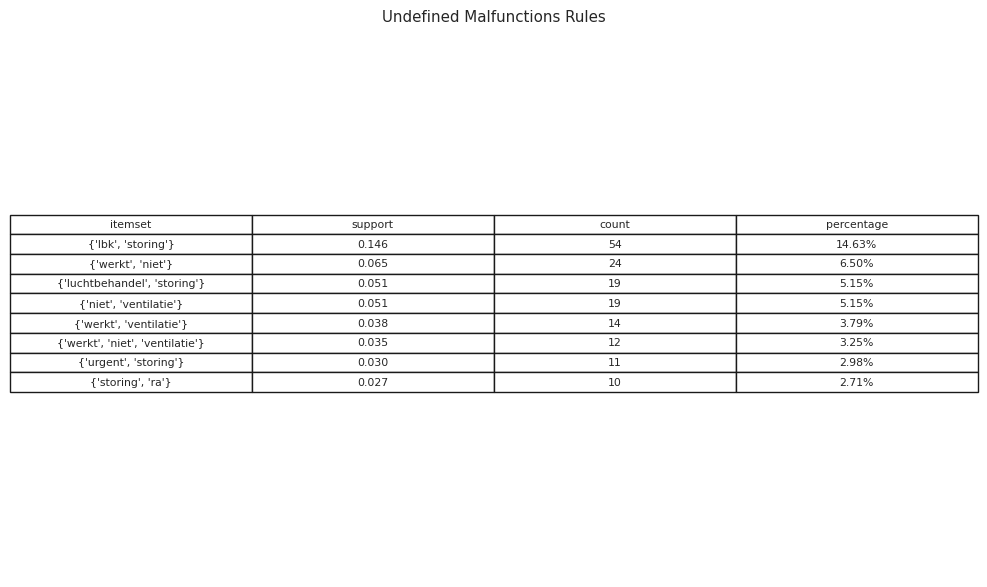

In [ ]:
# Sort the rules by support in descending order for better readability.
rules_undifiedMalfunctions.sort_values(by='support', ascending=False, inplace=True)

# Create a new column 'itemset' that combines the antecedents and consequents into a single string.
rules_undifiedMalfunctions['itemset'] = rules_undifiedMalfunctions.apply(lambda row: f"{row['antecedents']},{row['consequents']}", axis=1)

# Calculate the count of each itemset based on its support and the total number of transactions.
rules_undifiedMalfunctions['count'] = rules_undifiedMalfunctions.apply(lambda row: int(row['support'] * len(onehot_undifiedMalfunctions)), axis=1)

# Convert the 'itemset' strings into sets for easier manipulation in future analyses.
rules_undifiedMalfunctions['itemset'] = rules_undifiedMalfunctions['itemset'].apply(convert_str_to_set)

# Round the support values to three decimal places for easier readability.
rules_undifiedMalfunctions['rounded_support'] = rules_undifiedMalfunctions.apply(lambda row: f"{row['support']:.3f}", axis=1)

# Calculate the percentage of each itemset's occurrences relative to the total transactions.
rules_undifiedMalfunctions['percentage'] = rules_undifiedMalfunctions.apply(lambda row: f"{row['count'] * 100 / len(onehot_undifiedMalfunctions):.2f}%", axis=1)

# Remove duplicate itemsets, keeping only the first occurrence.
rules_undifiedMalfunctions.drop_duplicates(subset=['itemset'], keep='first', inplace=True)

# Reset the index of the DataFrame for cleaner output.
rules_undifiedMalfunctions.reset_index(inplace=True)

# Select relevant columns to display.
rules_undifiedMalfunctions[['itemset', 'support', 'count', 'percentage']]

# Create a figure and axis for the table visualization.
fig, ax = plt.subplots(figsize=(10, 6))

# Set the axis to tight layout and turn off the axis display for clarity.
ax.axis('tight')
ax.axis('off')

# Create a table to display the itemsets along with their rounded support, count, and percentage.
ax.table(cellText=rules_undifiedMalfunctions[['itemset', 'rounded_support', 'count', 'percentage']].values,
         colLabels=rules_undifiedMalfunctions[['itemset', 'support', 'count', 'percentage']].columns,
         cellLoc='center', loc='center', fontsize=12)

# Set the title for the table.
plt.title('Undefined Malfunctions Rules')

# Adjust the layout to prevent clipping of table elements.
plt.tight_layout()

# Save the figure to the specified file path.
plt.savefig('/content/drive/MyDrive/Kropman/figures/tables/ahu/undefined_malfunctions.png')

# Display the table.
plt.show()

## Unknown

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


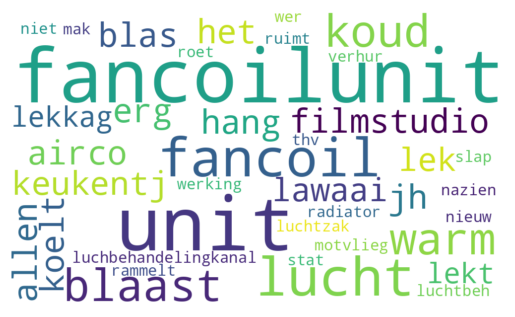

In [ ]:
# Extract the descriptions of service orders that are categorized as 'Uncategorized'.
corpus_unknown = df_so_cleaned_ventilation[df_so_cleaned_ventilation['submodule'] == 'Uncategorized']['SO_Omschrijving'].tolist()

# Initialize the CountVectorizer to convert the text data into a matrix of token counts, considering unigrams.
vectorizer_unknown = CountVectorizer(ngram_range=(1, 1))

# Fit the vectorizer to the corpus and transform it into a document-term matrix (DTM).
dtm_unknown = vectorizer_unknown.fit_transform(corpus_unknown)

# Get the feature names (unique terms) from the CountVectorizer.
terms_unknown = vectorizer_unknown.get_feature_names_out()

# Convert the DTM to a DataFrame for easier manipulation and analysis, using the extracted terms as column headers.
dtm_unknown = pd.DataFrame(dtm_unknown.toarray(), columns=terms_unknown)

# Calculate the term frequencies by summing the occurrences of each term across all documents.
term_frequencies_unknown = dtm_unknown.sum()

# Generate a word cloud image from the term frequencies, specifying the size and background color.
wordcloud = WordCloud(width=1000, height=600, background_color='white').generate_from_frequencies(term_frequencies_unknown)

# Display the generated word cloud.
plt.imshow(wordcloud, interpolation='bilinear')

# Turn off the axis display for a cleaner visualization.
plt.axis('off')

# Save the word cloud image to the specified file path.
plt.savefig('/content/drive/MyDrive/Kropman/figures/word_clouds/ahu/unknown.png')

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Processing 36 combinations | Sampling itemset size 3
Number of transactions: 13
Minimum number of occurrence for each itemset: 2
Minimum support threshold for itemsets: 0.15384615384615385
Number of frequent itemsets: 15
Number of rules: 18


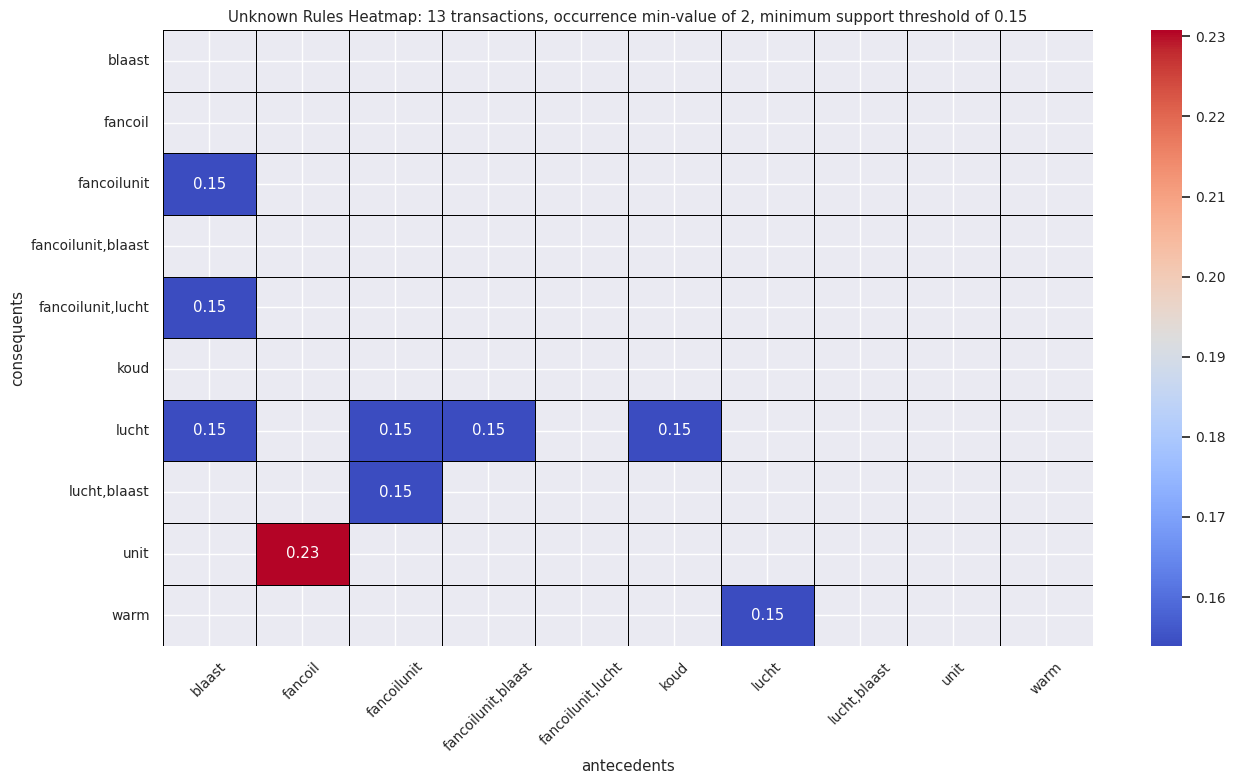

In [ ]:
# Extract the descriptions of service orders that are categorized as 'Uncategorized'.
transactions_unknown = df_so_cleaned_ventilation[df_so_cleaned_ventilation['submodule'] == 'Uncategorized']['SO_Omschrijving'].apply(lambda t: t.split(' '))

# Convert the Series of lists into a list of transactions for further analysis.
transactions_unknown = list(transactions_unknown)

# Initialize the TransactionEncoder to convert the list of transactions into a one-hot encoded format.
encoder_unknown = TransactionEncoder().fit(transactions_unknown)

# Transform the transactions into a one-hot encoded DataFrame.
onehot_unknown = encoder_unknown.transform(transactions_unknown)
onehot_unknown = pd.DataFrame(onehot_unknown, columns=encoder_unknown.columns_)

# Set the minimum occurrence threshold for itemsets.
'''
Define the minimum number of occurrences for each itemset.
This indirectly acts as a hyperparamether, so tune it as you pefer.
Increase the value of "n" if you want to find more frequent itemsets.
Decrease the value of "n" if you want to find less frequent itemsets.
'''
n = 2

# Calculate the minimum support threshold based on the total number of transactions.
minimum_support = n / len(onehot_unknown)

# Generate frequent itemsets using the Apriori algorithm with the specified minimum support.
frequent_itemsets_unknown = apriori(onehot_unknown, min_support=minimum_support, use_colnames=True, verbose=1)

# Generate association rules from the frequent itemsets using 'lift' as the metric.
rules_unknown = association_rules(frequent_itemsets_unknown, metric='lift', min_threshold=1)

# Print out relevant information regarding the transactions and rules generated.
print(f'Number of transactions: {len(onehot_unknown)}')
print(f'Minimum number of occurrence for each itemset: {n}')
print(f'Minimum support threshold for itemsets: {minimum_support}')
print(f'Number of frequent itemsets: {len(frequent_itemsets_unknown)}')
print(f'Number of rules: {len(rules_unknown)}')

# Replace frozen sets with strings for easier readability.
rules_unknown['antecedents'] = rules_unknown['antecedents'].apply(lambda a: ','.join(list(a)))
rules_unknown['consequents'] = rules_unknown['consequents'].apply(lambda a: ','.join(list(a)))

# Transform data to matrix format for visualization and generate a heatmap of the rules.
pivot = rules_unknown.pivot(index='consequents', columns='antecedents', values='support')

# Create a mask to hide the upper triangle of the heatmap.
mask = np.triu(np.ones_like(pivot, dtype=bool))

# Set the font scale for the heatmap annotations.
sns.set(font_scale=0.9)

# Create a figure for the heatmap with specified dimensions.
plt.figure(figsize=(15, 8))

# Generate the heatmap using the pivoted DataFrame, with annotations for support values.
heatmap = sns.heatmap(pivot, cmap='coolwarm', cbar=True, linewidths=0.5, linecolor='black', mask=mask, annot=True, fmt='.2f')

# Rotate the x-axis labels for better visibility.
plt.xticks(rotation=45)

# Set the title of the heatmap, including the number of transactions and thresholds.
plt.title(f'Unknown Rules Heatmap: {len(onehot_unknown)} transactions, occurrence min-value of {n}, minimum support threshold of {minimum_support:.2f}')

# Rotate the y-axis labels for better visibility.
plt.yticks(rotation=0)

# Save the heatmap as an image file to the specified path.
plt.savefig('/content/drive/MyDrive/Kropman/figures/heatmaps/ahu/unknown.png')

# Display the heatmap.
plt.show()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


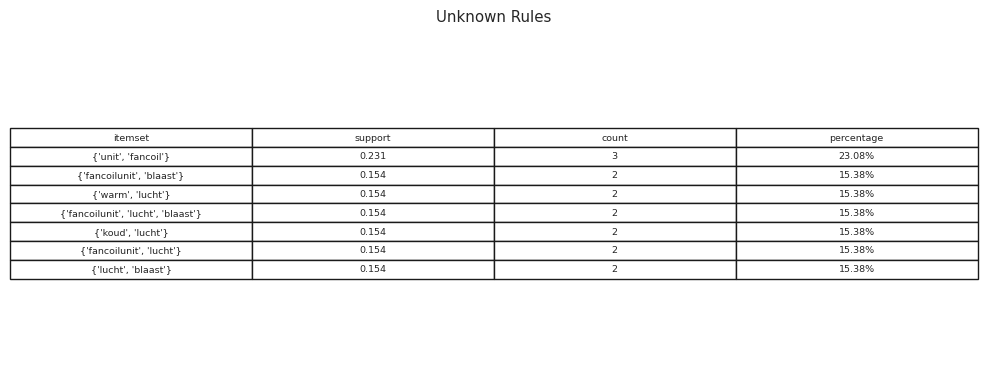

In [ ]:
# Sort the rules by support in descending order.
rules_unknown.sort_values(by='support', ascending=False, inplace=True)

# Create a new column 'itemset' that combines the antecedents and consequents into a single string.
rules_unknown['itemset'] = rules_unknown.apply(lambda row: f"{row['antecedents']},{row['consequents']}", axis=1)

# Calculate the count of occurrences for each rule based on its support and the total number of transactions.
rules_unknown['count'] = rules_unknown.apply(lambda row: int(row['support'] * len(onehot_unknown)), axis=1)

# Convert the 'itemset' strings to sets for easier manipulation and comparison.
rules_unknown['itemset'] = rules_unknown['itemset'].apply(convert_str_to_set)

# Round the support values to three decimal places for better readability.
rules_unknown['rounded_support'] = rules_unknown.apply(lambda row: f"{row['support']:.3f}", axis=1)

# Calculate the percentage of occurrences for each itemset based on the total number of transactions.
rules_unknown['percentage'] = rules_unknown.apply(lambda row: f"{row['count'] * 100 / len(onehot_unknown):.2f}%", axis=1)

# Remove duplicate itemsets, keeping only the first occurrence.
rules_unknown.drop_duplicates(subset=['itemset'], keep='first', inplace=True)

# Reset the index of the DataFrame to ensure proper indexing after sorting and removing duplicates.
rules_unknown.reset_index(inplace=True)

# Display selected columns of the rules DataFrame for verification.
rules_unknown[['itemset', 'support', 'count', 'percentage']]

# Create a figure and axis for the table visualization.
fig, ax = plt.subplots(figsize=(10, 4))

# Set the axis properties to 'tight' to optimize layout and turn off axis visibility.
ax.axis('tight')
ax.axis('off')

# Create a table using the specified cell text and column labels.
ax.table(cellText=rules_unknown[['itemset', 'rounded_support', 'count', 'percentage']].values,
         colLabels=rules_unknown[['itemset', 'support', 'count', 'percentage']].columns,
         cellLoc='center', loc='center', fontsize=12)

# Set the title for the table.
plt.title('Unknown Rules')

# Adjust the layout to fit the table nicely within the figure.
plt.tight_layout()

# Save the table as an image file to the specified path.
plt.savefig('/content/drive/MyDrive/Kropman/figures/tables/ahu/unknown.png')

# Display the table visualization.
plt.show()

# Visualization on SO_Omschrijving + Oorzaaktekst

## Air Filter

In [ ]:
# corpus_airFilter = df_so_cleaned_ventilation[df_so_cleaned_ventilation['submodule'] == 'Air Filter']['so_mixed'].tolist()
# vectorizer_airFilter = CountVectorizer(ngram_range=(1, 1))
# dtm_airFilter = vectorizer_airFilter.fit_transform(corpus_airFilter)
# terms_airFilter = vectorizer_airFilter.get_feature_names_out()
# dtm_airFilter = pd.DataFrame(dtm_airFilter.toarray(), columns=terms_airFilter)
# term_frequencies_airFilter = dtm_airFilter.sum()

# wordcloud = WordCloud(width=1000, height=600, background_color='white').generate_from_frequencies(term_frequencies_airFilter)

# plt.title('Air Filter Word Cloud')
# # plt.figure(figsize=(10, 5))
# plt.imshow(wordcloud, interpolation='bilinear')
# plt.axis('off')
# plt.savefig('/content/drive/MyDrive/Kropman/figures/word_clouds/air_filter_mixed.png')

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
# transactions_airFilter = df_so_cleaned_ventilation[df_so_cleaned_ventilation['submodule'] == 'Air Filter']['so_mixed'].apply(lambda t: t.split(' '))
# transactions_airFilter = list(transactions_airFilter)
# encoder_airFilter = TransactionEncoder().fit(transactions_airFilter)
# onehot_airFilter = encoder_airFilter.transform(transactions_airFilter)
# onehot_airFilter = pd.DataFrame(onehot_airFilter, columns=encoder_airFilter.columns_)

# n = 4
# minimum_support = n/len(onehot_airFilter)
# frequent_itemsets_airFilter = apriori(onehot_airFilter,
#                             min_support =  minimum_support,
#                             use_colnames = True,
#                             verbose = 1)

# rules_airFilter = association_rules(frequent_itemsets_airFilter, metric = 'lift', min_threshold = 1)

# print(f'Number of transactions: {len(onehot_airFilter)}')
# print(f'Minimum number of occurrence for each itemset: {n}')
# print(f'Minimum support threshold for itemsets: {minimum_support}')
# print(f'number of frequent itemsets: {len(frequent_itemsets_airFilter)}')
# print(f'Number of rules: {len(rules_airFilter)}')

# # Replace frozen sets with strings.
# rules_airFilter['antecedents'] = rules_airFilter['antecedents'].apply(lambda a: ','.join(list(a)))
# rules_airFilter['consequents'] = rules_airFilter['consequents'].apply(lambda a: ','.join(list(a)))

# # Transform data to matrix format and generate heatmap.
# pivot = rules_airFilter.pivot(index='consequents', columns='antecedents', values='support')

# mask = np.triu(np.ones_like(pivot, dtype=bool))

# sns.set(font_scale=0.9)  # Adjust the font size as needed
# plt.figure(figsize=(15, 8))  # Adjust width and height as needed

# heatmap = sns.heatmap(pivot, cmap='coolwarm', mask=mask, cbar=True, linewidths=0.5, linecolor='black', annot=True, fmt='.2f')

# plt.xticks(rotation=45)
# plt.title(f'Air Filter Rules Heatmap: {len(onehot_airFilter)} transactions, occurrence min-value of {n}, support threshold of {minimum_support:.2f}')
# plt.yticks(rotation=0)
# plt.show()
# plt.savefig('/content/drive/MyDrive/Kropman/figures/heatmaps/air_filter_mixed.png')

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
# rules_airFilter.sort_values(by='support', ascending=False, inplace=True)
# rules_airFilter['itemset'] = rules_airFilter.apply(lambda row: f"{row['antecedents']},{row['consequents']}", axis=1)
# rules_airFilter['count'] = rules_airFilter.apply(lambda row: int(row['support']*len(onehot_airFilter)), axis=1)
# rules_airFilter['itemset'] = rules_airFilter['itemset'].apply(convert_str_to_set)
# rules_airFilter['rounded_support'] = rules_airFilter.apply(lambda row: f"{row['support']:.3f}", axis=1)
# rules_airFilter['percentage'] = rules_airFilter.apply(lambda row: f"{row['count']*100/len(onehot_airFilter):.2f}%", axis=1)
# rules_airFilter.drop_duplicates(subset=['itemset'], keep='first', inplace=True)
# rules_airFilter.reset_index(inplace=True)
# rules_airFilter[['itemset', 'support', 'count', 'percentage']]

# fig, ax = plt.subplots(figsize=(10, 6))
# ax.axis('tight')
# ax.axis('off')
# ax.table(cellText=rules_airFilter[['itemset', 'rounded_support', 'count', 'percentage']].values,
#          colLabels=rules_airFilter[['itemset', 'support', 'count', 'percentage']].columns,
#          cellLoc='center', loc='center', fontsize=12)

# plt.title('Air Filter Rules')
# plt.tight_layout()
# plt.savefig('/content/drive/MyDrive/Kropman/figures/tables/air_filter_mixed.png')
# plt.show()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


## Fan

In [ ]:
# corpus_fan = df_so_cleaned_ventilation[df_so_cleaned_ventilation['submodule'] == 'Fan']['so_mixed'].tolist()
# vectorizer_fan = CountVectorizer(ngram_range=(1, 1))
# dtm_fan = vectorizer_fan.fit_transform(corpus_fan)
# terms_fan = vectorizer_fan.get_feature_names_out()
# dtm_fan = pd.DataFrame(dtm_fan.toarray(), columns=terms_fan)
# term_frequencies_fan = dtm_fan.sum()

# wordcloud = WordCloud(width=1000, height=600, background_color='white').generate_from_frequencies(term_frequencies_fan)

# plt.title('Fan Word Cloud')
# # plt.figure(figsize=(10, 5))
# plt.imshow(wordcloud, interpolation='bilinear')
# plt.axis('off')
# plt.savefig('/content/drive/MyDrive/Kropman/figures/word_clouds/fan_mixed.png')
# plt.show()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
# transactions_fan = df_so_cleaned_ventilation[df_so_cleaned_ventilation['submodule'] == 'Fan']['so_mixed'].apply(lambda t: t.split(' '))
# transactions_fan = list(transactions_fan)
# encoder_fan = TransactionEncoder().fit(transactions_fan)
# onehot_fan = encoder_fan.transform(transactions_fan)
# onehot_fan = pd.DataFrame(onehot_fan, columns=encoder_fan.columns_)

# n = 5
# minimum_support = n/len(onehot_fan)
# frequent_itemsets_fan = apriori(onehot_fan,
#                             min_support =  minimum_support,
#                             use_colnames = True,
#                             verbose = 1)

# rules_fan = association_rules(frequent_itemsets_fan, metric = 'lift', min_threshold = 1)

# print(f'Number of transactions: {len(onehot_fan)}')
# print(f'Minimum number of occurrence for each itemset: {n}')
# print(f'Minimum support threshold for itemsets: {minimum_support}')
# print(f'number of frequent itemsets: {len(frequent_itemsets_fan)}')
# print(f'Number of rules: {len(rules_fan)}')

# # Replace frozen sets with strings.
# rules_fan['antecedents'] = rules_fan['antecedents'].apply(lambda a: ','.join(list(a)))
# rules_fan['consequents'] = rules_fan['consequents'].apply(lambda a: ','.join(list(a)))

# # Transform data to matrix format and generate heatmap.
# pivot = rules_fan.pivot(index='consequents', columns='antecedents', values='support')

# mask = np.triu(np.ones_like(pivot, dtype=bool))

# sns.set(font_scale=0.9)
# plt.figure(figsize=(15, 8))

# heatmap = sns.heatmap(pivot, cmap='coolwarm', mask=mask, cbar=True, linewidths=0.5, linecolor='black', annot=True, fmt='.2f')

# plt.xticks(rotation=45)
# plt.title(f'Fan Rules Heatmap: {len(onehot_fan)} transactions, occurrence min-value of {n}, support threshold of {minimum_support:.2f}')
# plt.yticks(rotation=0)
# plt.savefig('/content/drive/MyDrive/Kropman/figures/heatmaps/fan_mixed.png')
# plt.show()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
# rules_fan.sort_values(by='support', ascending=False, inplace=True)
# rules_fan['itemset'] = rules_fan.apply(lambda row: f"{row['antecedents']},{row['consequents']}", axis=1)
# rules_fan['count'] = rules_fan.apply(lambda row: int(row['support']*len(onehot_fan)), axis=1)
# rules_fan['itemset'] = rules_fan['itemset'].apply(convert_str_to_set)
# rules_fan['rounded_support'] = rules_fan.apply(lambda row: f"{row['support']:.3f}", axis=1)
# rules_fan['percentage'] = rules_fan.apply(lambda row: f"{row['count']*100/len(onehot_fan):.2f}%", axis=1)
# rules_fan.drop_duplicates(subset=['itemset'], keep='first', inplace=True)
# rules_fan.reset_index(inplace=True)
# rules_fan[['itemset', 'support', 'count', 'percentage']]

# fig, ax = plt.subplots(figsize=(10, 6))
# ax.axis('tight')
# ax.axis('off')
# ax.table(cellText=rules_fan[['itemset', 'rounded_support', 'count', 'percentage']].values,
#          colLabels=rules_fan[['itemset', 'support', 'count', 'percentage']].columns,
#          cellLoc='center', loc='center', fontsize=12)

# plt.title('Fan Rules')
# plt.tight_layout()
# plt.savefig('/content/drive/MyDrive/Kropman/figures/tables/fan_mixed.png')
# plt.show()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


##  Regular Maintenance

In [ ]:
# corpus_regularMaintenance = df_so_cleaned_ventilation[df_so_cleaned_ventilation['submodule'] == 'Regular Maintenance']['so_mixed'].tolist()
# vectorizer_regularMaintenance = CountVectorizer(ngram_range=(1, 1))
# dtm_regularMaintenance = vectorizer_regularMaintenance.fit_transform(corpus_regularMaintenance)
# terms_regularMaintenance = vectorizer_regularMaintenance.get_feature_names_out()
# dtm_regularMaintenance = pd.DataFrame(dtm_regularMaintenance.toarray(), columns=terms_regularMaintenance)
# term_frequencies_regularMaintenance = dtm_regularMaintenance.sum()

# wordcloud = WordCloud(width=1000, height=600, background_color='white').generate_from_frequencies(term_frequencies_regularMaintenance)

# plt.title('Regular Maintenance Word Cloud')
# # plt.figure(figsize=(10, 5))
# plt.imshow(wordcloud, interpolation='bilinear')
# plt.axis('off')
# plt.savefig('/content/drive/MyDrive/Kropman/figures/word_clouds/regular_maintenance_mixed.png')

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
# transactions_regularMaintenance = df_so_cleaned_ventilation[df_so_cleaned_ventilation['submodule'] == 'Regular Maintenance']['so_mixed'].apply(lambda t: t.split(' '))
# transactions_regularMaintenance = list(transactions_regularMaintenance)
# encoder_regularMaintenance = TransactionEncoder().fit(transactions_regularMaintenance)
# onehot_regularMaintenance = encoder_regularMaintenance.transform(transactions_regularMaintenance)
# onehot_regularMaintenance = pd.DataFrame(onehot_regularMaintenance, columns=encoder_regularMaintenance.columns_)

# n = 1
# minimum_support = n/len(onehot_regularMaintenance)
# frequent_itemsets_regularMaintenance = apriori(onehot_regularMaintenance,
#                             min_support =  minimum_support,
#                             use_colnames = True,
#                             verbose = 1)

# rules_regularMaintenance = association_rules(frequent_itemsets_regularMaintenance, metric = 'lift', min_threshold = 1)

# print(f'Number of transactions: {len(onehot_regularMaintenance)}')
# print(f'Minimum number of occurrence for each itemset: {n}')
# print(f'Minimum support threshold for itemsets: {minimum_support}')
# print(f'number of frequent itemsets: {len(frequent_itemsets_regularMaintenance)}')
# print(f'Number of rules: {len(rules_regularMaintenance)}')

# # Replace frozen sets with strings.
# rules_regularMaintenance['antecedents'] = rules_regularMaintenance['antecedents'].apply(lambda a: ','.join(list(a)))
# rules_regularMaintenance['consequents'] = rules_regularMaintenance['consequents'].apply(lambda a: ','.join(list(a)))

# # Transform data to matrix format and generate heatmap.
# pivot = rules_regularMaintenance.pivot(index='consequents', columns='antecedents', values='support')

# mask = np.triu(np.ones_like(pivot, dtype=bool))

# sns.set(font_scale=0.9)  # Adjust the font size as needed
# plt.figure(figsize=(15, 8))  # Adjust width and height as needed

# heatmap = sns.heatmap(pivot, cmap='coolwarm', mask=mask, cbar=True, linewidths=0.5, linecolor='black', annot=True, fmt='.2f')

# plt.xticks(rotation=45)
# plt.title(f'Regular Maintenance Rules Heatmap: {len(onehot_regularMaintenance)} transactions, occurrence min-value of {n}, support threshold of {minimum_support:.2f}')
# plt.yticks(rotation=0)
# plt.savefig('/content/drive/MyDrive/Kropman/figures/heatmaps/regular_maintenance_mixed.png')
# plt.show()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
# rules_regularMaintenance.sort_values(by='support', ascending=False, inplace=True)
# rules_regularMaintenance['itemset'] = rules_regularMaintenance.apply(lambda row: f"{row['antecedents']},{row['consequents']}", axis=1)
# rules_regularMaintenance['count'] = rules_regularMaintenance.apply(lambda row: int(row['support']*len(onehot_regularMaintenance)), axis=1)
# rules_regularMaintenance['itemset'] = rules_regularMaintenance['itemset'].apply(convert_str_to_set)
# rules_regularMaintenance['rounded_support'] = rules_regularMaintenance.apply(lambda row: f"{row['support']:.3f}", axis=1)
# rules_regularMaintenance['percentage'] = rules_regularMaintenance.apply(lambda row: f"{row['count']*100/len(onehot_regularMaintenance):.2f}%", axis=1)
# rules_regularMaintenance.drop_duplicates(subset=['itemset'], keep='first', inplace=True)
# rules_regularMaintenance.reset_index(inplace=True)
# rules_regularMaintenance[['itemset', 'support', 'count', 'percentage']]

# fig, ax = plt.subplots(figsize=(10, 6))
# ax.axis('tight')
# ax.axis('off')
# ax.table(cellText=rules_regularMaintenance[['itemset', 'rounded_support', 'count', 'percentage']].values,
#          colLabels=rules_regularMaintenance[['itemset', 'support', 'count', 'percentage']].columns,
#          cellLoc='center', loc='center', fontsize=12)

# plt.title('Regular Maintenance Rules')
# plt.tight_layout()
# plt.savefig('/content/drive/MyDrive/Kropman/figures/tables/regular_maintenance_mixed.png')
# plt.show()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


## BMS

In [ ]:
# corpus_bms = df_so_cleaned_ventilation[df_so_cleaned_ventilation['submodule'] == 'BMS']['so_mixed'].tolist()
# vectorizer_bms = CountVectorizer(ngram_range=(1, 1))
# dtm_bms = vectorizer_bms.fit_transform(corpus_bms)
# terms_bms = vectorizer_bms.get_feature_names_out()
# dtm_bms = pd.DataFrame(dtm_bms.toarray(), columns=terms_bms)
# term_frequencies_bms = dtm_bms.sum()

# wordcloud = WordCloud(width=1000, height=600, background_color='white').generate_from_frequencies(term_frequencies_bms)

# plt.title('BMS Word Cloud')
# # plt.figure(figsize=(10, 5))
# plt.imshow(wordcloud, interpolation='bilinear')
# plt.axis('off')
# plt.savefig('/content/drive/MyDrive/Kropman/figures/word_clouds/bms_mixed.png')
# plt.show()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
# transactions_bms = df_so_cleaned_ventilation[df_so_cleaned_ventilation['submodule'] == 'BMS']['so_mixed'].apply(lambda t: t.split(' '))
# transactions_bms = list(transactions_bms)
# encoder_bms = TransactionEncoder().fit(transactions_bms)
# onehot_bms = encoder_bms.transform(transactions_bms)
# onehot_bms = pd.DataFrame(onehot_bms, columns=encoder_bms.columns_)

# n = 2
# minimum_support = n/len(onehot_bms)
# frequent_itemsets_bms = apriori(onehot_bms,
#                             min_support =  minimum_support,
#                             use_colnames = True,
#                             verbose = 1)

# rules_bms = association_rules(frequent_itemsets_bms, metric = 'lift', min_threshold = 1)

# print(f'Number of transactions: {len(onehot_bms)}')
# print(f'Minimum number of occurrence for each itemset: {n}')
# print(f'Minimum support threshold for itemsets: {minimum_support}')
# print(f'number of frequent itemsets: {len(frequent_itemsets_bms)}')
# print(f'Number of rules: {len(rules_bms)}')

# # Replace frozen sets with strings.
# rules_bms['antecedents'] = rules_bms['antecedents'].apply(lambda a: ','.join(list(a)))
# rules_bms['consequents'] = rules_bms['consequents'].apply(lambda a: ','.join(list(a)))

# # Transform data to matrix format and generate heatmap.
# pivot = rules_bms.pivot(index='consequents', columns='antecedents', values='support')

# mask = np.triu(np.ones_like(pivot, dtype=bool))

# sns.set(font_scale=0.9)  # Adjust the font size as needed
# plt.figure(figsize=(15, 8))  # Adjust width and height as needed

# heatmap = sns.heatmap(pivot, cmap='coolwarm', cbar=True, linewidths=0.5, linecolor='black', mask=mask, annot=True, fmt='.2f')
# plt.xticks(rotation=45)
# plt.title(f'BMS Rules Heatmap: {len(onehot_bms)} transactions, occurrence min-value of {n}, support threshold of {minimum_support:.2f}')
# plt.yticks(rotation=0)
# plt.savefig('/content/drive/MyDrive/Kropman/figures/heatmaps/bms_mixed.png')
# plt.show()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
# rules_bms.sort_values(by='support', ascending=False, inplace=True)
# rules_bms['itemset'] = rules_bms.apply(lambda row: f"{row['antecedents']},{row['consequents']}", axis=1)
# rules_bms['count'] = rules_bms.apply(lambda row: int(row['support']*len(onehot_bms)), axis=1)
# rules_bms['itemset'] = rules_bms['itemset'].apply(convert_str_to_set)
# rules_bms['rounded_support'] = rules_bms.apply(lambda row: f"{row['support']:.3f}", axis=1)
# rules_bms['percentage'] = rules_bms.apply(lambda row: f"{row['count']*100/len(onehot_bms):.2f}%", axis=1)
# rules_bms.drop_duplicates(subset=['itemset'], keep='first', inplace=True)
# rules_bms.reset_index(inplace=True)
# rules_bms[['itemset', 'support', 'count', 'percentage']]

# fig, ax = plt.subplots(figsize=(10, 6))
# ax.axis('tight')
# ax.axis('off')
# ax.table(cellText=rules_bms[['itemset', 'rounded_support', 'count', 'percentage']].values,
#          colLabels=rules_bms[['itemset', 'support', 'count', 'percentage']].columns,
#          cellLoc='center', loc='center', fontsize=12)

# plt.title('BMS Rules')
# plt.tight_layout()
# plt.savefig('/content/drive/MyDrive/Kropman/figures/tables/bms_mixed.png')
# plt.show()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


## Heating

In [ ]:
# corpus_heating = df_so_cleaned_ventilation[df_so_cleaned_ventilation['submodule'] == 'Heating']['so_mixed'].tolist()
# vectorizer_heating = CountVectorizer(ngram_range=(1, 1))
# dtm_heating = vectorizer_heating.fit_transform(corpus_heating)
# terms_heating = vectorizer_heating.get_feature_names_out()
# dtm_heating = pd.DataFrame(dtm_heating.toarray(), columns=terms_heating)
# term_frequencies_heating = dtm_heating.sum()

# wordcloud = WordCloud(width=1000, height=600, background_color='white').generate_from_frequencies(term_frequencies_heating)

# plt.title('Heating-Sub Word Cloud')
# # plt.figure(figsize=(10, 5))
# plt.imshow(wordcloud, interpolation='bilinear')
# plt.axis('off')
# plt.savefig('/content/drive/MyDrive/Kropman/figures/word_clouds/heating_sub_mixed.png')
# plt.show()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
# transactions_heating = df_so_cleaned_ventilation[df_so_cleaned_ventilation['submodule'] == 'Heating']['so_mixed'].apply(lambda t: t.split(' '))
# transactions_heating = list(transactions_heating)
# encoder_heating = TransactionEncoder().fit(transactions_heating)
# onehot_heating = encoder_heating.transform(transactions_heating)
# onehot_heating = pd.DataFrame(onehot_heating, columns=encoder_heating.columns_)

# n = 3
# minimum_support = n/len(onehot_heating)
# frequent_itemsets_heating = apriori(onehot_heating,
#                             min_support =  minimum_support,
#                             use_colnames = True,
#                             verbose = 1)

# rules_heating = association_rules(frequent_itemsets_heating, metric = 'lift', min_threshold = 1)

# print(f'Number of transactions: {len(onehot_heating)}')
# print(f'Minimum number of occurrence for each itemset: {n}')
# print(f'Minimum support threshold for itemsets: {minimum_support}')
# print(f'number of frequent itemsets: {len(frequent_itemsets_heating)}')
# print(f'Number of rules: {len(rules_heating)}')

# # Replace frozen sets with strings.
# rules_heating['antecedents'] = rules_heating['antecedents'].apply(lambda a: ','.join(list(a)))
# rules_heating['consequents'] = rules_heating['consequents'].apply(lambda a: ','.join(list(a)))

# # Transform data to matrix format and generate heatmap.
# pivot = rules_heating.pivot(index='consequents', columns='antecedents', values='support')

# mask = np.triu(np.ones_like(pivot, dtype=bool))

# sns.set(font_scale=0.9)
# plt.figure(figsize=(15, 8))

# heatmap = sns.heatmap(pivot, cmap='coolwarm', cbar=True, linewidths=0.5, linecolor='black', mask=mask, annot=True, fmt='.2f')
# plt.xticks(rotation=45)
# plt.title(f'Heating_Sub Rules Heatmap: {len(onehot_heating)} transactions, occurrence min-value of {n}, support threshold of {minimum_support:.2f}')
# plt.yticks(rotation=0)
# plt.savefig('/content/drive/MyDrive/Kropman/figures/heatmaps/heating_sub_mixed.png')
# plt.show()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
# rules_heating.sort_values(by='support', ascending=False, inplace=True)
# rules_heating['itemset'] = rules_heating.apply(lambda row: f"{row['antecedents']},{row['consequents']}", axis=1)
# rules_heating['count'] = rules_heating.apply(lambda row: int(row['support']*len(onehot_heating)), axis=1)
# rules_heating['itemset'] = rules_heating['itemset'].apply(convert_str_to_set)
# rules_heating['rounded_support'] = rules_heating.apply(lambda row: f"{row['support']:.3f}", axis=1)
# rules_heating['percentage'] = rules_heating.apply(lambda row: f"{row['count']*100/len(onehot_heating):.2f}%", axis=1)
# rules_heating.drop_duplicates(subset=['itemset'], keep='first', inplace=True)
# rules_heating.reset_index(inplace=True)
# rules_heating[['itemset', 'support', 'count', 'percentage']]

# fig, ax = plt.subplots(figsize=(10, 6))
# ax.axis('tight')
# ax.axis('off')
# ax.table(cellText=rules_heating[['itemset', 'rounded_support', 'count', 'percentage']].values,
#          colLabels=rules_heating[['itemset', 'support', 'count', 'percentage']].columns,
#          cellLoc='center', loc='center', fontsize=12)

# plt.title('Heating_Sub Rules')
# plt.tight_layout()
# plt.savefig('/content/drive/MyDrive/Kropman/figures/tables/heating_sub_mixed.png')
# plt.show()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


## Cooling

In [ ]:
# corpus_cooling = df_so_cleaned_ventilation[df_so_cleaned_ventilation['submodule'] == 'Cooling']['so_mixed'].tolist()
# vectorizer_cooling = CountVectorizer(ngram_range=(1, 1))
# dtm_cooling = vectorizer_cooling.fit_transform(corpus_cooling)
# terms_cooling = vectorizer_cooling.get_feature_names_out()
# dtm_cooling = pd.DataFrame(dtm_cooling.toarray(), columns=terms_cooling)
# term_frequencies_cooling = dtm_cooling.sum()

# wordcloud = WordCloud(width=1000, height=600, background_color='white').generate_from_frequencies(term_frequencies_cooling)

# plt.title('Cooling_Sub Word Cloud')
# # plt.figure(figsize=(10, 5))
# plt.imshow(wordcloud, interpolation='bilinear')
# plt.axis('off')
# plt.savefig('/content/drive/MyDrive/Kropman/figures/word_clouds/cooling_sub_mixed.png')

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
# transactions_cooling = df_so_cleaned_ventilation[df_so_cleaned_ventilation['submodule'] == 'Cooling']['so_mixed'].apply(lambda t: t.split(' '))
# transactions_cooling = list(transactions_cooling)
# encoder_cooling = TransactionEncoder().fit(transactions_cooling)
# onehot_cooling = encoder_cooling.transform(transactions_cooling)
# onehot_cooling = pd.DataFrame(onehot_cooling, columns=encoder_cooling.columns_)

# n = 2
# minimum_support = n/len(onehot_cooling)
# frequent_itemsets_cooling = apriori(onehot_cooling,
#                             min_support =  minimum_support,
#                             use_colnames = True,
#                             verbose = 1)

# rules_cooling = association_rules(frequent_itemsets_cooling, metric = 'lift', min_threshold = 1)

# print(f'Number of transactions: {len(onehot_cooling)}')
# print(f'Minimum number of occurrence for each itemset: {n}')
# print(f'Minimum support threshold for itemsets: {minimum_support}')
# print(f'number of frequent itemsets: {len(frequent_itemsets_cooling)}')
# print(f'Number of rules: {len(rules_cooling)}')

# # Replace frozen sets with strings.
# rules_cooling['antecedents'] = rules_cooling['antecedents'].apply(lambda a: ','.join(list(a)))
# rules_cooling['consequents'] = rules_cooling['consequents'].apply(lambda a: ','.join(list(a)))

# # Transform data to matrix format and generate heatmap.
# pivot = rules_cooling.pivot(index='consequents', columns='antecedents', values='support')

# mask = np.triu(np.ones_like(pivot, dtype=bool))

# sns.set(font_scale=0.9)
# plt.figure(figsize=(15, 8))

# heatmap = sns.heatmap(pivot, cmap='coolwarm', cbar=True, linewidths=0.5, linecolor='black', mask=mask, annot=True, fmt='.2f')
# plt.xticks(rotation=45)
# plt.title(f'Cooling_Sub Rules Heatmap: {len(onehot_cooling)} transactions, occurrence min-value of {n}, support threshold of {minimum_support:.2f}')
# plt.yticks(rotation=0)
# plt.savefig('/content/drive/MyDrive/Kropman/figures/heatmaps/cooling_sub_mixed.png')
# plt.show()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
# rules_cooling.sort_values(by='support', ascending=False, inplace=True)
# rules_cooling['itemset'] = rules_cooling.apply(lambda row: f"{row['antecedents']},{row['consequents']}", axis=1)
# rules_cooling['count'] = rules_cooling.apply(lambda row: int(row['support']*len(onehot_cooling)), axis=1)
# rules_cooling['itemset'] = rules_cooling['itemset'].apply(convert_str_to_set)
# rules_cooling['rounded_support'] = rules_cooling.apply(lambda row: f"{row['support']:.3f}", axis=1)
# rules_cooling['percentage'] = rules_cooling.apply(lambda row: f"{row['count']*100/len(onehot_cooling):.2f}%", axis=1)
# rules_cooling.drop_duplicates(subset=['itemset'], keep='first', inplace=True)
# rules_cooling.reset_index(inplace=True)

# fig, ax = plt.subplots(figsize=(10, 6))
# ax.axis('tight')
# ax.axis('off')
# ax.table(cellText=rules_cooling[['itemset', 'rounded_support', 'count', 'percentage']].values,
#          colLabels=rules_cooling[['itemset', 'support', 'count', 'percentage']].columns,
#          cellLoc='center', loc='center', fontsize=12)

# plt.title('Cooling_Sub Rules')
# plt.tight_layout()
# plt.savefig('/content/drive/MyDrive/Kropman/figures/tables/cooling_sub_mixed.png')
# plt.show()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


## Undified Malfunctions

In [ ]:
# corpus_undifiedMalfunctions = df_so_cleaned_ventilation[df_so_cleaned_ventilation['submodule'] == 'Undified Malfunctions']['so_mixed'].tolist()
# vectorizer_undifiedMalfunctions = CountVectorizer(ngram_range=(1, 1))
# dtm_undifiedMalfunctions = vectorizer_undifiedMalfunctions.fit_transform(corpus_undifiedMalfunctions)
# terms_undifiedMalfunctions = vectorizer_undifiedMalfunctions.get_feature_names_out()
# dtm_undifiedMalfunctions = pd.DataFrame(dtm_undifiedMalfunctions.toarray(), columns=terms_undifiedMalfunctions)
# term_frequencies_undifiedMalfunctions = dtm_undifiedMalfunctions.sum()

# wordcloud = WordCloud(width=1000, height=600, background_color='white').generate_from_frequencies(term_frequencies_undifiedMalfunctions)

# plt.title('Undified Malfunctions Word Cloud')
# # plt.figure(figsize=(10, 5))
# plt.imshow(wordcloud, interpolation='bilinear')
# plt.axis('off')
# plt.savefig('/content/drive/MyDrive/Kropman/figures/word_clouds/undified_malfunctions_mixed.png')

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
# transactions_undifiedMalfunctions = df_so_cleaned_ventilation[df_so_cleaned_ventilation['submodule'] == 'Undified Malfunctions']['so_mixed'].apply(lambda t: t.split(' '))
# transactions_undifiedMalfunctions = list(transactions_undifiedMalfunctions)
# encoder_undifiedMalfunctions = TransactionEncoder().fit(transactions_undifiedMalfunctions)
# onehot_undifiedMalfunctions = encoder_undifiedMalfunctions.transform(transactions_undifiedMalfunctions)
# onehot_undifiedMalfunctions = pd.DataFrame(onehot_undifiedMalfunctions, columns=encoder_undifiedMalfunctions.columns_)

# n = 13
# minimum_support = n/len(onehot_undifiedMalfunctions)
# frequent_itemsets_undifiedMalfunctions = apriori(onehot_undifiedMalfunctions,
#                             min_support =  minimum_support,
#                             use_colnames = True,
#                             verbose = 1)

# rules_undifiedMalfunctions = association_rules(frequent_itemsets_undifiedMalfunctions, metric = 'lift', min_threshold = 1)

# print(f'Number of transactions: {len(onehot_undifiedMalfunctions)}')
# print(f'Minimum number of occurrence for each itemset: {n}')
# print(f'Minimum support threshold for itemsets: {minimum_support}')
# print(f'number of frequent itemsets: {len(frequent_itemsets_undifiedMalfunctions)}')
# print(f'Number of rules: {len(rules_undifiedMalfunctions)}')

# # Replace frozen sets with strings.
# rules_undifiedMalfunctions['antecedents'] = rules_undifiedMalfunctions['antecedents'].apply(lambda a: ','.join(list(a)))
# rules_undifiedMalfunctions['consequents'] = rules_undifiedMalfunctions['consequents'].apply(lambda a: ','.join(list(a)))

# # Transform data to matrix format and generate heatmap.
# pivot = rules_undifiedMalfunctions.pivot(index='consequents', columns='antecedents', values='support')

# mask = np.triu(np.ones_like(pivot, dtype=bool))

# sns.set(font_scale=0.9)
# plt.figure(figsize=(15, 8))

# heatmap = sns.heatmap(pivot, cmap='coolwarm', cbar=True, linewidths=0.5, linecolor='black', mask=mask, annot=True, fmt='.2f')
# plt.xticks(rotation=45)
# plt.title(f'Undified Malfunctions Rules Heatmap: {len(onehot_cooling)} transactions, occurrence min-value of {n}, support threshold of {minimum_support:.2f}')
# plt.yticks(rotation=0)
# plt.savefig('/content/drive/MyDrive/Kropman/figures/heatmaps/undified_malfunctions_mixed.png')
# plt.show()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
# rules_undifiedMalfunctions.sort_values(by='support', ascending=False, inplace=True)
# rules_undifiedMalfunctions['itemset'] = rules_undifiedMalfunctions.apply(lambda row: f"{row['antecedents']},{row['consequents']}", axis=1)
# rules_undifiedMalfunctions['count'] = rules_undifiedMalfunctions.apply(lambda row: int(row['support']*len(onehot_undifiedMalfunctions)), axis=1)
# rules_undifiedMalfunctions['itemset'] = rules_undifiedMalfunctions['itemset'].apply(convert_str_to_set)
# rules_undifiedMalfunctions['rounded_support'] = rules_undifiedMalfunctions.apply(lambda row: f"{row['support']:.3f}", axis=1)
# rules_undifiedMalfunctions['percentage'] = rules_undifiedMalfunctions.apply(lambda row: f"{row['count']*100/len(onehot_undifiedMalfunctions):.2f}%", axis=1)
# rules_undifiedMalfunctions.drop_duplicates(subset=['itemset'], keep='first', inplace=True)
# rules_undifiedMalfunctions.reset_index(inplace=True)
# rules_undifiedMalfunctions[['itemset', 'support', 'count', 'percentage']]

# fig, ax = plt.subplots(figsize=(10, 6))
# ax.axis('tight')
# ax.axis('off')
# ax.table(cellText=rules_undifiedMalfunctions[['itemset', 'rounded_support', 'count', 'percentage']].values,
#          colLabels=rules_undifiedMalfunctions[['itemset', 'support', 'count', 'percentage']].columns,
#          cellLoc='center', loc='center', fontsize=12)

# plt.title('Undified Malfunctions Rules')
# plt.tight_layout()
# plt.savefig('/content/drive/MyDrive/Kropman/figures/tables/undified_malfunctions_mixed.png')
# plt.show()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


## Casing

In [ ]:
# corpus_casing = df_so_cleaned_ventilation[df_so_cleaned_ventilation['submodule'] == 'Casing']['so_mixed'].tolist()
# vectorizer_casing = CountVectorizer(ngram_range=(1, 1))
# dtm_casing = vectorizer_casing.fit_transform(corpus_casing)
# terms_casing = vectorizer_casing.get_feature_names_out()
# dtm_casing = pd.DataFrame(dtm_casing.toarray(), columns=terms_casing)
# term_frequencies_casing = dtm_casing.sum()

# wordcloud = WordCloud(width=1000, height=600, background_color='white').generate_from_frequencies(term_frequencies_casing)

# plt.title('Casing Word Cloud')
# # plt.figure(figsize=(10, 5))
# plt.imshow(wordcloud, interpolation='bilinear')
# plt.axis('off')
# plt.savefig('/content/drive/MyDrive/Kropman/figures/word_clouds/casing_mixed.png')

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
# transactions_casing = df_so_cleaned_ventilation[df_so_cleaned_ventilation['submodule'] == 'Casing']['so_mixed'].apply(lambda t: t.split(' '))
# transactions_casing = list(transactions_casing)
# encoder_casing = TransactionEncoder().fit(transactions_casing)
# onehot_casing = encoder_casing.transform(transactions_casing)
# onehot_casing = pd.DataFrame(onehot_casing, columns=encoder_casing.columns_)

# n = 2
# minimum_support = n/len(onehot_casing)
# frequent_itemsets_casing = apriori(onehot_casing,
#                             min_support =  minimum_support,
#                             use_colnames = True,
#                             verbose = 1)

# rules_casing = association_rules(frequent_itemsets_casing, metric = 'lift', min_threshold = 1)

# print(f'Number of transactions: {len(onehot_casing)}')
# print(f'Minimum number of occurrence for each itemset: {n}')
# print(f'Minimum support threshold for itemsets: {minimum_support}')
# print(f'number of frequent itemsets: {len(frequent_itemsets_casing)}')
# print(f'Number of rules: {len(rules_casing)}')

# # Replace frozen sets with strings.
# rules_casing['antecedents'] = rules_casing['antecedents'].apply(lambda a: ','.join(list(a)))
# rules_casing['consequents'] = rules_casing['consequents'].apply(lambda a: ','.join(list(a)))

# # Transform data to matrix format and generate heatmap.
# pivot = rules_casing.pivot(index='consequents', columns='antecedents', values='support')

# mask = np.triu(np.ones_like(pivot, dtype=bool))

# sns.set(font_scale=0.9)
# plt.figure(figsize=(15, 8))

# heatmap = sns.heatmap(pivot, cmap='coolwarm', cbar=True, linewidths=0.5, linecolor='black', mask=mask, annot=True, fmt='.2f')
# plt.xticks(rotation=45)
# plt.title(f'Casing Rules Heatmap: {len(onehot_casing)} transactions, occurrence min-value of {n}, support threshold of {minimum_support:.2f}')
# plt.yticks(rotation=0)
# plt.savefig('/content/drive/MyDrive/Kropman/figures/heatmaps/casing_mixed.png')
# plt.show()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
# rules_casing.sort_values(by='support', ascending=False, inplace=True)
# rules_casing['itemset'] = rules_casing.apply(lambda row: f"{row['antecedents']},{row['consequents']}", axis=1)
# rules_casing['count'] = rules_casing.apply(lambda row: int(row['support']*len(onehot_casing)), axis=1)
# rules_casing['itemset'] = rules_casing['itemset'].apply(convert_str_to_set)
# rules_casing['rounded_support'] = rules_casing.apply(lambda row: f"{row['support']:.3f}", axis=1)
# rules_casing['percentage'] = rules_casing.apply(lambda row: f"{row['count']*100/len(onehot_casing):.2f}%", axis=1)
# rules_casing.drop_duplicates(subset=['itemset'], keep='first', inplace=True)
# rules_casing.reset_index(inplace=True)
# rules_casing[['itemset', 'support', 'count', 'percentage']]

# fig, ax = plt.subplots(figsize=(10, 6))
# ax.axis('tight')
# ax.axis('off')
# ax.table(cellText=rules_casing[['itemset', 'rounded_support', 'count', 'percentage']].values,
#          colLabels=rules_casing[['itemset', 'support', 'count', 'percentage']].columns,
#          cellLoc='center', loc='center', fontsize=12)

# plt.title('Casing Rules')
# plt.tight_layout()
# plt.savefig('/content/drive/MyDrive/Kropman/figures/tables/casing_mixed.png')
# plt.show()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


## Humidifier

In [ ]:
# corpus_humidifier = df_so_cleaned_ventilation[df_so_cleaned_ventilation['submodule'] == 'Humidifier']['so_mixed'].tolist()
# vectorizer_humidifier = CountVectorizer(ngram_range=(1, 1))
# dtm_humidifier = vectorizer_humidifier.fit_transform(corpus_humidifier)
# terms_humidifier = vectorizer_humidifier.get_feature_names_out()
# dtm_humidifier = pd.DataFrame(dtm_humidifier.toarray(), columns=terms_humidifier)
# term_frequencies_humidifier = dtm_humidifier.sum()

# wordcloud = WordCloud(width=1000, height=600, background_color='white').generate_from_frequencies(term_frequencies_humidifier)

# plt.title('Humidifier Word Cloud')
# # plt.figure(figsize=(10, 5))
# plt.imshow(wordcloud, interpolation='bilinear')
# plt.axis('off')
# plt.savefig('/content/drive/MyDrive/Kropman/figures/word_clouds/humidifier_mixed.png')

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
# transactions_humidifier = df_so_cleaned_ventilation[df_so_cleaned_ventilation['submodule'] == 'Humidifier']['so_mixed'].apply(lambda t: t.split(' '))
# transactions_humidifier = list(transactions_humidifier)
# encoder_humidifier = TransactionEncoder().fit(transactions_humidifier)
# onehot_humidifier = encoder_humidifier.transform(transactions_humidifier)
# onehot_humidifier = pd.DataFrame(onehot_humidifier, columns=encoder_humidifier.columns_)

# n = 5
# minimum_support = n/len(onehot_humidifier)
# frequent_itemsets_humidifier = apriori(onehot_humidifier,
#                             min_support =  minimum_support,
#                             use_colnames = True,
#                             verbose = 1)

# rules_humidifier = association_rules(frequent_itemsets_humidifier, metric = 'lift', min_threshold = 1)

# print(f'Number of transactions: {len(onehot_humidifier)}')
# print(f'Minimum number of occurrence for each itemset: {n}')
# print(f'Minimum support threshold for itemsets: {minimum_support}')
# print(f'number of frequent itemsets: {len(frequent_itemsets_humidifier)}')
# print(f'Number of rules: {len(rules_humidifier)}')

# # Replace frozen sets with strings.
# rules_humidifier['antecedents'] = rules_humidifier['antecedents'].apply(lambda a: ','.join(list(a)))
# rules_humidifier['consequents'] = rules_humidifier['consequents'].apply(lambda a: ','.join(list(a)))

# # Transform data to matrix format and generate heatmap.
# pivot = rules_humidifier.pivot(index='consequents', columns='antecedents', values='support')

# mask = np.triu(np.ones_like(pivot, dtype=bool))

# sns.set(font_scale=0.9)
# plt.figure(figsize=(15, 8))

# heatmap = sns.heatmap(pivot, cmap='coolwarm', cbar=True, linewidths=0.5, linecolor='black', mask=mask, annot=True, fmt='.2f')
# plt.xticks(rotation=45)
# plt.title(f'Humidifier Rules Heatmap: {len(onehot_humidifier)} transactions, occurrence min-value of {n}, support threshold of {minimum_support:.2f}')
# plt.yticks(rotation=0)
# plt.savefig('/content/drive/MyDrive/Kropman/figures/heatmaps/humidifier_mixed.png')
# plt.show()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
# rules_humidifier.sort_values(by='support', ascending=False, inplace=True)
# rules_humidifier['itemset'] = rules_humidifier.apply(lambda row: f"{row['antecedents']},{row['consequents']}", axis=1)
# rules_humidifier['count'] = rules_humidifier.apply(lambda row: int(row['support']*len(onehot_humidifier)), axis=1)
# rules_humidifier['itemset'] = rules_humidifier['itemset'].apply(convert_str_to_set)
# rules_humidifier['rounded_support'] = rules_humidifier.apply(lambda row: f"{row['support']:.3f}", axis=1)
# rules_humidifier['percentage'] = rules_humidifier.apply(lambda row: f"{row['count']*100/len(onehot_humidifier):.2f}%", axis=1)
# rules_humidifier.drop_duplicates(subset=['itemset'], keep='first', inplace=True)
# rules_humidifier.reset_index(inplace=True)
# rules_humidifier[['itemset', 'support', 'count', 'percentage']]

# fig, ax = plt.subplots(figsize=(10, 6))
# ax.axis('tight')
# ax.axis('off')
# ax.table(cellText=rules_humidifier[['itemset', 'rounded_support', 'count', 'percentage']].values,
#          colLabels=rules_humidifier[['itemset', 'support', 'count', 'percentage']].columns,
#          cellLoc='center', loc='center', fontsize=12)

# plt.title('Humidifier Rules')
# plt.tight_layout()
# plt.savefig('/content/drive/MyDrive/Kropman/figures/tables/humidifier_mixed.png')
# plt.show()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


## Heat Exchanger

In [ ]:
# corpus_heatExchanger = df_so_cleaned_ventilation[df_so_cleaned_ventilation['submodule'] == 'Heat Exchanger']['so_mixed'].tolist()
# vectorizer_heatExchanger = CountVectorizer(ngram_range=(1, 1))
# dtm_heatExchanger = vectorizer_heatExchanger.fit_transform(corpus_heatExchanger)
# terms_heatExchanger = vectorizer_heatExchanger.get_feature_names_out()
# dtm_heatExchanger = pd.DataFrame(dtm_heatExchanger.toarray(), columns=terms_heatExchanger)
# term_frequencies_heatExchanger = dtm_heatExchanger.sum()

# wordcloud = WordCloud(width=1000, height=600, background_color='white').generate_from_frequencies(term_frequencies_heatExchanger)

# plt.title('Heat Exchanger Word Cloud')
# # plt.figure(figsize=(10, 5))
# plt.imshow(wordcloud, interpolation='bilinear')
# plt.axis('off')
# plt.savefig('/content/drive/MyDrive/Kropman/figures/word_clouds/heat_exchanger_mixed.png')

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
# transactions_heatExchanger = df_so_cleaned_ventilation[df_so_cleaned_ventilation['submodule'] == 'Heat Exchanger']['so_mixed'].apply(lambda t: t.split(' '))
# transactions_heatExchanger = list(transactions_heatExchanger)
# encoder_heatExchanger = TransactionEncoder().fit(transactions_heatExchanger)
# onehot_heatExchanger = encoder_heatExchanger.transform(transactions_heatExchanger)
# onehot_heatExchanger = pd.DataFrame(onehot_heatExchanger, columns=encoder_heatExchanger.columns_)

# n = 3
# minimum_support = n/len(onehot_heatExchanger)
# frequent_itemsets_heatExchanger = apriori(onehot_heatExchanger,
#                             min_support =  minimum_support,
#                             use_colnames = True,
#                             verbose = 1)

# rules_heatExchanger = association_rules(frequent_itemsets_heatExchanger, metric = 'lift', min_threshold = 1)

# print(f'Number of transactions: {len(onehot_heatExchanger)}')
# print(f'Minimum number of occurrence for each itemset: {n}')
# print(f'Minimum support threshold for itemsets: {minimum_support}')
# print(f'number of frequent itemsets: {len(frequent_itemsets_heatExchanger)}')
# print(f'Number of rules: {len(rules_heatExchanger)}')

# # Replace frozen sets with strings.
# rules_heatExchanger['antecedents'] = rules_heatExchanger['antecedents'].apply(lambda a: ','.join(list(a)))
# rules_heatExchanger['consequents'] = rules_heatExchanger['consequents'].apply(lambda a: ','.join(list(a)))

# # Transform data to matrix format and generate heatmap.
# pivot = rules_heatExchanger.pivot(index='consequents', columns='antecedents', values='support')

# mask = np.triu(np.ones_like(pivot, dtype=bool))

# sns.set(font_scale=0.9)
# plt.figure(figsize=(15, 8))

# heatmap = sns.heatmap(pivot, cmap='coolwarm', cbar=True, linewidths=0.5, linecolor='black', mask=mask, annot=True, fmt='.2f')
# plt.xticks(rotation=45)
# plt.title(f'Heat Exchanger Rules Heatmap: {len(onehot_heatExchanger)} transactions, occurrence min-value of {n}, support threshold of {minimum_support:.2f}')
# plt.yticks(rotation=0)
# plt.savefig('/content/drive/MyDrive/Kropman/figures/heatmaps/heat_exchanger_mixed.png')
# plt.show()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
# rules_heatExchanger.sort_values(by='support', ascending=False, inplace=True)
# rules_heatExchanger['itemset'] = rules_heatExchanger.apply(lambda row: f"{row['antecedents']},{row['consequents']}", axis=1)
# rules_heatExchanger['count'] = rules_heatExchanger.apply(lambda row: int(row['support']*len(onehot_heatExchanger)), axis=1)
# rules_heatExchanger['itemset'] = rules_heatExchanger['itemset'].apply(convert_str_to_set)
# rules_heatExchanger['rounded_support'] = rules_heatExchanger.apply(lambda row: f"{row['support']:.3f}", axis=1)
# rules_heatExchanger['percentage'] = rules_heatExchanger.apply(lambda row: f"{row['count']*100/len(onehot_heatExchanger):.2f}%", axis=1)
# rules_heatExchanger.drop_duplicates(subset=['itemset'], keep='first', inplace=True)
# rules_heatExchanger.reset_index(inplace=True)
# rules_heatExchanger[['itemset', 'support', 'count', 'percentage']]

# fig, ax = plt.subplots(figsize=(10, 6))
# ax.axis('tight')
# ax.axis('off')
# ax.table(cellText=rules_heatExchanger[['itemset', 'rounded_support', 'count', 'percentage']].values,
#          colLabels=rules_heatExchanger[['itemset', 'support', 'count', 'percentage']].columns,
#          cellLoc='center', loc='center', fontsize=12)

# plt.title('Heat Exchanger Rules')
# plt.tight_layout()
# plt.savefig('/content/drive/MyDrive/Kropman/figures/tables/heat_exchanger_mixed.png')
# plt.show()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


## Damper

In [ ]:
# corpus_damper = df_so_cleaned_ventilation[df_so_cleaned_ventilation['submodule'] == 'Damper']['so_mixed'].tolist()
# vectorizer_damper = CountVectorizer(ngram_range=(1, 1))
# dtm_damper = vectorizer_damper.fit_transform(corpus_damper)
# terms_damper = vectorizer_damper.get_feature_names_out()
# dtm_damper = pd.DataFrame(dtm_damper.toarray(), columns=terms_damper)
# term_frequencies_damper = dtm_damper.sum()

# wordcloud = WordCloud(width=1000, height=600, background_color='white').generate_from_frequencies(term_frequencies_damper)

# plt.title('Damper Word Cloud')
# # plt.figure(figsize=(10, 5))
# plt.imshow(wordcloud, interpolation='bilinear')
# plt.axis('off')
# plt.savefig('/content/drive/MyDrive/Kropman/figures/word_clouds/damper_mixed.png')

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
# transactions_damper = df_so_cleaned_ventilation[df_so_cleaned_ventilation['submodule'] == 'Damper']['so_mixed'].apply(lambda t: t.split(' '))
# transactions_damper = list(transactions_damper)
# encoder_damper = TransactionEncoder().fit(transactions_damper)
# onehot_damper = encoder_damper.transform(transactions_damper)
# onehot_damper = pd.DataFrame(onehot_damper, columns=encoder_damper.columns_)

# n = 1
# minimum_support = n/len(onehot_damper)
# frequent_itemsets_damper = apriori(onehot_damper,
#                             min_support =  minimum_support,
#                             use_colnames = True,
#                             verbose = 1)

# rules_damper = association_rules(frequent_itemsets_damper, metric = 'lift', min_threshold = 1)

# print(f'Number of transactions: {len(onehot_damper)}')
# print(f'Minimum number of occurrence for each itemset: {n}')
# print(f'Minimum support threshold for itemsets: {minimum_support}')
# print(f'number of frequent itemsets: {len(frequent_itemsets_damper)}')
# print(f'Number of rules: {len(rules_damper)}')

# # Replace frozen sets with strings.
# rules_damper['antecedents'] = rules_damper['antecedents'].apply(lambda a: ','.join(list(a)))
# rules_damper['consequents'] = rules_damper['consequents'].apply(lambda a: ','.join(list(a)))

# # Transform data to matrix format and generate heatmap.
# pivot = rules_damper.pivot(index='consequents', columns='antecedents', values='support')

# mask = np.triu(np.ones_like(pivot, dtype=bool))

# sns.set(font_scale=0.9)
# plt.figure(figsize=(15, 8))
# heatmap = sns.heatmap(pivot, cmap='coolwarm', cbar=True, linewidths=0.5, linecolor='black', mask=mask, annot=True, fmt='.2f')
# plt.xticks(rotation=45)
# plt.title(f'Damper Rules Heatmap: {len(onehot_damper)} transactions, occurrence min-value of {n}, support threshold of {minimum_support:.2f}')
# plt.yticks(rotation=0)
# plt.savefig('/content/drive/MyDrive/Kropman/figures/heatmaps/damper_mixed.png')
# plt.show()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
# rules_damper.sort_values(by='support', ascending=False, inplace=True)
# rules_damper['itemset'] = rules_damper.apply(lambda row: f"{row['antecedents']},{row['consequents']}", axis=1)
# rules_damper['count'] = rules_damper.apply(lambda row: int(row['support']*len(onehot_damper)), axis=1)
# rules_damper['itemset'] = rules_damper['itemset'].apply(convert_str_to_set)
# rules_damper['rounded_support'] = rules_damper.apply(lambda row: f"{row['support']:.3f}", axis=1)
# rules_damper['percentage'] = rules_damper.apply(lambda row: f"{row['count']*100/len(onehot_damper):.2f}%", axis=1)
# rules_damper.drop_duplicates(subset=['itemset'], keep='first', inplace=True)
# rules_damper.reset_index(inplace=True)
# rules_damper[['itemset', 'support', 'count', 'percentage']]

# fig, ax = plt.subplots(figsize=(10, 6))
# ax.axis('tight')
# ax.axis('off')
# ax.table(cellText=rules_damper[['itemset', 'rounded_support', 'count', 'percentage']].values,
#          colLabels=rules_damper[['itemset', 'support', 'count', 'percentage']].columns,
#          cellLoc='center', loc='center', fontsize=12)

# plt.title('Damper Rules')
# plt.tight_layout()
# plt.savefig('/content/drive/MyDrive/Kropman/figures/tables/damper_mixed.png')
# plt.show()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


## Unknown

In [ ]:
# corpus_unknown = df_so_cleaned_ventilation[df_so_cleaned_ventilation['submodule'] == 'Unknown']['so_mixed'].tolist()
# vectorizer_unknown = CountVectorizer(ngram_range=(1, 1))
# dtm_unknown = vectorizer_unknown.fit_transform(corpus_unknown)
# terms_unknown = vectorizer_unknown.get_feature_names_out()
# dtm_unknown = pd.DataFrame(dtm_unknown.toarray(), columns=terms_unknown)
# term_frequencies_unknown = dtm_unknown.sum()

# wordcloud = WordCloud(width=1000, height=600, background_color='white').generate_from_frequencies(term_frequencies_unknown)

# plt.title('Unknown Word Cloud')
# # plt.figure(figsize=(10, 5))
# plt.imshow(wordcloud, interpolation='bilinear')
# plt.axis('off')
# plt.savefig('/content/drive/MyDrive/Kropman/figures/word_clouds/unknown_mixed.png')

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
# transactions_unknown = df_so_cleaned_ventilation[df_so_cleaned_ventilation['submodule'] == 'Unknown']['so_mixed'].apply(lambda t: t.split(' '))
# transactions_unknown = list(transactions_unknown)
# encoder_unknown = TransactionEncoder().fit(transactions_unknown)
# onehot_unknown = encoder_unknown.transform(transactions_unknown)
# onehot_unknown = pd.DataFrame(onehot_unknown, columns=encoder_unknown.columns_)

# n = 8
# minimum_support = n/len(onehot_unknown)
# frequent_itemsets_unknown = apriori(onehot_unknown,
#                             min_support =  minimum_support,
#                             use_colnames = True,
#                             verbose = 1)

# rules_unknown = association_rules(frequent_itemsets_unknown, metric = 'lift', min_threshold = 1)

# print(f'Number of transactions: {len(onehot_unknown)}')
# print(f'Minimum number of occurrence for each itemset: {n}')
# print(f'Minimum support threshold for itemsets: {minimum_support}')
# print(f'number of frequent itemsets: {len(frequent_itemsets_unknown)}')
# print(f'Number of rules: {len(rules_unknown)}')

# # Replace frozen sets with strings.
# rules_unknown['antecedents'] = rules_unknown['antecedents'].apply(lambda a: ','.join(list(a)))
# rules_unknown['consequents'] = rules_unknown['consequents'].apply(lambda a: ','.join(list(a)))

# # Transform data to matrix format and generate heatmap.
# pivot = rules_unknown.pivot(index='consequents', columns='antecedents', values='support')

# mask = np.triu(np.ones_like(pivot, dtype=bool))

# sns.set(font_scale=0.9)
# plt.figure(figsize=(15, 8))

# heatmap = sns.heatmap(pivot, cmap='coolwarm', cbar=True, linewidths=0.5, linecolor='black', mask=mask, annot=True, fmt='.2f')
# plt.xticks(rotation=45)
# plt.title(f'Unknown Rules Heatmap: {len(onehot_unknown)} transactions, occurrence min-value of {n}, support threshold of {minimum_support:.2f}')
# plt.yticks(rotation=0)
# plt.savefig('/content/drive/MyDrive/Kropman/figures/heatmaps/unknown_mixed.png')
# plt.show()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
# rules_unknown.sort_values(by='support', ascending=False, inplace=True)
# rules_unknown['itemset'] = rules_unknown.apply(lambda row: f"{row['antecedents']},{row['consequents']}", axis=1)
# rules_unknown['count'] = rules_unknown.apply(lambda row: int(row['support']*len(onehot_unknown)), axis=1)
# rules_unknown['itemset'] = rules_unknown['itemset'].apply(convert_str_to_set)
# rules_unknown['rounded_support'] = rules_unknown.apply(lambda row: f"{row['support']:.3f}", axis=1)
# rules_unknown['percentage'] = rules_unknown.apply(lambda row: f"{row['count']*100/len(onehot_unknown):.2f}%", axis=1)
# rules_unknown.drop_duplicates(subset=['itemset'], keep='first', inplace=True)
# rules_unknown.reset_index(inplace=True)
# rules_unknown[['itemset', 'support', 'count', 'percentage']]

# fig, ax = plt.subplots(figsize=(10, 6))
# ax.axis('tight')
# ax.axis('off')
# ax.table(cellText=rules_unknown[['itemset', 'rounded_support', 'count', 'percentage']].values,
#          colLabels=rules_unknown[['itemset', 'support', 'count', 'percentage']].columns,
#          cellLoc='center', loc='center', fontsize=12)

# plt.title('Unknown Rules')
# plt.tight_layout()
# plt.savefig('/content/drive/MyDrive/Kropman/figures/tables/unknown_mixed.png')
# plt.show()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
